## Single Cell Analysis

In this notebook we are conducting single-cell RNA sequencing analysis in python scanpy on the **White Adipose Atlas** dataset [GitHub](https://gitlab.com/rosen-lab/white-adipose-atlas), focusing on lipid-associated macrophages (LAMs). Our goal is to investigate the correlations between LAM Cells, adipocytes, inflammatory macrophages, and BMI groups, aiming to better understand how LAMs interact with adipocytes across different metabolic conditions. Through this analysis, I aim to uncover predictive insights into the role of macrophages in fat tissue under varying BMI conditions.

## 1.Preprocssing & QC

Importing the necessary libraries

In [2]:
import pandas as pd
import os
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse

In [3]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [4]:
#import doubletdetection
#from scipy.stats import median_abs_deviation as mad
import numpy as np

#### 1. Doublet Detection

Initializing the `BoostClassifier` from the `doubletdetection` package with specific parameters. The classifier will perform doublet detection using 10 iterations (`n_iters=10`), apply the Louvain clustering algorithm, and scale features with standard scaling (`standard_scaling=True`). A pseudocount of 0.1 is added to avoid zero values, and the computation is parallelized across all available CPU cores (`n_jobs=-1`).

In [10]:
clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="louvain",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1)

Initializing a function `mad_outlier` that identifies outliers in a given metric of an AnnData object. The function uses the Median Absolute Deviation (MAD) to detect outliers. The threshold for outlier detection is based on the number of MADs from the median (`nmads`). 

If `upper_only` is set to `True`, only values above the upper threshold are flagged as outliers; otherwise, both lower and upper outliers are identified.

In [14]:
def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]
    
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    
    return (M > np.median(M) + nmads * mad(M))

Now we can define a preprocessing function `pp()` that filters out cells based on mitochondrial content and various outlier metrics using the Median Absolute Deviation (MAD) method. 

It also detects and removes doublets using a `BoostClassifier` and stores the doublet information in the AnnData object's `obs`. Finally, it updates the object with the number of cells and doublets removed. The directory for processed files is set to "pp1," where `.h5ad` files are located.

In [15]:
from scipy.stats import median_abs_deviation as mad
import numpy as np
import gc

# Define the directory for processed files
processed_dir = "pp1"
processed_files = [os.path.join(processed_dir, f) for f in os.listdir(processed_dir) if f.endswith(".h5ad")]


def pp(adata):
    adata = adata[adata.obs.pct_counts_mt < 25]  # Filter based on mitochondrial content
    
    bool_vector = (mad_outlier(adata, 'log1p_total_counts', 5) |
                   mad_outlier(adata, 'log1p_n_genes_by_counts', 5) |
                   mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) |
                   mad_outlier(adata, 'pct_counts_mt', 3, upper_only=True))
    
    adata = adata[~bool_vector]
    adata.uns['cells_removed'] = sum(bool_vector)
    
    doublets = clf.fit(adata.X).predict(p_thresh=1e-3, voter_thresh=0.5)
    doublet_score = clf.doublet_score()

    adata.obs["doublet"] = doublets
    adata.obs["doublet_score"] = doublet_score

    adata.uns['doublets_removed'] = adata.obs.doublet.sum()
    adata = adata[adata.obs.doublet == 0]

    return adata

Now, we are iterating over each AnnData object located in the `processed_files` directory. For each file, we read the data, apply the preprocessing function `pp()` to filter cells and detect doublets, and then save the processed AnnData object to the `processed1` directory. After saving, we delete the original and processed objects from memory to optimize resource usage, and run the garbage collector to ensure efficient memory management throughout the process.

In [16]:
# Process each AnnData object individually
for file in processed_files:
    adata = sc.read_h5ad(file)
    processed_adata = pp(adata)
    
    # Save processed AnnData object
    processed_file = os.path.join("processed1", os.path.basename(file))  # Define save path
    processed_adata.write(processed_file)

    # Clean up memory
    del adata
    del processed_adata
    gc.collect()  # Run garbage collector to free up memory

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

## 2. Integration

We are defining a memory-efficient function `memory_efficient_combine` to combine multiple AnnData files into one large dataset. 

The function processes files in batches, uses sparse matrices to conserve memory, and reduces the precision of numerical data. After each batch, memory is cleared using the garbage collector. Finally, the combined dataset is saved in a compressed `.h5ad` format. This approach ensures efficient handling of large datasets without exceeding memory limitations.

In [6]:
import gc

def memory_efficient_combine(processed_dir, output_file, batch_size=5):
    """
    Combines AnnData files in a memory-efficient way by:
    1. Processing files in smaller batches
    2. Using sparse matrices
    3. Clearing memory after each batch
    4. Optionally reducing precision of numerical data
    
    Args:
        processed_dir (str): Directory containing .h5ad files
        output_file (str): Path for output combined file
        batch_size (int): Number of files to process at once
    """
    # Get list of all h5ad files
    h5ad_files = [f for f in os.listdir(processed_dir) if f.endswith('.h5ad')]
    
    if not h5ad_files:
        raise ValueError(f"No .h5ad files found in {processed_dir}")
    
    # Initialize with first file
    print(f"Loading initial file: {h5ad_files[0]}")
    adata_combined = sc.read_h5ad(os.path.join(processed_dir, h5ad_files[0]))
    
    # Convert to sparse if dense
    if not scipy.sparse.issparse(adata_combined.X):
        adata_combined.X = scipy.sparse.csr_matrix(adata_combined.X)
    
    # Process remaining files in batches
    remaining_files = h5ad_files[1:]
    for i in range(0, len(remaining_files), batch_size):
        batch_files = remaining_files[i:i + batch_size]
        batch_adatas = []
        
        # Load batch of files
        for file in batch_files:
            print(f"Loading file: {file}")
            file_path = os.path.join(processed_dir, file)
            adata = sc.read_h5ad(file_path)
            
            # Convert to sparse if dense
            if not scipy.sparse.issparse(adata.X):
                adata.X = scipy.sparse.csr_matrix(adata.X)
            
            adata.X = adata.X.astype(np.float32)
            
            batch_adatas.append(adata)
        
        # Combine batch with existing data
        print(f"Combining batch {i//batch_size + 1}")
        if batch_adatas:
            adata_combined = adata_combined.concatenate(
                *batch_adatas,
                join='outer',
                index_unique=None  # Avoid creating new index
            )
        
        # Clear batch from memory
        del batch_adatas
        gc.collect()
        
    
    # Convert back to sparse matrix format and compress
    adata_combined.X = scipy.sparse.csr_matrix(adata_combined.X)
    
    # Save final result
    print(f"Saving final combined dataset to {output_file}")
    adata_combined.write_h5ad(output_file, compression='lzf')
    
    return adata_combined

This code attempts to combine multiple AnnData files in the "processed1" directory into a single dataset using the `memory_efficient_combine` function. The `batch_size` parameter controls how many files are processed at once, helping manage memory usage. If an error occurs during the process, the exception is caught, and an error message is printed. The final combined dataset is saved as "combined_data.h5ad".

In [7]:
try:
    processed_dir = "processed1"
    output_file = "combined_data.h5ad"
    
    # You can adjust batch_size based on your available RAM
    adata_combined = memory_efficient_combine(
        processed_dir=processed_dir,
        output_file=output_file,
        batch_size=5  # Adjust this number based on your RAM
    )
    
except Exception as e:
    print(f"An error occurred: {str(e)}")

Loading initial file: Mm_POV_04-1.h5ad
Loading file: Hs_SAT_10-1.h5ad
Loading file: Hs_OAT_10-1.h5ad
Loading file: Mm_ING_12-1.h5ad
Loading file: Hs_SAT_266-1.h5ad
Loading file: Mm_ING_13-1.h5ad
Combining batch 1
Loading file: Mm_ING_16-1.h5ad
Loading file: Hs_SAT_253-1.h5ad
Loading file: Mm_EPI_11-1.h5ad
Loading file: Mm_EPI_10-2.h5ad
Loading file: Mm_ING_17-1.h5ad
Combining batch 2
Loading file: Hs_OAT_12-1.h5ad
Loading file: Hs_SAT_01-1.h5ad
Loading file: Mm_EPI_12-1.h5ad
Loading file: Hs_SAT_255-1.h5ad
Loading file: Hs_SAT_02-1.h5ad
Combining batch 3
Loading file: Hs_OAT_253-1.h5ad
Loading file: Hs_OAT_256-1.h5ad
Loading file: Mm_ING_10-2.h5ad
Loading file: Mm_ING_22-1.h5ad
Loading file: Mm_EPI_18-1.h5ad
Combining batch 4
Loading file: Hs_SAT_13-1.h5ad
Loading file: Hs_SAT_09-1.h5ad
Loading file: Mm_ING_10-1.h5ad
Loading file: Hs_OAT_254-1.h5ad
Loading file: Mm_ING_11-1.h5ad
Combining batch 5
Loading file: Mm_EPI_17-1.h5ad
Loading file: Hs_OAT_01-2.h5ad
Loading file: Hs_SAT_254-1.h

The `fix_var_names` function modifies the `var_names` in an AnnData object to use gene names instead of numerical identifiers. It handles duplicate gene names by appending suffixes to make them unique. The original index is saved as a new column, and after setting the gene names as `var_names`, the function ensures uniqueness and validity of the names. 

Finally, it saves the modified AnnData object to the specified file path and returns the updated object.

In [15]:
def fix_var_names(adata, output_file):
    """
    Fix var_names in AnnData object to use gene names instead of numbers.
    
    Args:
        adata: AnnData object
        output_file: Path to save the modified AnnData object
    """
    print("Current var_names:", adata.var_names[:5])
    print("Current GENE column:", adata.var['GENE'][:5])
    
    # Create a copy of the GENE column before making changes
    gene_names = adata.var['GENE'].copy()
    
    # Check for duplicates in gene names
    duplicate_genes = gene_names[gene_names.duplicated()].unique()
    if len(duplicate_genes) > 0:
        print(f"Warning: Found {len(duplicate_genes)} duplicate gene names")
        # Make duplicate gene names unique by adding suffix
        for i, (idx, gene) in enumerate(gene_names.duplicated(keep=False).items()):
            if gene:
                gene_names.iloc[idx] = f"{gene_names.iloc[idx]}_{i}"
    
    # Store original index as a column if needed
    adata.var['original_index'] = adata.var.index
    
    # Set gene names as new index/var_names
    adata.var_names = gene_names
    
    # Make sure var_names are unique and valid
    adata.var_names_make_unique()
    
    # Drop the GENE column since it's now the index
    if 'GENE' in adata.var.columns:
        adata.var = adata.var.drop('GENE', axis=1)
    
    print("\nAfter fixing:")
    print("New var_names:", adata.var_names[:5])
    
    # Save the modified AnnData object
    print(f"\nSaving modified AnnData to {output_file}")
    adata.write_h5ad(output_file, compression='lzf')
    
    return adata


In [16]:
try:
    # Load your combined data
    #input_file = "combined_data.h5ad"
    output_file = "combined_data_fixed_names.h5ad"
    
    #print("Loading AnnData object...")
    #adata = sc.read_h5ad(input_file)
    
    # Fix the var_names
    adata = fix_var_names(adata, output_file)
    
    print("Done!")
    
except Exception as e:
    print(f"An error occurred: {str(e)}")

Current var_names: Index(['0', '1', '2', '3', '4'], dtype='object')
Current GENE column: 0    0610005C13Rik
1    0610006L08Rik
2    0610009B22Rik
3    0610009E02Rik
4    0610009O20Rik
Name: GENE, dtype: object

After fixing:
New var_names: Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610009E02Rik',
       '0610009O20Rik'],
      dtype='object', name='GENE')

Saving modified AnnData to combined_data_fixed_names.h5ad
Done!


In [3]:
adata1 = sc.read('combined_data_fixed_names.h5ad')
adata1

AnnData object with n_obs × n_vars = 272623 × 59337
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_counts', 'doublet', 'doublet_score', 'batch'
    var: 'mt-0-0-0-0-0-0-0-0-0-0', 'original_index'

In [4]:
adata1.var = adata1.var.drop('mt-0-0-0-0-0-0-0-0-0-0', axis=1)
adata1

AnnData object with n_obs × n_vars = 272623 × 59337
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_counts', 'doublet', 'doublet_score', 'batch'
    var: 'original_index'

In [5]:
adata1.var = adata1.var.drop('original_index', axis=1)
adata1

AnnData object with n_obs × n_vars = 272623 × 59337
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_counts', 'doublet', 'doublet_score', 'batch'

In [34]:
adata1.write_h5ad('combined_adata1.h5ad')

In [30]:
mme_gene_markers = ['TNF', 'IL6', 'IL1B', 'CD36', 'PLIN2', 'NOX2', 'P62', 'SQSTM1', 'LAMP1', 'LAMP2', 'ATP6V1A', 'CYBB']

present_mme_markers = [gene for gene in mme_gene_markers if gene.lower() in [var_name.lower() for var_name in adata1.var_names]]

print("MMe markers found in the dataset:", present_mme_markers)

MMe markers found in the dataset: ['TNF', 'IL6', 'IL1B', 'CD36', 'PLIN2', 'SQSTM1', 'LAMP1', 'LAMP2', 'ATP6V1A', 'CYBB']


In [31]:
import mygene

mg = mygene.MyGeneInfo()

gene_info = mg.querymany(mme_gene_markers, scopes='symbol', fields='symbol,alias', species='human')

# extract the original genes and their synonyms
gene_synonyms = {}
for gene in gene_info:
    if 'notfound' not in gene:
        gene_synonyms[gene['query']] = gene.get('alias', [gene['symbol']])

# flatten the list of gene names (original names + their synonyms)
all_gene_names = [syn for syn_list in gene_synonyms.values() for syn in syn_list]

print("Original genes and their synonyms:", gene_synonyms)

2 input query terms found no hit:	['NOX2', 'P62']


Original genes and their synonyms: {'TNF': ['DIF', 'TNF-alpha', 'TNFA', 'TNFSF2', 'TNLG1F'], 'IL6': ['BSF-2', 'BSF2', 'CDF', 'HGF', 'HSF', 'IFN-beta-2', 'IFNB2', 'IL-6'], 'IL1B': ['IL-1', 'IL1-BETA', 'IL1F2', 'IL1beta'], 'CD36': ['BDPLT10', 'CHDS7', 'FAT', 'GP3B', 'GP4', 'GPIV', 'PASIV', 'SCARB3'], 'PLIN2': ['ADFP', 'ADRP'], 'SQSTM1': ['A170', 'DMRV', 'EBIAP', 'FTDALS3', 'NADGP', 'OSIL', 'PDB3', 'ZIP3', 'p60', 'p62', 'p62B'], 'LAMP1': ['CD107a', 'LAMPA', 'LGP120'], 'LAMP2': ['CD107b', 'DND', 'LAMP-2', 'LAMPB', 'LGP-96', 'LGP110'], 'ATP6V1A': ['ARCL2D', 'ATP6A1', 'ATP6V1A1', 'DEE93', 'HO68', 'IECEE3', 'VA68', 'VPP2', 'Vma1'], 'CYBB': ['AMCBX2', 'CGD', 'CGDX', 'GP91-1', 'GP91-PHOX', 'GP91PHOX', 'IMD34', 'NOX2', 'p91-PHOX']}


In [5]:
adata.X

<272623x59337 sparse matrix of type '<class 'numpy.float64'>'
	with 423922595 stored elements in Compressed Sparse Row format>

In [8]:
adata.obs.groupby('Sample').count()

n_genes  n_genes_by_counts  log1p_n_genes_by_counts  \
Sample                                                              
Hs_OAT_01-1      5840               5840                     5840   
Hs_OAT_01-2      4688               4688                     4688   
Hs_OAT_09-1      4176               4176                     4176   
Hs_OAT_10-1      6308               6308                     6308   
Hs_OAT_12-1      9387               9387                     9387   
Hs_OAT_13-1      7350               7350                     7350   
Hs_OAT_253-1    25230              25230                    25230   
Hs_OAT_254-1    11091              11091                    11091   
Hs_OAT_255-1     5604               5604                     5604   
Hs_OAT_256-1     5594               5594                     5594   
Hs_OAT_266-1     4641               4641                     4641   
Hs_SAT_01-1      4317               4317                     4317   
Hs_SAT_02-1      4572               4572                     4572   
Hs_SAT_04-1      1557               1557                     1557   
Hs_SAT_09-1       371                371                      371   
Hs_SAT_10-1       567                567                      567   
Hs_SAT_11-1      1607               1607                     1607   
Hs_SAT_12-1      4063               4063                     4063   
Hs_SAT_13-1      5577               5577                     5577   
Hs_SAT_253-1     1314               1314                     1314   
Hs_SAT_254-1     9838               9838                     9838   
Hs_SAT_255-1     4107               4107                     4107   
Hs_SAT_256-1     4419               4419                     4419   
Hs_SAT_266-1     4634               4634                     4634   
Mm_EPI_10-1      4840               4840                     4840   
Mm_EPI_10-2      5052               5052                     5052   
Mm_EPI_11-1      4829               4829                     4829   
Mm_EPI_12-1      4904               4904                     4904   
Mm_EPI_13-1      4303               4303                     4303   
Mm_EPI_14-1      6132               6132                     6132   
Mm_EPI_17-1      4467               4467                     4467   
Mm_EPI_18-1      4003               4003                     4003   
Mm_EPI_19-1      6494               6494                     6494   
Mm_ING_08-3      4892               4892                     4892   
Mm_ING_09-2      7012               7012                     7012   
Mm_ING_10-1      6498               6498                     6498   
Mm_ING_10-2      3307               3307                     3307   
Mm_ING_11-1      3217               3217                     3217   
Mm_ING_12-1      5383               5383                     5383   
Mm_ING_13-1      5323               5323                     5323   
Mm_ING_16-1      5389               5389                     5389   
Mm_ING_17-1      4645               4645                     4645   
Mm_ING_18-1      8131               8131                     8131   
Mm_ING_19-1      4987               4987                     4987   
Mm_ING_22-1      5298               5298                     5298   
Mm_ING_24-1      4952               4952                     4952   
Mm_POV_01-1      2904               2904                     2904   
Mm_POV_02-1      4778               4778                     4778   
Mm_POV_03-1      5111               5111                     5111   
Mm_POV_04-1      8920               8920                     8920   

              total_counts  log1p_total_counts  pct_counts_in_top_20_genes  \
Sample                                                                       
Hs_OAT_01-1           5840                5840                        5840   
Hs_OAT_01-2           4688                4688                        4688   
Hs_OAT_09-1           4176                4176                        4176   
Hs_OAT_10-1           6308         

In [11]:
adata.layers['counts'] = adata.X.copy()

In [13]:
adata.obs.head()

Sample  n_genes  n_genes_by_counts  \
GCTACAAAGTAACGAT  Mm_POV_04-1     4671               4671   
TCACATTCATCGAGCC  Mm_POV_04-1     3583               3583   
TTCTAGTCAATAGTCC  Mm_POV_04-1     3933               3933   
TCGACCTGTGGTATGG  Mm_POV_04-1     3695               3695   
ACAAAGACATAGGTTC  Mm_POV_04-1     3477               3477   

                  log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
GCTACAAAGTAACGAT                 8.449343         15691            9.660906   
TCACATTCATCGAGCC                 8.184235         13201            9.488124   
TTCTAGTCAATAGTCC                 8.277412         13118            9.481817   
TCGACCTGTGGTATGG                 8.215006         12109            9.401787   
ACAAAGACATAGGTTC                 8.154213         10739            9.281730   

                  pct_counts_in_top_20_genes  pct_counts_mt  pct_counts_ribo  \
GCTACAAAGTAACGAT                   13.746734            0.0         0.095596   
TCACATTCATCGAGCC                   21.301417            0.0         0.242406   
TTCTAGTCAATAGTCC                   17.228236            0.0         0.266809   
TCGACCTGTGGTATGG                   18.424312            0.0         0.165166   
ACAAAGACATAGGTTC                   16.621659            0.0         0.214173   

                  pct_counts_hb  n_counts  doublet  doublet_score batch  
GCTACAAAGTAACGAT       0.031865     15691      0.0       2.249508     0  
TCACATTCATCGAGCC       0.000000     13201      0.0       3.255131     0  
TTCTAGTCAATAGTCC       0.000000     13118      0.0       3.255131     0  
TCGACCTGTGGTATGG       0.008258     12109      0.0       3.255131     0  
ACAAAGACATAGGTTC       0.009312     10739      0.0       3.255131     0

In [14]:
sc.pp.normalize_total(adata, target_sum= 1e4)
sc.pp.log1p(adata)
adata.raw = adata
adata

AnnData object with n_obs × n_vars = 272623 × 59337
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_counts', 'doublet', 'doublet_score', 'batch'
    uns: 'log1p'
    layers: 'counts'

In [13]:
adata1.obs.head()

Sample  n_genes  n_genes_by_counts  \
GCTACAAAGTAACGAT  Mm_POV_04-1     4671               4671   
TCACATTCATCGAGCC  Mm_POV_04-1     3583               3583   
TTCTAGTCAATAGTCC  Mm_POV_04-1     3933               3933   
TCGACCTGTGGTATGG  Mm_POV_04-1     3695               3695   
ACAAAGACATAGGTTC  Mm_POV_04-1     3477               3477   

                  log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
GCTACAAAGTAACGAT                 8.449343         15691            9.660906   
TCACATTCATCGAGCC                 8.184235         13201            9.488124   
TTCTAGTCAATAGTCC                 8.277412         13118            9.481817   
TCGACCTGTGGTATGG                 8.215006         12109            9.401787   
ACAAAGACATAGGTTC                 8.154213         10739            9.281730   

                  pct_counts_in_top_20_genes  pct_counts_mt  pct_counts_ribo  \
GCTACAAAGTAACGAT                   13.746734            0.0         0.095596   
TCACATTCATCGAGCC                   21.301417            0.0         0.242406   
TTCTAGTCAATAGTCC                   17.228236            0.0         0.266809   
TCGACCTGTGGTATGG                   18.424312            0.0         0.165166   
ACAAAGACATAGGTTC                   16.621659            0.0         0.214173   

                  pct_counts_hb  n_counts  doublet  doublet_score batch  
GCTACAAAGTAACGAT       0.031865     15691      0.0       2.249508     0  
TCACATTCATCGAGCC       0.000000     13201      0.0       3.255131     0  
TTCTAGTCAATAGTCC       0.000000     13118      0.0       3.255131     0  
TCGACCTGTGGTATGG       0.008258     12109      0.0       3.255131     0  
ACAAAGACATAGGTTC       0.009312     10739      0.0       3.255131     0

### 3. Cell type Annotation

We are going to annotate the cell type using scVI tools

scVI is a probabilistic model designed for single-cell RNA sequencing analysis. It uses a deep generative approach to model the data, enabling the extraction of low-dimensional latent representations while accounting for technical noise and batch effects. scVI can integrate and analyze large-scale datasets, making it useful for tasks like clustering, trajectory inference, and identifying latent factors of gene expression variation. It also allows the incorporation of categorical and continuous covariates to improve model accuracy.

The code sets up the SCVI model for single-cell analysis by specifying the input layer and defining categorical and continuous covariates for the model. The model is then trained on the data, and the latent representation is obtained and stored in the `obsm` attribute of the AnnData object under the key `'X_scVI'`. This latent representation can be used for downstream tasks such as clustering or visualization.

In [4]:
import scvi

In [5]:
scvi.model.SCVI.setup_anndata(adata, layer='counts',
                              categorical_covariate_keys=['Sample'],
                              continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

In [18]:
model = scvi.model.SCVI(adata)

In [19]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 29/29: 100%|█| 29/29 [5:05:36<00:00, 628.01s/it, v_num=1, train_loss_step=

`Trainer.fit` stopped: `max_epochs=29` reached.


Epoch 29/29: 100%|█| 29/29 [5:05:36<00:00, 632.30s/it, v_num=1, train_loss_step=


In [20]:
adata.obsm['X_scVI'] = model.get_latent_representation()

Saving out progress

In [21]:
adata.write_h5ad('trained_integrated.h5ad')

---

In [3]:
adata = sc.read_h5ad('trained_integrated.h5ad')
adata

AnnData object with n_obs × n_vars = 272623 × 59337
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_counts', 'doublet', 'doublet_score', 'batch', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p'
    obsm: 'X_scVI', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'

Now we can perform several steps for visualization and clustering after obtaining the latent representation using scVI the following code does as follows:

1. It computes the nearest neighbors of cells using the latent representation (`X_scVI`).
2. It runs UMAP to reduce the dimensionality for visualization.
3. It applies the Leiden clustering algorithm with a resolution of 0.5.
4. Finally, it plots a UMAP, coloring the points by their Leiden cluster and sample information.

These steps help visualize the data and identify meaningful clusters based on the trained model.

In [6]:
sc.pp.neighbors(adata, use_rep= 'X_scVI')

In [7]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution= 0.5)

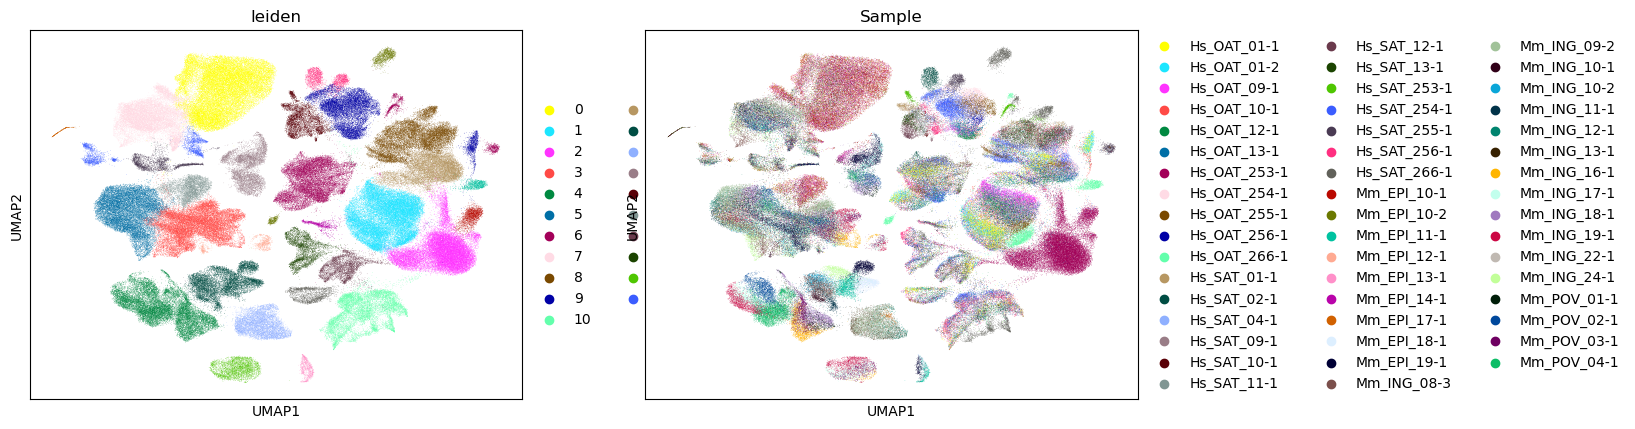

In [8]:
sc.pl.umap(adata, color= ['leiden', 'Sample'])

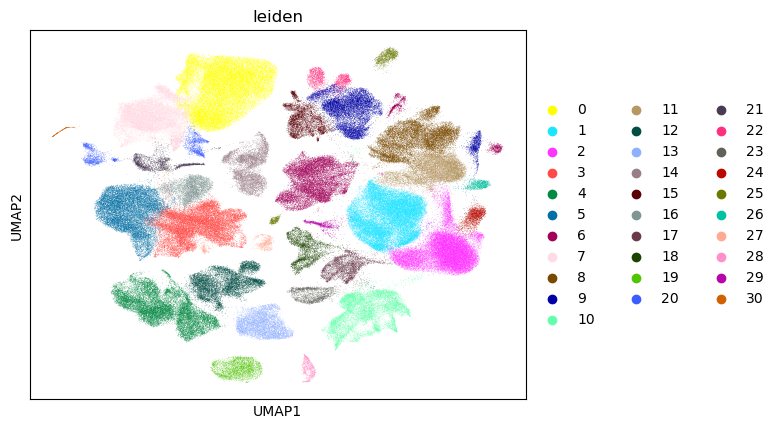

In [9]:
sc.pl.umap(adata, color= ['leiden'])

## 4. Finding Macrophage Celltype

In order to do that we perform differential gene expression analysis using the leiden clusters as groups. 

The `rank_genes_groups` function identifies genes that are differentially expressed between clusters. This can help in identifying marker genes for each cluster and understanding the biological differences between them.

In [10]:
sc.tl.rank_genes_groups(adata, 'leiden')

/home/adlunglab/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/adlunglab/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/adlunglab/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_g

After this we need to filter the differential gene expression results to include **only those genes with adjusted p-values less than 0.05 and log fold changes greater than 0.5.** It then creates a UMAP plot with the Leiden clusters colored, providing a visual representation of the clusters and their relationships. This is useful for interpreting which genes are associated with different clusters and understanding cluster identity.

We will perform this manually so we need the cluster numbers on data in order to identify the marker genes which are most expressed in each cluster and assign the cluster to its corresponding cell type. 

In [11]:
markers = sc.get.rank_genes_groups_df(adata, None)

In [12]:
markers = markers[(markers.pvals_adj < 0.05) &(markers.logfoldchanges > 0.5)]
markers

group          names      scores  logfoldchanges     pvals  pvals_adj
0           0         Malat1  597.703430        6.414718  0.000000   0.000000
1           0        Gm20388  378.761200        4.175280  0.000000   0.000000
2           0        Gm20417  374.275940        4.753792  0.000000   0.000000
3           0        Apobec1  346.879059        6.594612  0.000000   0.000000
4           0          Myo1f  312.200928        6.509801  0.000000   0.000000
...       ...            ...         ...             ...       ...        ...
1784732    30  F630206G17Rik    2.068741        2.484314  0.039718   0.049532
1784733    30        Gm28501    2.068607        1.049587  0.039730   0.049546
1784734    30         Prdm10    2.067590        0.748469  0.039826   0.049664
1784735    30          Rab24    2.066774        0.979010  0.039904   0.049758
1784736    30          Rdh10    2.066254        1.192742  0.039954   0.049818

[360511 rows x 6 columns]

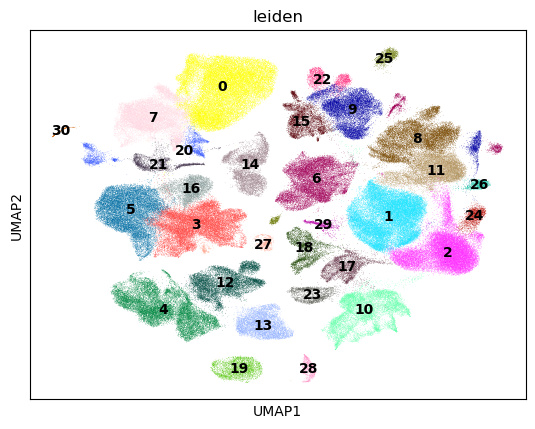

In [13]:
sc.pl.umap(adata, color= ['leiden'], legend_loc= 'on data')

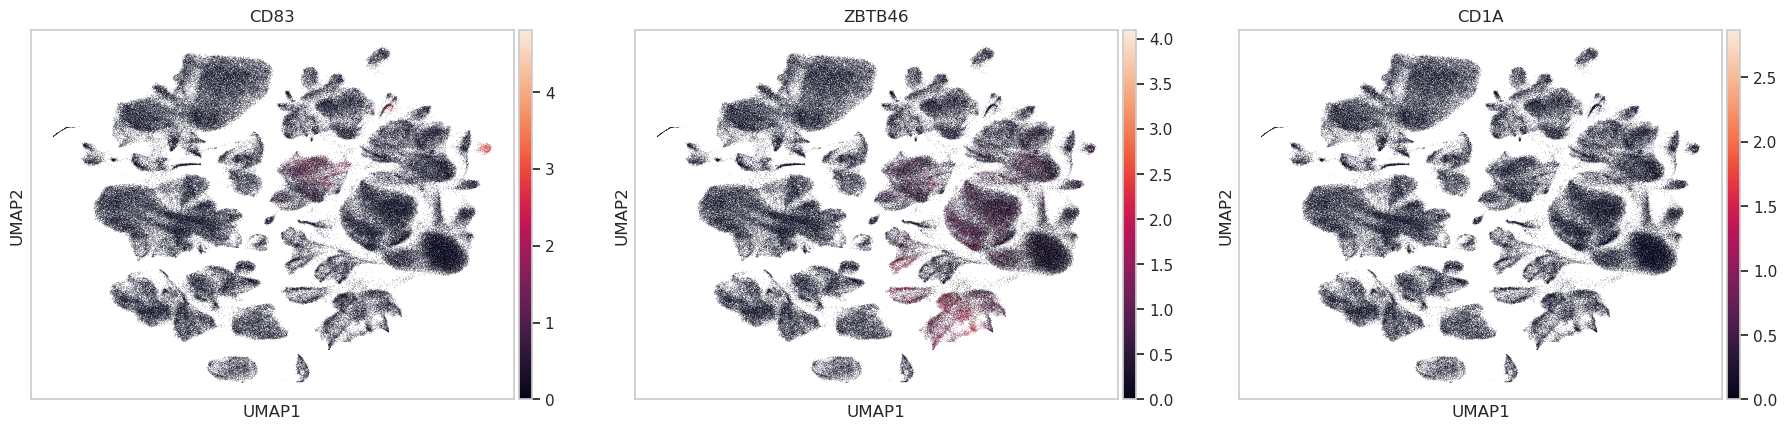

In [274]:
sc.pl.umap(adata, color= ['CD83', 'ZBTB46', 'CD1A'])

In [176]:
cell_type= {
 '0': '',
 '1': 'B_cells',
 '2': '',
 '3': '',
 '4': '',
 '5': '',
 '6': 'Macrophages',
 '7': '',
 '8': '',
 '9': 'Adipocytes',
 '10': '',
 '11': '',
 '12': '',
 '13': '',
 '14': '',
 '15': 'Adipocytes',
 '16': '',
 '17': '',
 '18': '',
 '19': '',
 '20': '',
 '21': '',
 '22': 'Adipocytes',
 '23': '',
 '24': '',
 '25': 'Adipocytes',
 '26': '',
 '27': '',
 '28': '',
 '29': '',
 '30': ''
}

In [ ]:
'CSF1R',   # Colony stimulating factor 1 receptor
    'ADGRE1',  # Also known as F4/80 in mice, EMR1 in humans
    'CD11b',   # Also known as ITGAM
    'MRC1',    # CD206, mannose receptor, M2-like marker
    'MSR1',    # CD204
    'MERTK',   # TAM receptor
    'MARCO',   # Scavenger receptor
    'FCGR1A',  # CD64
    'CD80',    # M1-like marker
    'CD86',

In [273]:
markers[markers.group == '10'].sort_values('logfoldchanges', ascending=False)

group       names     scores  logfoldchanges         pvals  \
605494    10  AL356740.3   5.037315       21.637745  4.793755e-07   
607622    10    LNX1-AS2   3.230280       20.535830  1.240216e-03   
607504    10       LCN10   3.318589       20.400112  9.075853e-04   
608601    10  BX004987.1   2.587448       20.210587  9.681290e-03   
607851    10      LRRC55   3.065402       20.192150  2.178890e-03   
...      ...         ...        ...             ...           ...   
607193    10         MVD   3.552024        0.501081  3.837435e-04   
608194    10     SLC22A1   2.840417        0.501073  4.513048e-03   
601408    10       GATA6  10.137436        0.500543  4.691134e-24   
604518    10       MSRB2   6.052956        0.500294  1.464516e-09   
601611    10     TBC1D16   9.839750        0.500106  9.243168e-23   

           pvals_adj  
605494  7.767957e-07  
607622  1.759055e-03  
607504  1.297047e-03  
608601  1.297860e-02  
607851  3.049120e-03  
...              ...  
607193  5.585035e-04  
608194  6.194845e-03  
601408  9.898928e-24  
604518  2.525061e-09  
601611  1.924563e-22  

[15285 rows x 6 columns]

In [39]:
gene_name = 'TREM2'
gene_row = markers[markers['names'] == gene_name]
gene_row

group  names     scores  logfoldchanges         pvals     pvals_adj
72954       1  TREM2   9.663932        1.211846  4.638285e-22  8.127512e-22
122360      2  TREM2   7.977318        1.325529  1.561963e-15  3.360731e-15
362595      6  TREM2  17.732227        2.453558  1.065007e-69  2.624784e-69
607803     10  TREM2   3.099466        0.598983  1.943189e-03  2.727517e-03
664313     11  TREM2   6.239407        1.195683  4.550339e-10  7.954614e-10
1019028    17  TREM2   3.048851        0.970788  2.310976e-03  3.377996e-03

In [14]:
adata.obs['cell_type'] = adata.obs['leiden'].map({
 '6': 'Macrophages',
 '9': 'Adipocytes',
 '15': 'Adipocytes',
 '22': 'Adipocytes',
 '25': 'Adipocytes',
}).astype('category')

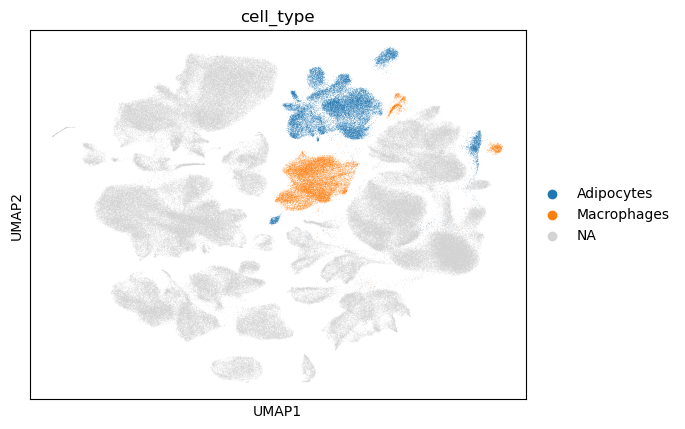

In [15]:
sc.pl.umap(adata, color=['cell_type'])

Creating a subset of macrophages to focus on the analysis of lipid-associated macrophages (LAM)

In [42]:
macrophages = adata[adata.obs['cell_type'] == 'Macrophages'].copy()
macrophages

AnnData object with n_obs × n_vars = 15796 × 59337
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_counts', 'doublet', 'doublet_score', 'batch', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors', 'rank_genes_groups', 'cell_type_colors'
    obsm: 'X_scVI', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [43]:
macrophages.write_h5ad('macrophages_subset.h5ad')

In [ ]:
adata1.write_h5ad('annotated.h5ad')

---

In [5]:
adata = sc.read_h5ad('trained_integrated.h5ad')
adata

AnnData object with n_obs × n_vars = 272623 × 59337
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_counts', 'doublet', 'doublet_score', 'batch', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p'
    obsm: 'X_scVI', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'

## 5. Analysis

In [44]:
macrophages.obs

Sample  n_genes  n_genes_by_counts  \
AAAGGATCACAAAGCG  Hs_SAT_10-1      678                678   
AAAGGTACAGCTCCTT  Hs_SAT_10-1     1551               1551   
AATGCCAAGAGGGTAA  Hs_SAT_10-1     2030               2030   
AATGCCACAAGGAGTC  Hs_SAT_10-1     1552               1552   
ACCCTTGCAATCACGT  Hs_SAT_10-1     1121               1121   
...                       ...      ...                ...   
TTGTGGATCACCTGGG  Hs_SAT_04-1      951                951   
TTGTGTTGTTTACGAC  Hs_SAT_04-1     1891               1891   
TTGTTCAGTCCGGTCA  Hs_SAT_04-1      906                906   
TTGTTGTGTCAGATTC  Hs_SAT_04-1      601                601   
TTTATGCCATACGCAT  Hs_SAT_04-1     1488               1488   

                  log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAAGGATCACAAAGCG                 6.520621           897            6.800170   
AAAGGTACAGCTCCTT                 7.347300          3075            8.031385   
AATGCCAAGAGGGTAA                 7.616284          4111            8.321665   
AATGCCACAAGGAGTC                 7.347944          3046            8.021913   
ACCCTTGCAATCACGT                 7.022868          1981            7.591862   
...                                   ...           ...                 ...   
TTGTGGATCACCTGGG                 6.858565          1280            7.155396   
TTGTGTTGTTTACGAC                 7.545390          3445            8.144969   
TTGTTCAGTCCGGTCA                 6.810142          1314            7.181592   
TTGTTGTGTCAGATTC                 6.400257           680            6.523562   
TTTATGCCATACGCAT                 7.305860          2462            7.809135   

                  pct_counts_in_top_20_genes  pct_counts_mt  pct_counts_ribo  \
AAAGGATCACAAAGCG                   13.043478       0.000000         0.668896   
AAAGGTACAGCTCCTT                   22.731707       0.032520         0.390244   
AATGCCAAGAGGGTAA                   12.113841       0.024325         0.194600   
AATGCCACAAGGAGTC                   14.871963       0.032830         0.262640   
ACCCTTGCAATCACGT                   22.311964       0.050480         0.252398   
...                                      ...            ...              ...   
TTGTGGATCACCTGGG                    9.765625       2.265625         0.546875   
TTGTGTTGTTTACGAC                    8.998549       0.087083         0.348331   
TTGTTCAGTCCGGTCA                   15.829528       0.000000         0.228311   
TTGTTGTGTCAGATTC                    8.235294       0.882353         1.176471   
TTTATGCCATACGCAT                   10.926076       0.081235         0.203087   

                  pct_counts_hb  n_counts  doublet  doublet_score batch  \
AAAGGATCACAAAGCG       0.000000       897      0.0       1.110776     0   
AAAGGTACAGCTCCTT       0.000000      3075      0.0       1.720703     0   
AATGCCAAGAGGGTAA       0.000000      4111      0.0       1.600338     0   
AATGCCACAAGGAGTC       0.000000      3046      0.0       1.720703     0   
ACCCTTGCAATCACGT       0.050480      1981      0.0       1.720703     0   
...                         ...       ...      ...            ...   ...   
TTGTGGATCACCTGGG       0.312500      1280      0.0       0.405585     3   
TTGTGTTGTTTACGAC       0.029028      3445      0.0       1.115595     3   
TTGTTCAGTCCGGTCA       0.000000      1314      0.0       0.002802     3   
TTGTTGTGTCAGATTC       0.000000       680      0.0       0.039087     3   
TTTATGCCATACGCAT       0.000000      2462      0.0       0.541133     3   

                  _scvi_batch  _scvi_labels leiden    cell_type  
AAAGGATCACAAAGCG            0             0      6  Macrophages  
AAAGGTACAGCTCCTT            0             0      6  Macrophages  
AATGCCAAGAGGGTAA            0             0      6  Macrophages  
AATGCCACAAGGAGTC            0             0      6  Macrophages  
ACCCTTGCAATCACGT            0             0      6  Macrophages  
...                       ...           ...    ...          ...  
TTGTGGATCACCTGGG 

### Adding metadata

We have our metadata in yaml files for each sample. We need to collect them, combine them, extract the values out of each dictionary and assign each one to their sample in our Anndata object. 

The Anndata contain both mouse and human samples. The irrelevant columns in metadata will be assigned NaN to deal with them later without causing dependencies problems

In [4]:
sample_names = adata.obs.Sample.unique().tolist()

In [5]:
import yaml

metadata_dir = 'metadata'

metadata_list = []

# traverse through each subfolder in the metadata directory
for sample_folder in os.listdir(metadata_dir):
    sample_path = os.path.join(metadata_dir, sample_folder)
    
    # Check if the path is a directory
    if os.path.isdir(sample_path):
        yaml_file_path = os.path.join(sample_path, 'metadata.yaml')
        
        # Check if the metadata.yaml file exists
        if os.path.isfile(yaml_file_path):
            with open(yaml_file_path, 'r') as file:
                metadata = yaml.safe_load(file)  # load the YAML data
            
            
            # Append the metadata dictionary to the list
            metadata_list.append(metadata)

# Convert the list of dictionaries to a DataFrame
metadata_df = pd.DataFrame(metadata_list)
metadata_df.head()

name         biosample_id           biosample_type  \
0  Hs_SAT_SVF_249-2A-1  Hs_SAT_SVF_249-2A-1  PrimaryBioSample_Tissue   
1  Hs_SAT_SVF_236-2A-2  Hs_SAT_SVF_236-2A-2  PrimaryBioSample_Tissue   
2          Mm_ING_16-1          Mm_ING_16-1  PrimaryBioSample_Tissue   
3          Mm_EPI_11-1          Mm_EPI_11-1  PrimaryBioSample_Tissue   
4  Hs_SAT_SVF_249-1A-1  Hs_SAT_SVF_249-1A-1  PrimaryBioSample_Tissue   

                        library_preparation_protocol donor_id  \
0  {'.': 'EFO:0008722', 'ontology_label': 'Drop-s...   EPI249   
1  {'.': 'EFO:0008722', 'ontology_label': 'Drop-s...   EPI236   
2  {'.': 'EFO:0009922', 'ontology_label': '10x 3'...  HFD06.F   
3  {'.': 'EFO:0009922', 'ontology_label': '10x 3'...    NCD06   
4  {'.': 'EFO:0008722', 'ontology_label': 'Drop-s...   EPI249   

                                             species  \
0  {'.': 'NCBITaxon:9606', 'ontology_label': 'Hom...   
1  {'.': 'NCBITaxon:9606', 'ontology_label': 'Hom...   
2  {'.': 'NCBITaxon:10090', 'ontology_label': 'Mu...   
3  {'.': 'NCBITaxon:10090', 'ontology_label': 'Mu...   
4  {'.': 'NCBITaxon:9606', 'ontology_label': 'Hom...   

                                               organ  \
0  {'.': 'UBERON:0001013', 'ontology_label': 'adi...   
1  {'.': 'UBERON:0001013', 'ontology_label': 'adi...   
2  {'.': 'UBERON:0001013', 'ontology_label': 'adi...   
3  {'.': 'UBERON:0001013', 'ontology_label': 'adi...   
4  {'.': 'UBERON:0001013', 'ontology_label': 'adi...   

                                              tissue  \
0  {'.': 'UBERON:0001347', 'ontology_label': 'whi...   
1  {'.': 'UBERON:0001347', 'ontology_label': 'whi...   
2  {'.': 'UBERON:0001347', 'ontology_label': 'whi...   
3  {'.': 'UBERON:0001347', 'ontology_label': 'whi...   
4  {'.': 'UBERON:0001347', 'ontology_label': 'whi...   

                                               depot  \
0  {'.': 'UBERON:0002190', 'ontology_label': 'sub...   
1  {'.': 'UBERON:0002190', 'ontology_label': 'sub...   
2  {'.': 'UBERON:0010410', 'ontology_label': 'ing...   
3  {'.': 'UBERON:0010412', 'ontology_label': 'epi...   
4  {'.': 'UBERON:0002190', 'ontology_label': 'sub...   

                                                 sex  \
0  {'.': 'PATO:0000383', 'ontology_label': 'female'}   
1  {'.': 'PATO:0000383', 'ontology_label': 'female'}   
2  {'.': 'PATO:0000383', 'ontology_label': 'female'}   
3    {'.': 'PATO:0000384', 'ontology_label': 'male'}   
4  {'.': 'PATO:0000383', 'ontology_label': 'female'}   

                                              race  \
0  {'.': 'NCIT:C41261', 'ontology_label': 'White'}   
1  {'.': 'NCIT:C41261', 'ontology_label': 'White'}   
2                                              NaN   
3                                              NaN   
4  {'.': 'NCIT:C41261', 'ontology_label': 'White'}   

                                           ethnicity  \
0  {'.': 'HANCESTRO:0005', 'ontology_label': 'Eur...   
1  {'.': 'HANCESTRO:0005', 'ontology_label': 'Eur...   
2                                                NaN   
3                                                NaN   
4  {'.': 'HANCESTRO:0005', 'ontology_label': 'Eur...   

                                   development_stage  \
0  {'.': 'HsapDv:0000148', 'ontology_label': '54-...   
1  {'.': 'HsapDv:0000129', 'ontology_label': '35-...   
2  {'.': 'MmusDv:0000070', 'ontology_label': '20 ...   
3  {'.': 'MmusDv:0000070', 'ontology_label': '20 ...   
4  {'.': 'HsapDv:0000148', 'ontology_label': '54-...   

                                        organism_age  \
0  {'.': 54, 'group': '50-60', 'unit': {'.': 'UO:...   
1  {'.': 35, 'group': '30-40', 'unit': {'.': 'UO:...   
2  {'.': 20, 'unit': {'.': 'UO:0000034', 'ontolog...   
3  {'.': 20, 'unit': {'.': 'UO:0000034', 'ontolog...   
4  {'.': 54, 'group': '50-60', 'unit': {'.': 'UO:...   

                                             disease  \
0  {'.': ['MONDO:0004992'], 'ontology_label': ['c...   
1  {'.': ['PATO:0000461'], 'ontology_label': ['no...   
2  {'

In [6]:
metadata_df = metadata_df.set_index('name')
metadata_df.head(3)

biosample_id           biosample_type  \
name                                                                
Hs_SAT_SVF_249-2A-1  Hs_SAT_SVF_249-2A-1  PrimaryBioSample_Tissue   
Hs_SAT_SVF_236-2A-2  Hs_SAT_SVF_236-2A-2  PrimaryBioSample_Tissue   
Mm_ING_16-1                  Mm_ING_16-1  PrimaryBioSample_Tissue   

                                          library_preparation_protocol  \
name                                                                     
Hs_SAT_SVF_249-2A-1  {'.': 'EFO:0008722', 'ontology_label': 'Drop-s...   
Hs_SAT_SVF_236-2A-2  {'.': 'EFO:0008722', 'ontology_label': 'Drop-s...   
Mm_ING_16-1          {'.': 'EFO:0009922', 'ontology_label': '10x 3'...   

                    donor_id  \
name                           
Hs_SAT_SVF_249-2A-1   EPI249   
Hs_SAT_SVF_236-2A-2   EPI236   
Mm_ING_16-1          HFD06.F   

                                                               species  \
name                                                                     
Hs_SAT_SVF_249-2A-1  {'.': 'NCBITaxon:9606', 'ontology_label': 'Hom...   
Hs_SAT_SVF_236-2A-2  {'.': 'NCBITaxon:9606', 'ontology_label': 'Hom...   
Mm_ING_16-1          {'.': 'NCBITaxon:10090', 'ontology_label': 'Mu...   

                                                                 organ  \
name                                                                     
Hs_SAT_SVF_249-2A-1  {'.': 'UBERON:0001013', 'ontology_label': 'adi...   
Hs_SAT_SVF_236-2A-2  {'.': 'UBERON:0001013', 'ontology_label': 'adi...   
Mm_ING_16-1          {'.': 'UBERON:0001013', 'ontology_label': 'adi...   

                                                                tissue  \
name                                                                     
Hs_SAT_SVF_249-2A-1  {'.': 'UBERON:0001347', 'ontology_label': 'whi...   
Hs_SAT_SVF_236-2A-2  {'.': 'UBERON:0001347', 'ontology_label': 'whi...   
Mm_ING_16-1          {'.': 'UBERON:0001347', 'ontology_label': 'whi...   

                                                                 depot  \
name                                                                     
Hs_SAT_SVF_249-2A-1  {'.': 'UBERON:0002190', 'ontology_label': 'sub...   
Hs_SAT_SVF_236-2A-2  {'.': 'UBERON:0002190', 'ontology_label': 'sub...   
Mm_ING_16-1          {'.': 'UBERON:0010410', 'ontology_label': 'ing...   

                                                                   sex  \
name                                                                     
Hs_SAT_SVF_249-2A-1  {'.': 'PATO:0000383', 'ontology_label': 'female'}   
Hs_SAT_SVF_236-2A-2  {'.': 'PATO:0000383', 'ontology_label': 'female'}   
Mm_ING_16-1          {'.': 'PATO:0000383', 'ontology_label': 'female'}   

                                                                race  \
name                                                                   
Hs_SAT_SVF_249-2A-1  {'.': 'NCIT:C41261', 'ontology_label': 'White'}   
Hs_SAT_SVF_236-2A-2  {'.': 'NCIT:C41261', 'ontology_label': 'White'}   
Mm_ING_16-1                                                      NaN   

                                                             ethnicity  \
name                                                                     
Hs_SAT_SVF_249-2A-1  {'.': 'HANCESTRO:0005', 'ontology_label': 'Eur...   
Hs_SAT_SVF_236-2A-2  {'.': 'HANCESTRO:0005', 'ontology_label': 'Eur...   
Mm_ING_16-1                                                        NaN   

                                                     development_stage  \
name                                                                     
Hs_SAT_SVF_249-2A-1  {'.': 'HsapDv:0000148', 'ontology_label': '54-...   
Hs_SAT_SVF_236-2A-2  {'.': 'HsapDv:0000129', 'ontology_label': '35-...   
Mm_ING_16-1          {'.': 'MmusDv:0000070', 'ontology_label': '20 ...   

                                                          organism_age  \
name                                                                     
Hs_SAT_SVF_249-2A-1  {'.': 54, 'group': '50-

In [7]:
columns_to_clean = ['species', 'library_preparation_protocol', 'organ', 'tissue', 'depot', 'sex', 'race', 'ethnicity', 'development_stage', 'disease', 'mouse_strain']

for column in columns_to_clean:
    metadata_df[column] = metadata_df[column].apply(lambda x: x['ontology_label'] if isinstance(x, dict) and 'ontology_label' in x else x)

metadata_df.head(3)

biosample_id           biosample_type  \
name                                                                
Hs_SAT_SVF_249-2A-1  Hs_SAT_SVF_249-2A-1  PrimaryBioSample_Tissue   
Hs_SAT_SVF_236-2A-2  Hs_SAT_SVF_236-2A-2  PrimaryBioSample_Tissue   
Mm_ING_16-1                  Mm_ING_16-1  PrimaryBioSample_Tissue   

                    library_preparation_protocol donor_id       species  \
name                                                                      
Hs_SAT_SVF_249-2A-1                     Drop-seq   EPI249  Homo sapiens   
Hs_SAT_SVF_236-2A-2                     Drop-seq   EPI236  Homo sapiens   
Mm_ING_16-1                 10x 3' v3 sequencing  HFD06.F  Mus musculus   

                              organ                tissue  \
name                                                        
Hs_SAT_SVF_249-2A-1  adipose tissue  white adipose tissue   
Hs_SAT_SVF_236-2A-2  adipose tissue  white adipose tissue   
Mm_ING_16-1          adipose tissue  white adipose tissue   

                                           depot     sex   race ethnicity  \
name                                                                        
Hs_SAT_SVF_249-2A-1  subcutaneous adipose tissue  female  White  European   
Hs_SAT_SVF_236-2A-2  subcutaneous adipose tissue  female  White  European   
Mm_ING_16-1                     inguinal fat pad  female    NaN       NaN   

                           development_stage  \
name                                           
Hs_SAT_SVF_249-2A-1  54-year-old human stage   
Hs_SAT_SVF_236-2A-2  35-year-old human stage   
Mm_ING_16-1                         20 weeks   

                                                          organism_age  \
name                                                                     
Hs_SAT_SVF_249-2A-1  {'.': 54, 'group': '50-60', 'unit': {'.': 'UO:...   
Hs_SAT_SVF_236-2A-2  {'.': 35, 'group': '30-40', 'unit': {'.': 'UO:...   
Mm_ING_16-1          {'.': 20, 'unit': {'.': 'UO:0000034', 'ontolog...   

                      disease  \
name                            
Hs_SAT_SVF_249-2A-1  [cancer]   
Hs_SAT_SVF_236-2A-2  [normal]   
Mm_ING_16-1          [normal]   

                                                                   bmi  \
name                                                                     
Hs_SAT_SVF_249-2A-1  {'.': 26.46, 'group': '20-30', 'unit': {'.': '...   
Hs_SAT_SVF_236-2A-2  {'.': 25.74, 'group': '20-30', 'unit': {'.': '...   
Mm_ING_16-1                                                        NaN   

                      mouse_strain  \
name                                 
Hs_SAT_SVF_249-2A-1            NaN   
Hs_SAT_SVF_236-2A-2            NaN   
Mm_ING_16-1          C57BL/6 Mouse   

                                                       organism_weight  \
name                                                                     
Hs_SAT_SVF_249-2A-1                                                NaN   
Hs_SAT_SVF_236-2A-2                                                NaN   
Mm_ING_16-1          {'.': 30.23, 'unit': {'.': 'UO:0000021', 'onto...   

                                                                  diet  
name                                                                    
Hs_SAT_SVF_249-2A-1                                                NaN  
Hs_SAT_SVF_236-2A-2                                                NaN  
Mm_ING_16-1          {'type': 'high fat diet', 'schedule': 'ad libi...

In [8]:
metadata_df.drop(['biosample_id'], axis= 1, inplace=True)
metadata_df.head(3)

biosample_type library_preparation_protocol  \
name                                                                        
Hs_SAT_SVF_249-2A-1  PrimaryBioSample_Tissue                     Drop-seq   
Hs_SAT_SVF_236-2A-2  PrimaryBioSample_Tissue                     Drop-seq   
Mm_ING_16-1          PrimaryBioSample_Tissue         10x 3' v3 sequencing   

                    donor_id       species           organ  \
name                                                         
Hs_SAT_SVF_249-2A-1   EPI249  Homo sapiens  adipose tissue   
Hs_SAT_SVF_236-2A-2   EPI236  Homo sapiens  adipose tissue   
Mm_ING_16-1          HFD06.F  Mus musculus  adipose tissue   

                                   tissue                        depot  \
name                                                                     
Hs_SAT_SVF_249-2A-1  white adipose tissue  subcutaneous adipose tissue   
Hs_SAT_SVF_236-2A-2  white adipose tissue  subcutaneous adipose tissue   
Mm_ING_16-1          white adipose tissue             inguinal fat pad   

                        sex   race ethnicity        development_stage  \
name                                                                    
Hs_SAT_SVF_249-2A-1  female  White  European  54-year-old human stage   
Hs_SAT_SVF_236-2A-2  female  White  European  35-year-old human stage   
Mm_ING_16-1          female    NaN       NaN                 20 weeks   

                                                          organism_age  \
name                                                                     
Hs_SAT_SVF_249-2A-1  {'.': 54, 'group': '50-60', 'unit': {'.': 'UO:...   
Hs_SAT_SVF_236-2A-2  {'.': 35, 'group': '30-40', 'unit': {'.': 'UO:...   
Mm_ING_16-1          {'.': 20, 'unit': {'.': 'UO:0000034', 'ontolog...   

                      disease  \
name                            
Hs_SAT_SVF_249-2A-1  [cancer]   
Hs_SAT_SVF_236-2A-2  [normal]   
Mm_ING_16-1          [normal]   

                                                                   bmi  \
name                                                                     
Hs_SAT_SVF_249-2A-1  {'.': 26.46, 'group': '20-30', 'unit': {'.': '...   
Hs_SAT_SVF_236-2A-2  {'.': 25.74, 'group': '20-30', 'unit': {'.': '...   
Mm_ING_16-1                                                        NaN   

                      mouse_strain  \
name                                 
Hs_SAT_SVF_249-2A-1            NaN   
Hs_SAT_SVF_236-2A-2            NaN   
Mm_ING_16-1          C57BL/6 Mouse   

                                                       organism_weight  \
name                                                                     
Hs_SAT_SVF_249-2A-1                                                NaN   
Hs_SAT_SVF_236-2A-2                                                NaN   
Mm_ING_16-1          {'.': 30.23, 'unit': {'.': 'UO:0000021', 'onto...   

                                                                  diet  
name                                                                    
Hs_SAT_SVF_249-2A-1                                                NaN  
Hs_SAT_SVF_236-2A-2                                                NaN  
Mm_ING_16-1          {'type': 'high fat diet', 'schedule': 'ad libi...

In [9]:
metadata_df['bmi_value'] = metadata_df['bmi'].apply(lambda x: x['.'] if isinstance(x, dict) and '.' in x else None)
metadata_df['bmi_group'] = metadata_df['bmi'].apply(lambda x: x['group'] if isinstance(x, dict) and 'group' in x else None)
metadata_df.drop('bmi', axis=1, inplace=True)

metadata_df.head(3)

biosample_type library_preparation_protocol  \
name                                                                        
Hs_SAT_SVF_249-2A-1  PrimaryBioSample_Tissue                     Drop-seq   
Hs_SAT_SVF_236-2A-2  PrimaryBioSample_Tissue                     Drop-seq   
Mm_ING_16-1          PrimaryBioSample_Tissue         10x 3' v3 sequencing   

                    donor_id       species           organ  \
name                                                         
Hs_SAT_SVF_249-2A-1   EPI249  Homo sapiens  adipose tissue   
Hs_SAT_SVF_236-2A-2   EPI236  Homo sapiens  adipose tissue   
Mm_ING_16-1          HFD06.F  Mus musculus  adipose tissue   

                                   tissue                        depot  \
name                                                                     
Hs_SAT_SVF_249-2A-1  white adipose tissue  subcutaneous adipose tissue   
Hs_SAT_SVF_236-2A-2  white adipose tissue  subcutaneous adipose tissue   
Mm_ING_16-1          white adipose tissue             inguinal fat pad   

                        sex   race ethnicity        development_stage  \
name                                                                    
Hs_SAT_SVF_249-2A-1  female  White  European  54-year-old human stage   
Hs_SAT_SVF_236-2A-2  female  White  European  35-year-old human stage   
Mm_ING_16-1          female    NaN       NaN                 20 weeks   

                                                          organism_age  \
name                                                                     
Hs_SAT_SVF_249-2A-1  {'.': 54, 'group': '50-60', 'unit': {'.': 'UO:...   
Hs_SAT_SVF_236-2A-2  {'.': 35, 'group': '30-40', 'unit': {'.': 'UO:...   
Mm_ING_16-1          {'.': 20, 'unit': {'.': 'UO:0000034', 'ontolog...   

                      disease   mouse_strain  \
name                                           
Hs_SAT_SVF_249-2A-1  [cancer]            NaN   
Hs_SAT_SVF_236-2A-2  [normal]            NaN   
Mm_ING_16-1          [normal]  C57BL/6 Mouse   

                                                       organism_weight  \
name                                                                     
Hs_SAT_SVF_249-2A-1                                                NaN   
Hs_SAT_SVF_236-2A-2                                                NaN   
Mm_ING_16-1          {'.': 30.23, 'unit': {'.': 'UO:0000021', 'onto...   

                                                                  diet  \
name                                                                     
Hs_SAT_SVF_249-2A-1                                                NaN   
Hs_SAT_SVF_236-2A-2                                                NaN   
Mm_ING_16-1          {'type': 'high fat diet', 'schedule': 'ad libi...   

                     bmi_value bmi_group  
name                                      
Hs_SAT_SVF_249-2A-1      26.46     20-30  
Hs_SAT_SVF_236-2A-2      25.74     20-30  
Mm_ING_16-1                NaN      None

In [10]:
metadata_df['organism_age'] = metadata_df['organism_age'].apply(lambda x: x['.'] if isinstance(x, dict) and '.' in x else None)

metadata_df.head(3)

biosample_type library_preparation_protocol  \
name                                                                        
Hs_SAT_SVF_249-2A-1  PrimaryBioSample_Tissue                     Drop-seq   
Hs_SAT_SVF_236-2A-2  PrimaryBioSample_Tissue                     Drop-seq   
Mm_ING_16-1          PrimaryBioSample_Tissue         10x 3' v3 sequencing   

                    donor_id       species           organ  \
name                                                         
Hs_SAT_SVF_249-2A-1   EPI249  Homo sapiens  adipose tissue   
Hs_SAT_SVF_236-2A-2   EPI236  Homo sapiens  adipose tissue   
Mm_ING_16-1          HFD06.F  Mus musculus  adipose tissue   

                                   tissue                        depot  \
name                                                                     
Hs_SAT_SVF_249-2A-1  white adipose tissue  subcutaneous adipose tissue   
Hs_SAT_SVF_236-2A-2  white adipose tissue  subcutaneous adipose tissue   
Mm_ING_16-1          white adipose tissue             inguinal fat pad   

                        sex   race ethnicity        development_stage  \
name                                                                    
Hs_SAT_SVF_249-2A-1  female  White  European  54-year-old human stage   
Hs_SAT_SVF_236-2A-2  female  White  European  35-year-old human stage   
Mm_ING_16-1          female    NaN       NaN                 20 weeks   

                     organism_age   disease   mouse_strain  \
name                                                         
Hs_SAT_SVF_249-2A-1            54  [cancer]            NaN   
Hs_SAT_SVF_236-2A-2            35  [normal]            NaN   
Mm_ING_16-1                    20  [normal]  C57BL/6 Mouse   

                                                       organism_weight  \
name                                                                     
Hs_SAT_SVF_249-2A-1                                                NaN   
Hs_SAT_SVF_236-2A-2                                                NaN   
Mm_ING_16-1          {'.': 30.23, 'unit': {'.': 'UO:0000021', 'onto...   

                                                                  diet  \
name                                                                     
Hs_SAT_SVF_249-2A-1                                                NaN   
Hs_SAT_SVF_236-2A-2                                                NaN   
Mm_ING_16-1          {'type': 'high fat diet', 'schedule': 'ad libi...   

                     bmi_value bmi_group  
name                                      
Hs_SAT_SVF_249-2A-1      26.46     20-30  
Hs_SAT_SVF_236-2A-2      25.74     20-30  
Mm_ING_16-1                NaN      None

In [11]:
metadata_df['disease'] = metadata_df['disease'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
metadata_df.head(3)

biosample_type library_preparation_protocol  \
name                                                                        
Hs_SAT_SVF_249-2A-1  PrimaryBioSample_Tissue                     Drop-seq   
Hs_SAT_SVF_236-2A-2  PrimaryBioSample_Tissue                     Drop-seq   
Mm_ING_16-1          PrimaryBioSample_Tissue         10x 3' v3 sequencing   

                    donor_id       species           organ  \
name                                                         
Hs_SAT_SVF_249-2A-1   EPI249  Homo sapiens  adipose tissue   
Hs_SAT_SVF_236-2A-2   EPI236  Homo sapiens  adipose tissue   
Mm_ING_16-1          HFD06.F  Mus musculus  adipose tissue   

                                   tissue                        depot  \
name                                                                     
Hs_SAT_SVF_249-2A-1  white adipose tissue  subcutaneous adipose tissue   
Hs_SAT_SVF_236-2A-2  white adipose tissue  subcutaneous adipose tissue   
Mm_ING_16-1          white adipose tissue             inguinal fat pad   

                        sex   race ethnicity        development_stage  \
name                                                                    
Hs_SAT_SVF_249-2A-1  female  White  European  54-year-old human stage   
Hs_SAT_SVF_236-2A-2  female  White  European  35-year-old human stage   
Mm_ING_16-1          female    NaN       NaN                 20 weeks   

                     organism_age disease   mouse_strain  \
name                                                       
Hs_SAT_SVF_249-2A-1            54  cancer            NaN   
Hs_SAT_SVF_236-2A-2            35  normal            NaN   
Mm_ING_16-1                    20  normal  C57BL/6 Mouse   

                                                       organism_weight  \
name                                                                     
Hs_SAT_SVF_249-2A-1                                                NaN   
Hs_SAT_SVF_236-2A-2                                                NaN   
Mm_ING_16-1          {'.': 30.23, 'unit': {'.': 'UO:0000021', 'onto...   

                                                                  diet  \
name                                                                     
Hs_SAT_SVF_249-2A-1                                                NaN   
Hs_SAT_SVF_236-2A-2                                                NaN   
Mm_ING_16-1          {'type': 'high fat diet', 'schedule': 'ad libi...   

                     bmi_value bmi_group  
name                                      
Hs_SAT_SVF_249-2A-1      26.46     20-30  
Hs_SAT_SVF_236-2A-2      25.74     20-30  
Mm_ING_16-1                NaN      None

In [12]:
metadata_df['diet'][2]

{'type': 'high fat diet', 'schedule': 'ad libitum'}

In [13]:
# Extract 'type' and 'schedule' from the dictionaries in the 'diet' column
metadata_df['diet_type'] = metadata_df['diet'].apply(lambda x: x.get('type') if isinstance(x, dict) else None)
metadata_df['diet_schedule'] = metadata_df['diet'].apply(lambda x: x.get('schedule') if isinstance(x, dict) else None)

metadata_df = metadata_df.drop(columns=['diet'])

metadata_df.head(3)

biosample_type library_preparation_protocol  \
name                                                                        
Hs_SAT_SVF_249-2A-1  PrimaryBioSample_Tissue                     Drop-seq   
Hs_SAT_SVF_236-2A-2  PrimaryBioSample_Tissue                     Drop-seq   
Mm_ING_16-1          PrimaryBioSample_Tissue         10x 3' v3 sequencing   

                    donor_id       species           organ  \
name                                                         
Hs_SAT_SVF_249-2A-1   EPI249  Homo sapiens  adipose tissue   
Hs_SAT_SVF_236-2A-2   EPI236  Homo sapiens  adipose tissue   
Mm_ING_16-1          HFD06.F  Mus musculus  adipose tissue   

                                   tissue                        depot  \
name                                                                     
Hs_SAT_SVF_249-2A-1  white adipose tissue  subcutaneous adipose tissue   
Hs_SAT_SVF_236-2A-2  white adipose tissue  subcutaneous adipose tissue   
Mm_ING_16-1          white adipose tissue             inguinal fat pad   

                        sex   race ethnicity        development_stage  \
name                                                                    
Hs_SAT_SVF_249-2A-1  female  White  European  54-year-old human stage   
Hs_SAT_SVF_236-2A-2  female  White  European  35-year-old human stage   
Mm_ING_16-1          female    NaN       NaN                 20 weeks   

                     organism_age disease   mouse_strain  \
name                                                       
Hs_SAT_SVF_249-2A-1            54  cancer            NaN   
Hs_SAT_SVF_236-2A-2            35  normal            NaN   
Mm_ING_16-1                    20  normal  C57BL/6 Mouse   

                                                       organism_weight  \
name                                                                     
Hs_SAT_SVF_249-2A-1                                                NaN   
Hs_SAT_SVF_236-2A-2                                                NaN   
Mm_ING_16-1          {'.': 30.23, 'unit': {'.': 'UO:0000021', 'onto...   

                     bmi_value bmi_group      diet_type diet_schedule  
name                                                                   
Hs_SAT_SVF_249-2A-1      26.46     20-30           None          None  
Hs_SAT_SVF_236-2A-2      25.74     20-30           None          None  
Mm_ING_16-1                NaN      None  high fat diet    ad libitum

In [14]:
metadata_df['organism_weight'] = metadata_df['organism_weight'].apply(lambda x: x.get('.') if isinstance(x, dict) else None)
metadata_df.head(3)

biosample_type library_preparation_protocol  \
name                                                                        
Hs_SAT_SVF_249-2A-1  PrimaryBioSample_Tissue                     Drop-seq   
Hs_SAT_SVF_236-2A-2  PrimaryBioSample_Tissue                     Drop-seq   
Mm_ING_16-1          PrimaryBioSample_Tissue         10x 3' v3 sequencing   

                    donor_id       species           organ  \
name                                                         
Hs_SAT_SVF_249-2A-1   EPI249  Homo sapiens  adipose tissue   
Hs_SAT_SVF_236-2A-2   EPI236  Homo sapiens  adipose tissue   
Mm_ING_16-1          HFD06.F  Mus musculus  adipose tissue   

                                   tissue                        depot  \
name                                                                     
Hs_SAT_SVF_249-2A-1  white adipose tissue  subcutaneous adipose tissue   
Hs_SAT_SVF_236-2A-2  white adipose tissue  subcutaneous adipose tissue   
Mm_ING_16-1          white adipose tissue             inguinal fat pad   

                        sex   race ethnicity        development_stage  \
name                                                                    
Hs_SAT_SVF_249-2A-1  female  White  European  54-year-old human stage   
Hs_SAT_SVF_236-2A-2  female  White  European  35-year-old human stage   
Mm_ING_16-1          female    NaN       NaN                 20 weeks   

                     organism_age disease   mouse_strain  organism_weight  \
name                                                                        
Hs_SAT_SVF_249-2A-1            54  cancer            NaN              NaN   
Hs_SAT_SVF_236-2A-2            35  normal            NaN              NaN   
Mm_ING_16-1                    20  normal  C57BL/6 Mouse            30.23   

                     bmi_value bmi_group      diet_type diet_schedule  
name                                                                   
Hs_SAT_SVF_249-2A-1      26.46     20-30           None          None  
Hs_SAT_SVF_236-2A-2      25.74     20-30           None          None  
Mm_ING_16-1                NaN      None  high fat diet    ad libitum

In [15]:
metadata_df['organism_weight'].unique()

array([  nan, 30.23, 33.99, 30.53, 48.02, 23.1 , 48.69, 56.62, 34.87,
       34.53, 33.11, 48.11, 31.81, 24.3 , 46.17])

Finished cleaning and saving the final version 

In [16]:
metadata_df.to_csv('metadata_final.csv', index=True)

---

Now we can create a mapping from sample identifiers to metadata features using `metadata_df.to_dict(orient='index')`. Then, it defines a function `map_sample_to_metadata` to retrieve specific metadata features for a given sample. The code iterates over all columns in the metadata DataFrame and adds each as a new column to the `adata.obs` DataFrame by mapping the sample identifiers to their corresponding metadata values. This ensures that all relevant metadata is added to the AnnData object for further analysis.

In [17]:
sample_to_metadata = metadata_df.to_dict(orient='index')

def map_sample_to_metadata(sample, feature):
    return sample_to_metadata.get(sample, {}).get(feature, None)

# adding metadata columns to adata.obs
for column in metadata_df.columns:
    adata.obs[column] = adata.obs['Sample'].map(lambda x: map_sample_to_metadata(x, column))

In [18]:
adata.obs.head()

Sample  n_genes  n_genes_by_counts  \
GCTACAAAGTAACGAT  Mm_POV_04-1     4671               4671   
TCACATTCATCGAGCC  Mm_POV_04-1     3583               3583   
TTCTAGTCAATAGTCC  Mm_POV_04-1     3933               3933   
TCGACCTGTGGTATGG  Mm_POV_04-1     3695               3695   
ACAAAGACATAGGTTC  Mm_POV_04-1     3477               3477   

                  log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
GCTACAAAGTAACGAT                 8.449343         15691            9.660906   
TCACATTCATCGAGCC                 8.184235         13201            9.488124   
TTCTAGTCAATAGTCC                 8.277412         13118            9.481817   
TCGACCTGTGGTATGG                 8.215006         12109            9.401787   
ACAAAGACATAGGTTC                 8.154213         10739            9.281730   

                  pct_counts_in_top_20_genes  pct_counts_mt  pct_counts_ribo  \
GCTACAAAGTAACGAT                   13.746734            0.0         0.095596   
TCACATTCATCGAGCC                   21.301417            0.0         0.242406   
TTCTAGTCAATAGTCC                   17.228236            0.0         0.266809   
TCGACCTGTGGTATGG                   18.424312            0.0         0.165166   
ACAAAGACATAGGTTC                   16.621659            0.0         0.214173   

                  pct_counts_hb  ...  ethnicity  development_stage  \
GCTACAAAGTAACGAT       0.031865  ...        NaN           20 weeks   
TCACATTCATCGAGCC       0.000000  ...        NaN           20 weeks   
TTCTAGTCAATAGTCC       0.000000  ...        NaN           20 weeks   
TCGACCTGTGGTATGG       0.008258  ...        NaN           20 weeks   
ACAAAGACATAGGTTC       0.009312  ...        NaN           20 weeks   

                  organism_age disease   mouse_strain  organism_weight  \
GCTACAAAGTAACGAT            20  normal  C57BL/6 Mouse             23.1   
TCACATTCATCGAGCC            20  normal  C57BL/6 Mouse             23.1   
TTCTAGTCAATAGTCC            20  normal  C57BL/6 Mouse             23.1   
TCGACCTGTGGTATGG            20  normal  C57BL/6 Mouse             23.1   
ACAAAGACATAGGTTC            20  normal  C57BL/6 Mouse             23.1   

                 bmi_value bmi_group         diet_type diet_schedule  
GCTACAAAGTAACGAT       NaN      None  normal chow diet    ad libitum  
TCACATTCATCGAGCC       NaN      None  normal chow diet    ad libitum  
TTCTAGTCAATAGTCC       NaN      None  normal chow diet    ad libitum  
TCGACCTGTGGTATGG       NaN      None  normal chow diet    ad libitum  
ACAAAGACATAGGTTC       NaN      None  normal chow diet    ad libitum  

[5 rows x 37 columns]

Ensuring that only healthy samples are included in the analysis, as the investigation focuses solely on the healthy condition

In [19]:
adata1 = adata[adata.obs['disease'] != 'cancer', :]
adata1.obs.shape

(272623, 37)

In [75]:
macrophages = macrophages[macrophages.obs['disease'] != 'cancer', :]
macrophages.obs.shape

(15796, 37)

In [77]:
macrophages.obs['bmi_group'].unique()

array(['40-50', '20-30', '30-40'], dtype=object)

In [78]:
macrophages.obs['bmi_group'].value_counts()

bmi_group
40-50    8950
20-30    4510
30-40    2336
Name: count, dtype: int64

---

## Differential Expression

### 1. DE for inflammatory macrophages across BMI groups

We first filter genes in the `macrophages1` dataset to include only those present in at least 100 cells. Then, check which of the specified MME gene markers are present in the dataset. After identifying the relevant markers, the code uses the Wald test from the `diffxpy` package to perform differential expression analysis based on the `bmi_group` factor. This helps identify differences in gene expression related to BMI groups.

In [16]:
import diffxpy.api as de

In [80]:
macrophages1 = macrophages.copy()
macrophages1.shape

(15796, 59337)

In [93]:
macrophages1.obs

Sample  n_genes  n_genes_by_counts  \
AAAGGATCACAAAGCG  Hs_SAT_10-1      678                678   
AAAGGTACAGCTCCTT  Hs_SAT_10-1     1551               1551   
AATGCCAAGAGGGTAA  Hs_SAT_10-1     2030               2030   
AATGCCACAAGGAGTC  Hs_SAT_10-1     1552               1552   
ACCCTTGCAATCACGT  Hs_SAT_10-1     1121               1121   
...                       ...      ...                ...   
TTGTGGATCACCTGGG  Hs_SAT_04-1      951                951   
TTGTGTTGTTTACGAC  Hs_SAT_04-1     1891               1891   
TTGTTCAGTCCGGTCA  Hs_SAT_04-1      906                906   
TTGTTGTGTCAGATTC  Hs_SAT_04-1      601                601   
TTTATGCCATACGCAT  Hs_SAT_04-1     1488               1488   

                  log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAAGGATCACAAAGCG                 6.520621           897            6.800170   
AAAGGTACAGCTCCTT                 7.347300          3075            8.031385   
AATGCCAAGAGGGTAA                 7.616284          4111            8.321665   
AATGCCACAAGGAGTC                 7.347944          3046            8.021913   
ACCCTTGCAATCACGT                 7.022868          1981            7.591862   
...                                   ...           ...                 ...   
TTGTGGATCACCTGGG                 6.858565          1280            7.155396   
TTGTGTTGTTTACGAC                 7.545390          3445            8.144969   
TTGTTCAGTCCGGTCA                 6.810142          1314            7.181592   
TTGTTGTGTCAGATTC                 6.400257           680            6.523562   
TTTATGCCATACGCAT                 7.305860          2462            7.809135   

                  pct_counts_in_top_20_genes  pct_counts_mt  pct_counts_ribo  \
AAAGGATCACAAAGCG                   13.043478       0.000000         0.668896   
AAAGGTACAGCTCCTT                   22.731707       0.032520         0.390244   
AATGCCAAGAGGGTAA                   12.113841       0.024325         0.194600   
AATGCCACAAGGAGTC                   14.871963       0.032830         0.262640   
ACCCTTGCAATCACGT                   22.311964       0.050480         0.252398   
...                                      ...            ...              ...   
TTGTGGATCACCTGGG                    9.765625       2.265625         0.546875   
TTGTGTTGTTTACGAC                    8.998549       0.087083         0.348331   
TTGTTCAGTCCGGTCA                   15.829528       0.000000         0.228311   
TTGTTGTGTCAGATTC                    8.235294       0.882353         1.176471   
TTTATGCCATACGCAT                   10.926076       0.081235         0.203087   

                  pct_counts_hb  ...  ethnicity        development_stage  \
AAAGGATCACAAAGCG       0.000000  ...   European  35-year-old human stage   
AAAGGTACAGCTCCTT       0.000000  ...   European  35-year-old human stage   
AATGCCAAGAGGGTAA       0.000000  ...   European  35-year-old human stage   
AATGCCACAAGGAGTC       0.000000  ...   European  35-year-old human stage   
ACCCTTGCAATCACGT       0.050480  ...   European  35-year-old human stage   
...                         ...  ...        ...                      ...   
TTGTGGATCACCTGGG       0.312500  ...   European  51-year-old human stage   
TTGTGTTGTTTACGAC       0.029028  ...   European  51-year-old human stage   
TTGTTCAGTCCGGTCA       0.000000  ...   European  51-year-old human stage   
TTGTTGTGTCAGATTC       0.000000  ...   European  51-year-old human stage   
TTTATGCCATACGCAT       0.000000  ...   European  51-year-old human stage   

                  organism_age disease  mouse_strain  organism_weight  \
AAAGGATCACAAAGCG            35  normal           NaN              NaN   
AAAGGTACAGCTCCTT            35  normal           NaN              NaN   
AATGCCAAGAGGGTAA            35  normal           NaN              NaN   
AATGCCACAAGGAGTC            35  normal           NaN              NaN   
ACCCTTGCAATCACGT            35  normal           NaN              NaN   
...                        ..

In [55]:
sc.pp.filter_genes(macrophages, min_cells=100)
macrophages.shape

(15796, 15880)

In [87]:
mme_gene_markers = ['TREM2','TNF', 'IL6', 'IL1B', 'CD36', 'PLIN2', 'NOX2', 'P62', 'SQSTM1', 'LAMP1', 'LAMP2', 'ATP6V1A']

present_mme_markers = [gene for gene in mme_gene_markers if gene.lower() in [var_name.lower() for var_name in macrophages1.var_names]]

print("MMe markers found in the dataset:", present_mme_markers, "list length:",len(present_mme_markers))
print('MMe gene markers length:', len(mme_gene_markers))

MMe markers found in the dataset: ['TREM2', 'TNF', 'IL1B', 'CD36', 'PLIN2', 'SQSTM1', 'LAMP1', 'LAMP2', 'ATP6V1A'] list length: 9
MMe gene markers length: 12


In [92]:
import dask
dask.__version__

'2021.04.0'

In [99]:
res = de.test.wald(
    data=macrophages1,
    formula_loc='~ bmi_group',
    factor_loc_totest='bmi_group'
)

/home/adlunglab/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/batchglm/models/base_glm/utils.py:110: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  np.mean(x[np.where(grouping == g)[0], :], axis=0)
/home/adlunglab/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/batchglm/models/base_glm/utils.py:158: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks':

training location model: False
training scale model: True
iter   0: ll=2079678816.861636
iter   1: ll=2079678816.861636, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=97477922.290395, converged: 0.02% (loc: 0.02%, scale update: True), in 91.27sec
iter   3: ll=97477922.290395, converged: 0.02% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=89380757.122093, converged: 98.38% (loc: 98.38%, scale update: True), in 90.41sec
iter   5: ll=89380757.122093, converged: 98.38% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=88599379.555237, converged: 99.43% (loc: 99.43%, scale update: True), in 40.91sec
iter   7: ll=88599379.555237, converged: 99.43% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=88462258.994781, converged: 99.86% (loc: 99.86%, scale update: True), in 40.55sec
iter   9: ll=88462258.994781, converged: 99.86% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=88410347.146208, converged: 99.97% (loc:

Sorting the results of the differential expression analysis (`res.summary()`) based on the log2 fold change (`log2fc`) in descending order. This allows for identifying the genes with the most significant increases in expression across the `bmi_group` factor. The results are then reset and indexed for easier interpretation.

In [100]:
dedf = res.summary().sort_values('log2fc', ascending= False).reset_index(drop= True)
dedf

caught 5 linalg singular matrix errors


gene          pval          qval      log2fc      mean  \
0       AL391425.1  4.171418e-07  1.397120e-06    3.406671  0.007374   
1            SHOX2  8.615331e-14  5.369783e-13    3.267406  0.013008   
2      NECTIN3-AS1  0.000000e+00  0.000000e+00    3.105867  0.017003   
3             SV2B  0.000000e+00  0.000000e+00    2.975213  0.165363   
4          TM4SF19  0.000000e+00  0.000000e+00    2.534605  0.024711   
...            ...           ...           ...         ...       ...   
15875       EIF1AY           NaN           NaN -297.776029  0.021961   
15876        KDM5D           NaN           NaN -297.776029  0.091836   
15877        TDGF1           NaN           NaN -297.776029  0.010964   
15878       TTTY10           NaN           NaN -297.776029  0.036496   
15879         KLK7           NaN           NaN -297.776029  0.014168   

       zero_mean          grad           ll  
0          False  3.550408e-11  -650.280594  
1          False  3.719646e-10  -983.092441  
2          False  1.927451e-09 -1172.984457  
3          False  2.014720e-08 -6434.855527  
4          False  3.417828e-09 -1574.868209  
...          ...           ...          ...  
15875      False  2.358723e-09 -1380.945743  
15876      False  5.491363e-09 -4257.903313  
15877      False  5.510843e-11  -858.566396  
15878      False  6.165659e-09 -2091.883533  
15879      False  2.687750e-11  -898.193957  

[15880 rows x 8 columns]

The code filters the differential expression results (`dedf`) to include only genes with a q-value (adjusted p-value) less than 0.05 and an absolute log2 fold change greater than 0.5. This ensures that only the most significant and biologically relevant genes, based on statistical significance and effect size, are retained for further analysis.

In [101]:
dedf = dedf[(dedf.qval < 0.05) & (abs(dedf.log2fc) > 0.5)]
dedf

gene          pval          qval    log2fc      mean  zero_mean  \
0       AL391425.1  4.171418e-07  1.397120e-06  3.406671  0.007374      False   
1            SHOX2  8.615331e-14  5.369783e-13  3.267406  0.013008      False   
2      NECTIN3-AS1  0.000000e+00  0.000000e+00  3.105867  0.017003      False   
3             SV2B  0.000000e+00  0.000000e+00  2.975213  0.165363      False   
4          TM4SF19  0.000000e+00  0.000000e+00  2.534605  0.024711      False   
...            ...           ...           ...       ...       ...        ...   
15870   AC013457.1  3.308581e-06  9.863610e-06 -2.862548  0.018260      False   
15871        DDX3Y  0.000000e+00  0.000000e+00 -3.037738  0.064442      False   
15872       RPS4Y1  0.000000e+00  0.000000e+00 -3.148091  0.072031      False   
15873    LINC00278  0.000000e+00  0.000000e+00 -3.680989  0.340060      False   
15874       TTTY15  0.000000e+00  0.000000e+00 -4.406210  0.079596      False   

               grad           ll  
0      3.550408e-11  -650.280594  
1      3.719646e-10  -983.092441  
2      1.927451e-09 -1172.984457  
3      2.014720e-08 -6434.855527  
4      3.417828e-09 -1574.868209  
...             ...          ...  
15870  9.515568e-10 -1287.316449  
15871  9.238113e-10 -3302.837736  
15872  7.511320e-09 -3499.225965  
15873  7.878361e-09 -9880.716591  
15874  1.137308e-09 -3826.186080  

[3097 rows x 8 columns]

Selecting the top and bottom 25 genes based on their differential expression results and then visualizes their expression across BMI groups in a heatmap. The heatmap uses a custom color palette (`Spectral`), standardizes the data by genes, and swaps the axes to show genes on the y-axis and BMI groups on the x-axis. This allows for a clear comparison of gene expression patterns across different BMI categories.

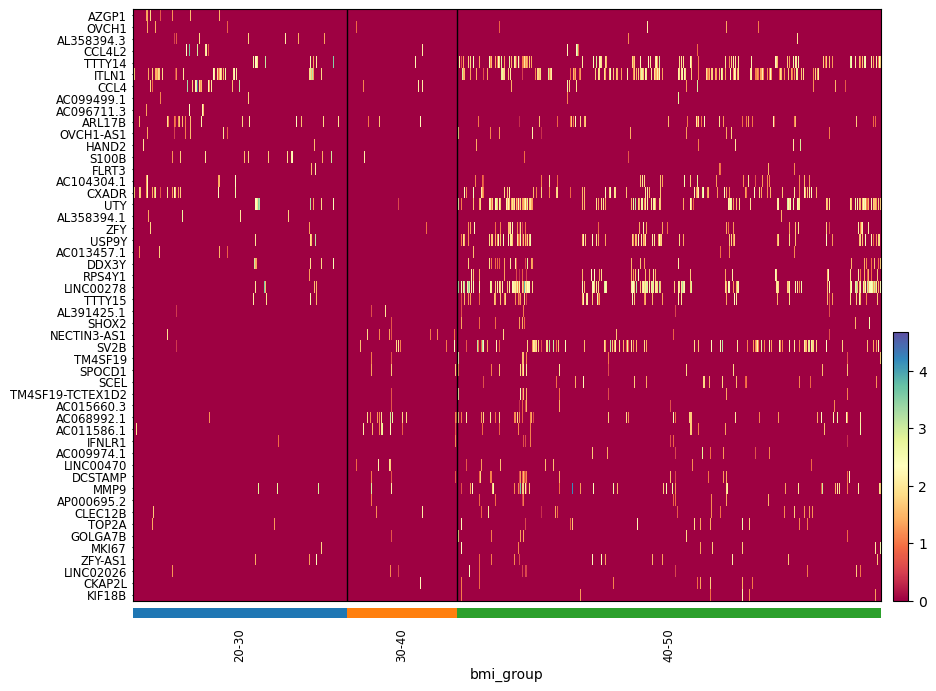

In [104]:
genes_to_show = dedf[-25:].gene.tolist() + dedf[:25].gene.tolist()

custom_palette = sns.color_palette("Spectral", as_cmap=True)

sc.pl.heatmap(
    macrophages1,
    genes_to_show,
    groupby='bmi_group',  
    swap_axes=True,
    cmap=custom_palette,  
    figsize=(10, 8),  
    show_gene_labels=True,  
    standard_scale='var'
)

### 2. DE for Adipocytes

I forgot to merge the cleaned version of the medtadata to the main Anndata so I did at this point.

In [3]:
adata =sc.read_h5ad('trained_integrated.h5ad')
adata.obs

Sample  n_genes  n_genes_by_counts  \
GCTACAAAGTAACGAT  Mm_POV_04-1     4671               4671   
TCACATTCATCGAGCC  Mm_POV_04-1     3583               3583   
TTCTAGTCAATAGTCC  Mm_POV_04-1     3933               3933   
TCGACCTGTGGTATGG  Mm_POV_04-1     3695               3695   
ACAAAGACATAGGTTC  Mm_POV_04-1     3477               3477   
...                       ...      ...                ...   
GTGTGGCGTCGTACTA  Mm_POV_02-1      420                420   
ATGGAGGTCAGAACCT  Mm_POV_02-1      441                441   
TTCTTCCAGGATACGC  Mm_POV_02-1      440                440   
GGCGTCAAGTAGGCCA  Mm_POV_02-1      426                426   
CCGGTAGTCTGGGATT  Mm_POV_02-1      442                442   

                  log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
GCTACAAAGTAACGAT                 8.449343         15691            9.660906   
TCACATTCATCGAGCC                 8.184235         13201            9.488124   
TTCTAGTCAATAGTCC                 8.277412         13118            9.481817   
TCGACCTGTGGTATGG                 8.215006         12109            9.401787   
ACAAAGACATAGGTTC                 8.154213         10739            9.281730   
...                                   ...           ...                 ...   
GTGTGGCGTCGTACTA                 6.042633           520            6.255750   
ATGGAGGTCAGAACCT                 6.091310           507            6.230481   
TTCTTCCAGGATACGC                 6.089045           593            6.386879   
GGCGTCAAGTAGGCCA                 6.056784           523            6.261492   
CCGGTAGTCTGGGATT                 6.093570           542            6.297109   

                  pct_counts_in_top_20_genes  pct_counts_mt  pct_counts_ribo  \
GCTACAAAGTAACGAT                   13.746734            0.0         0.095596   
TCACATTCATCGAGCC                   21.301417            0.0         0.242406   
TTCTAGTCAATAGTCC                   17.228236            0.0         0.266809   
TCGACCTGTGGTATGG                   18.424312            0.0         0.165166   
ACAAAGACATAGGTTC                   16.621659            0.0         0.214173   
...                                      ...            ...              ...   
GTGTGGCGTCGTACTA                   12.307692            0.0         0.384615   
ATGGAGGTCAGAACCT                   13.017751            0.0         0.197239   
TTCTTCCAGGATACGC                   19.561551            0.0         0.000000   
GGCGTCAAGTAGGCCA                   14.722753            0.0         0.191205   
CCGGTAGTCTGGGATT                   13.837638            0.0         0.000000   

                  pct_counts_hb  n_counts  doublet  doublet_score batch  \
GCTACAAAGTAACGAT       0.031865     15691      0.0   2.249508e+00     0   
TCACATTCATCGAGCC       0.000000     13201      0.0   3.255131e+00     0   
TTCTAGTCAATAGTCC       0.000000     13118      0.0   3.255131e+00     0   
TCGACCTGTGGTATGG       0.008258     12109      0.0   3.255131e+00     0   
ACAAAGACATAGGTTC       0.009312     10739      0.0   3.255131e+00     0   
...                         ...       ...      ...            ...   ...   
GTGTGGCGTCGTACTA       0.000000       520      0.0   3.850126e-08     4   
ATGGAGGTCAGAACCT       0.197239       507      0.0   3.850126e-08     4   
TTCTTCCAGGATACGC       0.000000       593      0.0   7.019015e-06     4   
GGCGTCAAGTAGGCCA       0.000000       523      0.0   4.754856e-09     4   
CCGGTAGTCTGGGATT       0.000000       542      0.0   3.850126e-08     4   

                  _scvi_batch  _scvi_labels  
GCTACAAAGTAACGAT            0             0  
TCACATTCATCGAGCC            0             0  
TTCTAGTCAATAGTCC            0             0  
TCGACCTGTGGTATGG            0             0  
ACAAAGACATAGGTTC            0             0  
...                       ...           ...  
GTGTGGCGTCGTACTA            0             0  
ATGGAGGTCAGAACCT            0             0  
TTCTTCCAGGATACGC            0             0  
GGCGTCAAGTAGGCCA   

In [18]:
metadata = pd.read_csv('metadata_final.csv')
metadata.head(3)

biosample_type library_preparation_protocol donor_id  \
0  PrimaryBioSample_Tissue                     Drop-seq   EPI249   
1  PrimaryBioSample_Tissue                     Drop-seq   EPI236   
2  PrimaryBioSample_Tissue         10x 3' v3 sequencing  HFD06.F   

        species           organ                tissue  \
0  Homo sapiens  adipose tissue  white adipose tissue   
1  Homo sapiens  adipose tissue  white adipose tissue   
2  Mus musculus  adipose tissue  white adipose tissue   

                         depot     sex   race ethnicity  \
0  subcutaneous adipose tissue  female  White  European   
1  subcutaneous adipose tissue  female  White  European   
2             inguinal fat pad  female    NaN       NaN   

         development_stage  organism_age disease   mouse_strain  \
0  54-year-old human stage            54  cancer            NaN   
1  35-year-old human stage            35  normal            NaN   
2                 20 weeks            20  normal  C57BL/6 Mouse   

   organism_weight  bmi_value bmi_group      diet_type diet_schedule  
0              NaN      26.46     20-30            NaN           NaN  
1              NaN      25.74     20-30            NaN           NaN  
2            30.23        NaN       NaN  high fat diet    ad libitum

In [21]:
metadata_df = pd.read_csv('metadata_final.csv')
metadata_df.head(3)

name           biosample_type library_preparation_protocol  \
0  Hs_SAT_SVF_249-2A-1  PrimaryBioSample_Tissue                     Drop-seq   
1  Hs_SAT_SVF_236-2A-2  PrimaryBioSample_Tissue                     Drop-seq   
2          Mm_ING_16-1  PrimaryBioSample_Tissue         10x 3' v3 sequencing   

  donor_id       species           organ                tissue  \
0   EPI249  Homo sapiens  adipose tissue  white adipose tissue   
1   EPI236  Homo sapiens  adipose tissue  white adipose tissue   
2  HFD06.F  Mus musculus  adipose tissue  white adipose tissue   

                         depot     sex   race ethnicity  \
0  subcutaneous adipose tissue  female  White  European   
1  subcutaneous adipose tissue  female  White  European   
2             inguinal fat pad  female    NaN       NaN   

         development_stage  organism_age disease   mouse_strain  \
0  54-year-old human stage            54  cancer            NaN   
1  35-year-old human stage            35  normal            NaN   
2                 20 weeks            20  normal  C57BL/6 Mouse   

   organism_weight  bmi_value bmi_group      diet_type diet_schedule  
0              NaN      26.46     20-30            NaN           NaN  
1              NaN      25.74     20-30            NaN           NaN  
2            30.23        NaN       NaN  high fat diet    ad libitum

In [24]:
metadata_df.set_index('name', inplace=True)
metadata_df.head(3)

biosample_type library_preparation_protocol  \
name                                                                        
Hs_SAT_SVF_249-2A-1  PrimaryBioSample_Tissue                     Drop-seq   
Hs_SAT_SVF_236-2A-2  PrimaryBioSample_Tissue                     Drop-seq   
Mm_ING_16-1          PrimaryBioSample_Tissue         10x 3' v3 sequencing   

                    donor_id       species           organ  \
name                                                         
Hs_SAT_SVF_249-2A-1   EPI249  Homo sapiens  adipose tissue   
Hs_SAT_SVF_236-2A-2   EPI236  Homo sapiens  adipose tissue   
Mm_ING_16-1          HFD06.F  Mus musculus  adipose tissue   

                                   tissue                        depot  \
name                                                                     
Hs_SAT_SVF_249-2A-1  white adipose tissue  subcutaneous adipose tissue   
Hs_SAT_SVF_236-2A-2  white adipose tissue  subcutaneous adipose tissue   
Mm_ING_16-1          white adipose tissue             inguinal fat pad   

                        sex   race ethnicity        development_stage  \
name                                                                    
Hs_SAT_SVF_249-2A-1  female  White  European  54-year-old human stage   
Hs_SAT_SVF_236-2A-2  female  White  European  35-year-old human stage   
Mm_ING_16-1          female    NaN       NaN                 20 weeks   

                     organism_age disease   mouse_strain  organism_weight  \
name                                                                        
Hs_SAT_SVF_249-2A-1            54  cancer            NaN              NaN   
Hs_SAT_SVF_236-2A-2            35  normal            NaN              NaN   
Mm_ING_16-1                    20  normal  C57BL/6 Mouse            30.23   

                     bmi_value bmi_group      diet_type diet_schedule  
name                                                                   
Hs_SAT_SVF_249-2A-1      26.46     20-30            NaN           NaN  
Hs_SAT_SVF_236-2A-2      25.74     20-30            NaN           NaN  
Mm_ING_16-1                NaN       NaN  high fat diet    ad libitum

In [17]:
macrophages = sc.read_h5ad('macrophages_subset.h5ad')
macrophages

AnnData object with n_obs × n_vars = 15796 × 59337
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_counts', 'doublet', 'doublet_score', 'batch', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [25]:
sample_to_metadata = metadata_df.to_dict(orient='index')

def map_sample_to_metadata(sample, feature):
    return sample_to_metadata.get(sample, {}).get(feature, None)

# adding metadata columns to adata.obs
for column in metadata_df.columns:
    macrophages.obs[column] = macrophages.obs['Sample'].map(lambda x: map_sample_to_metadata(x, column))

macrophages.obs.head()

Sample  n_genes  n_genes_by_counts  \
AAAGGATCACAAAGCG  Hs_SAT_10-1      678                678   
AAAGGTACAGCTCCTT  Hs_SAT_10-1     1551               1551   
AATGCCAAGAGGGTAA  Hs_SAT_10-1     2030               2030   
AATGCCACAAGGAGTC  Hs_SAT_10-1     1552               1552   
ACCCTTGCAATCACGT  Hs_SAT_10-1     1121               1121   

                  log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAAGGATCACAAAGCG                 6.520621           897            6.800170   
AAAGGTACAGCTCCTT                 7.347300          3075            8.031385   
AATGCCAAGAGGGTAA                 7.616284          4111            8.321665   
AATGCCACAAGGAGTC                 7.347944          3046            8.021913   
ACCCTTGCAATCACGT                 7.022868          1981            7.591862   

                  pct_counts_in_top_20_genes  pct_counts_mt  pct_counts_ribo  \
AAAGGATCACAAAGCG                   13.043478       0.000000         0.668896   
AAAGGTACAGCTCCTT                   22.731707       0.032520         0.390244   
AATGCCAAGAGGGTAA                   12.113841       0.024325         0.194600   
AATGCCACAAGGAGTC                   14.871963       0.032830         0.262640   
ACCCTTGCAATCACGT                   22.311964       0.050480         0.252398   

                  pct_counts_hb  ...  ethnicity        development_stage  \
AAAGGATCACAAAGCG        0.00000  ...   European  35-year-old human stage   
AAAGGTACAGCTCCTT        0.00000  ...   European  35-year-old human stage   
AATGCCAAGAGGGTAA        0.00000  ...   European  35-year-old human stage   
AATGCCACAAGGAGTC        0.00000  ...   European  35-year-old human stage   
ACCCTTGCAATCACGT        0.05048  ...   European  35-year-old human stage   

                  organism_age disease  mouse_strain  organism_weight  \
AAAGGATCACAAAGCG            35  normal           NaN              NaN   
AAAGGTACAGCTCCTT            35  normal           NaN              NaN   
AATGCCAAGAGGGTAA            35  normal           NaN              NaN   
AATGCCACAAGGAGTC            35  normal           NaN              NaN   
ACCCTTGCAATCACGT            35  normal           NaN              NaN   

                 bmi_value bmi_group diet_type diet_schedule  
AAAGGATCACAAAGCG      43.1     40-50       NaN           NaN  
AAAGGTACAGCTCCTT      43.1     40-50       NaN           NaN  
AATGCCAAGAGGGTAA      43.1     40-50       NaN           NaN  
AATGCCACAAGGAGTC      43.1     40-50       NaN           NaN  
ACCCTTGCAATCACGT      43.1     40-50       NaN           NaN  

[5 rows x 38 columns]

---

## GO Enrichment

Gene Ontology (GO) enrichment analysis can be applied to our work to identify biological processes, cellular components, and molecular functions associated with the genes differentially expressed between macrophage populations. By correlating the gene markers of these macrophages with specific GO terms, you can uncover insights into how these cells contribute to inflammation and adipocyte regulation, particularly across different BMI groups. GO enrichment helps in interpreting the biological significance of our findings in a more structured and functional context.


The following cells perform enrichment analysis on a list of genes (with a positive log2 fold change) from the differential expression results. Using `gseapy`, it queries Enrichr for associations with KEGG and GO Biological Process terms, applying the human background gene list from our dataset as we can see the samples left in our anndata are only human samples. Results are filtered to the top 10 terms based on the lowest adjusted p-values. The top terms are visualized in a bar plot, showing the significance of each term via `-log10` transformation of adjusted p-values.

In [114]:
import gseapy as gp

In [106]:
gene_list = dedf[dedf.log2fc > 0].gene.tolist()
len(gene_list)

2097

In [108]:
macrophages1.obs['species'].unique()

['Homo sapiens']
Categories (1, object): ['Homo sapiens']

In [110]:
enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['KEGG_2021_Human','GO_Biological_Process_2021'],
                 organism='human', 
                 outdir=None, 
                 background= macrophages1.var_names.tolist()
                )

In [111]:
enr.results

Gene_set                                   Term  \
0                KEGG_2021_Human       Protein digestion and absorption   
1                KEGG_2021_Human               ECM-receptor interaction   
2                KEGG_2021_Human                     Taste transduction   
3                KEGG_2021_Human                Cell adhesion molecules   
4                KEGG_2021_Human                African trypanosomiasis   
...                          ...                                    ...   
4657  GO_Biological_Process_2021               translation (GO:0006412)   
4658  GO_Biological_Process_2021           rRNA processing (GO:0006364)   
4659  GO_Biological_Process_2021  mRNA export from nucleus (GO:0006406)   
4660  GO_Biological_Process_2021    rRNA metabolic process (GO:0016072)   
4661  GO_Biological_Process_2021   protein targeting to ER (GO:0045047)   

           P-value  Adjusted P-value  Old P-value  Old adjusted P-value  \
0     4.268911e-07          0.000128            0                     0   
1     3.309485e-05          0.004948            0                     0   
2     2.376547e-04          0.023686            0                     0   
3     4.847928e-04          0.036238            0                     0   
4     1.179910e-03          0.070559            0                     0   
...            ...               ...          ...                   ...   
4657  9.999957e-01          0.999996            0                     0   
4658  9.999958e-01          0.999996            0                     0   
4659  9.999958e-01          0.999996            0                     0   
4660  9.999958e-01          0.999996            0                     0   
4661  9.999959e-01          0.999996            0                     0   

      Odds Ratio  Combined Score  \
0       4.187676    6.141954e+01   
1       3.309489    3.414113e+01   
2       4.840141    4.038948e+01   
3       2.262631    1.726792e+01   
4       4.565650    3.078306e+01   
...          ...             ...   
4657    0.071741    3.111763e-07   
4658    0.078310    3.304854e-07   
4659    0.065946    2.775726e-07   
4660    0.128478    5.382328e-07   
4661    0.065281    2.697509e-07   

                                                  Genes  
0     CPA3;SLC36A1;COL18A1;COL26A1;COL24A1;ELN;COL11...  
1     ITGA4;SDC4;ITGA3;LAMA4;LAMA3;FN1;HMMR;THBS2;CO...  
2     GABBR1;TAS2R30;PDE1B;PDE1A;P2RY1;TAS2R14;ITPR3...  
3     SDC4;CD80;NRXN1;NRXN3;F11R;ITGAL;CLDN1;SPN;CDH...  
4     VCAM1;LAMA4;FAS;HBA2;PRKCA;HBA1;PLCB1;PLCB2;THOP1  
...                                                 ...  
4657                                      PABPC4;MRPL37  
4658                                    EXOSC9;MPHOSPH6  
4659                                             NUP210  
4660                              EXOSC9;DEDD2;MPHOSPH6  
4661                                               SGTB  

[4662 rows x 9 columns]

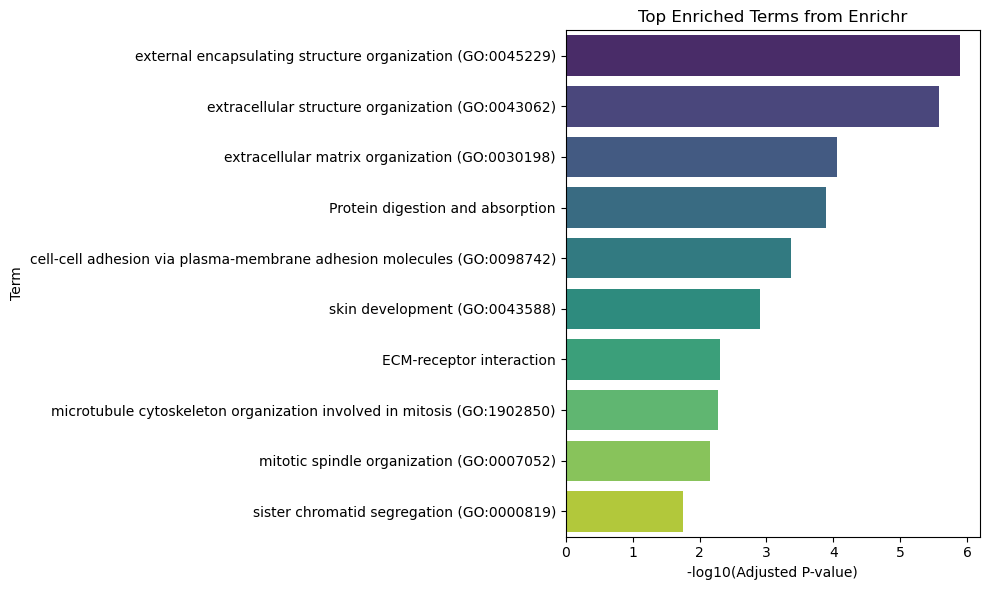

In [115]:
results_df = enr.results

top_n = 10  
top_results = results_df.nsmallest(top_n, 'Adjusted P-value')  

# plotting with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=-np.log10(top_results['Adjusted P-value']), y=top_results['Term'], palette='viridis')
plt.xlabel('-log10(Adjusted P-value)')
plt.title('Top Enriched Terms from Enrichr')
plt.tight_layout()
plt.savefig('enrichment_results.png', dpi=300, bbox_inches='tight')
plt.show()

This enrichment analysis reveals the top biological processes and pathways associated with the genes showing significant differential expression. The prominent terms include processes related to "external encapsulating structure organization," "extracellular structure organization," and "extracellular matrix organization," suggesting roles in structural and adhesion functions. 

Other terms, such as "cell-cell adhesion via plasma-membrane adhesion molecules" and "ECM-receptor interaction," indicate interactions at the cellular membrane level. The presence of terms like "mitotic spindle organization" and "sister chromatid segregation" suggests cell cycle involvement, potentially related to macrophage proliferation or other cell renewal activities.

## Comparisons:

### Finding LAM Signature

Creating a list of LAM cell marker genes by loading data from an Excel file (`MarkersAndSignatures.xlsx`) and extracting values from the `LAM_cell` sheet. This list of markers can now be used for further analysis, such as evaluating their expression levels in specific cell populations, identifying LAM cell signatures, or performing functional enrichment analysis.

In [34]:
lam_markers_df = pd.read_excel('MarkersAndSignatures.xlsx', sheet_name='LAM_cell')
lam_markers_df.head(5)

Refernce: Jaitin et al. 2019, DOI: 10.1016/j.cell.2019.05.054   Unnamed: 1  \
0                                              Gpnmb                     NaN   
1                                               Cstb                     NaN   
2                                               Ctsd                     NaN   
3                                                Cd9                     NaN   
4                                              Clic4                     NaN   

  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  Unnamed: 6 Unnamed: 7  \
0                    NaN         NaN         NaN         NaN        NaN   
1        NaN         NaN         NaN         NaN         NaN              
2        NaN         NaN         NaN         NaN         NaN        NaN   
3        NaN         NaN         NaN         NaN         NaN        NaN   
4        NaN         NaN         NaN         NaN         NaN        NaN   

   Unnamed: 8 Unnamed: 9  
0         NaN        NaN  
1         NaN        NaN  
2         NaN             
3         NaN        NaN  
4         NaN        NaN

In [37]:
lam_list = lam_markers_df.iloc[:, 0].tolist()
lam_list

['Gpnmb',
 'Cstb',
 'Ctsd',
 ' Cd9',
 ' Clic4',
 ' Nceh1',
 ' Slc37a2',
 ' Plin2',
 'Atp6v0d2',
 ' Myo1e',
 ' Fabp4',
 ' Pld3',
 ' Prdx1',
 ' Sdcbp',
 ' Anxa5',
 ' Cd300c2',
 'Rgs1',
 ' Vim',
 ' Ctss',
 ' Mmp12',
 ' Lgals3',
 ' Lpl',
 ' Fabp5',
 ' Anxa1',
 ' Tpd52',
 'Mpeg1',
 ' Apobec1',
 ' Basp1',
 ' Axl',
 ' Sirpa',
 ' Clec12a',
 ' Lcp1',
 ' Hexb',
 ' Emp1',
 'Ctsl',
 ' Rhoc',
 ' Lipa',
 ' Abhd12',
 ' Atp6v1a',
 ' Trem2',
 ' Lgals1',
 ' Akr1a1',
 ' Cd68',
 ' Cxcl16',
 ' Cd93',
 ' Lgmn',
 ' C3ar1',
 ' Ctsb',
 ' Cd63-ps',
 ' Cd63',
 ' Serpinb6a',
 ' Cd36',
 'Adgre1',
 ' Rtn4',
 ' Ms4a7',
 ' Fth1',
 ' Ftl1',
 ' Dhrs3',
 ' Mt1']

This code uses the `mygene` library to map a list of mouse LAM cell marker genes to their human orthologs. It first converts the mouse gene symbols to uppercase for case-insensitive querying, then queries the `mygene` API to retrieve human homologs using the `homologene` field. The resulting list, `human_orthologs`, contains human gene symbols corresponding to the mouse markers, allowing for cross-species gene analysis.

In [39]:
import mygene

# Initialize mygene client
mg = mygene.MyGeneInfo()

# Mouse LAM markers, converted to uppercase for case insensitivity
mouse_markers = [
    'Gpnmb', 'Cstb', 'Ctsd', 'Cd9', 'Clic4', 'Nceh1', 'Slc37a2', 'Plin2', 
    'Atp6v0d2', 'Myo1e', 'Fabp4', 'Pld3', 'Prdx1', 'Sdcbp', 'Anxa5', 
    'Cd300c2', 'Rgs1', 'Vim', 'Ctss', 'Mmp12', 'Lgals3', 'Lpl', 'Fabp5', 
    'Anxa1', 'Tpd52', 'Mpeg1', 'Apobec1', 'Basp1', 'Axl', 'Sirpa', 
    'Clec12a', 'Lcp1', 'Hexb', 'Emp1', 'Ctsl', 'Rhoc', 'Lipa', 'Abhd12', 
    'Atp6v1a', 'Trem2', 'Lgals1', 'Akr1a1', 'Cd68', 'Cxcl16', 'Cd93', 
    'Lgmn', 'C3ar1', 'Ctsb', 'Cd63-ps', 'Cd63', 'Serpinb6a', 'Cd36', 
    'Adgre1', 'Rtn4', 'Ms4a7', 'Fth1', 'Ftl1', 'Dhrs3', 'Mt1'
]
mouse_markers_upper = [gene.upper() for gene in mouse_markers]

# Query for human orthologs
result = mg.querymany(mouse_markers_upper, scopes='symbol', fields='homologene.human.symbol', species='mouse')

# Extract human ortholog symbols, handling cases where there may not be a homologene entry
human_orthologs = [
    hit['homologene']['human']['symbol'].upper() 
    for hit in result if 'homologene' in hit and 'human' in hit['homologene']
]

print(human_orthologs)

1 input query terms found dup hits:	[('CD63-PS', 2)]


[]


In [66]:
print(len(mouse_markers))
lam_present_markers = [gene.upper() for gene in mouse_markers if gene.lower() in [var_name.lower() for var_name in macrophages.var_names]]

lam_present_markers
#print(len(lam_present_markers))

59


['GPNMB',
 'CSTB',
 'CTSD',
 'CD9',
 'CLIC4',
 'NCEH1',
 'SLC37A2',
 'PLIN2',
 'ATP6V0D2',
 'MYO1E',
 'FABP4',
 'PLD3',
 'PRDX1',
 'SDCBP',
 'ANXA5',
 'RGS1',
 'VIM',
 'CTSS',
 'LGALS3',
 'LPL',
 'FABP5',
 'ANXA1',
 'TPD52',
 'MPEG1',
 'BASP1',
 'AXL',
 'SIRPA',
 'CLEC12A',
 'LCP1',
 'HEXB',
 'EMP1',
 'CTSL',
 'RHOC',
 'LIPA',
 'ABHD12',
 'ATP6V1A',
 'TREM2',
 'LGALS1',
 'AKR1A1',
 'CD68',
 'CXCL16',
 'CD93',
 'LGMN',
 'C3AR1',
 'CTSB',
 'CD63',
 'CD36',
 'ADGRE1',
 'RTN4',
 'MS4A7',
 'FTH1',
 'DHRS3']

In [67]:
# scoring cells based on LAM signature

sc.tl.score_genes(macrophages, 
                  gene_list=lam_present_markers,
                  score_name='LAM_score')

In [64]:
macrophages

AnnData object with n_obs × n_vars = 15796 × 15880
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_counts', 'doublet', 'doublet_score', 'batch', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type', 'biosample_type', 'library_preparation_protocol', 'donor_id', 'species', 'organ', 'tissue', 'depot', 'sex', 'race', 'ethnicity', 'development_stage', 'organism_age', 'disease', 'mouse_strain', 'organism_weight', 'bmi_value', 'bmi_group', 'diet_type', 'diet_schedule', 'LAM_score', 'LAM_cells'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

**We'll explore two different methods to set a threshold for the score and select the one that best aligns with our data. This way, we aim to capture the most representative and reliable results.**

To identify LAM cells, the analysis first calculates a threshold by adding one standard deviation to the mean of the LAM scores across all macrophages. Any cell with a LAM score above this threshold is labeled as a LAM cell, distinguishing it in the dataset. Finally, the distribution of LAM cells is summarized, showing the percentage of cells classified as LAM. This approach quantifies the proportion of LAM cells based on their relative score compared to the overall distribution.

In [78]:
# statistical threshold (mean + 1 std)

score_threshold = macrophages.obs['LAM_score'].mean() + macrophages.obs['LAM_score'].std()
macrophages.obs['LAM_cells'] = macrophages.obs['LAM_score'] > score_threshold

# results
lam_cell_counts = macrophages.obs['LAM_cells'].value_counts()
lam_cell_percentage = (lam_cell_counts[True] / len(macrophages)) * 100
print(f"LAM cells: {lam_cell_percentage:.1f}%")

LAM cells: 13.8%


To do it with a percentile-based approach, the 70th percentile of the LAM score distribution is set as a threshold. Any cell with a score above this threshold is classified as a LAM cell, capturing the top 30% of cells with high LAM scores. This classification allows for a focused analysis on cells with elevated LAM characteristics. The percentage of cells marked as LAM is then calculated, providing a summary of LAM cell prevalence in the dataset.

In [84]:
# percentile-based threshold
score_threshold = np.percentile(macrophages.obs['LAM_score'], 70)  # top 30%
macrophages.obs['LAM_cells'] = macrophages.obs['LAM_score'] > score_threshold

lam_cell_counts = macrophages.obs['LAM_cells'].value_counts()
lam_cell_percentage = (lam_cell_counts[True] / len(macrophages)) * 100
print(f"LAM cells: {lam_cell_percentage:.1f}%")
# we'll use this method

LAM cells: 30.0%


In [85]:
lam_cell_counts

LAM_cells
False    11057
True      4739
Name: count, dtype: int64

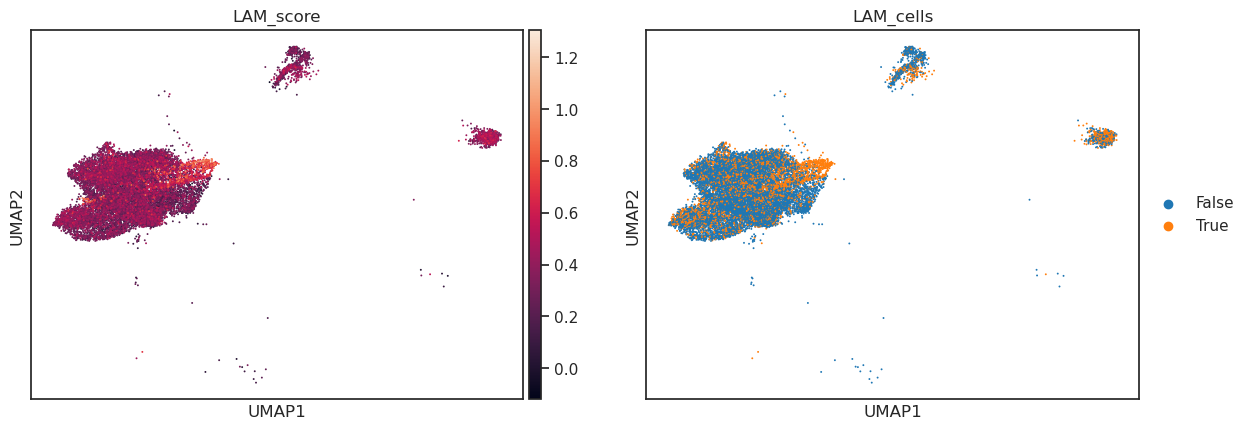

In [86]:
sc.pl.umap(macrophages, color=['LAM_score', 'LAM_cells'])

To analyze the distribution of LAM cells across BMI groups, this code groups the macrophages by BMI category and calculates both the count of LAM cells and total macrophages per group. The percentage of LAM cells within each BMI group is also computed. For visualization, **a bar chart displays the counts of LAM cells and total macrophages by BMI group**

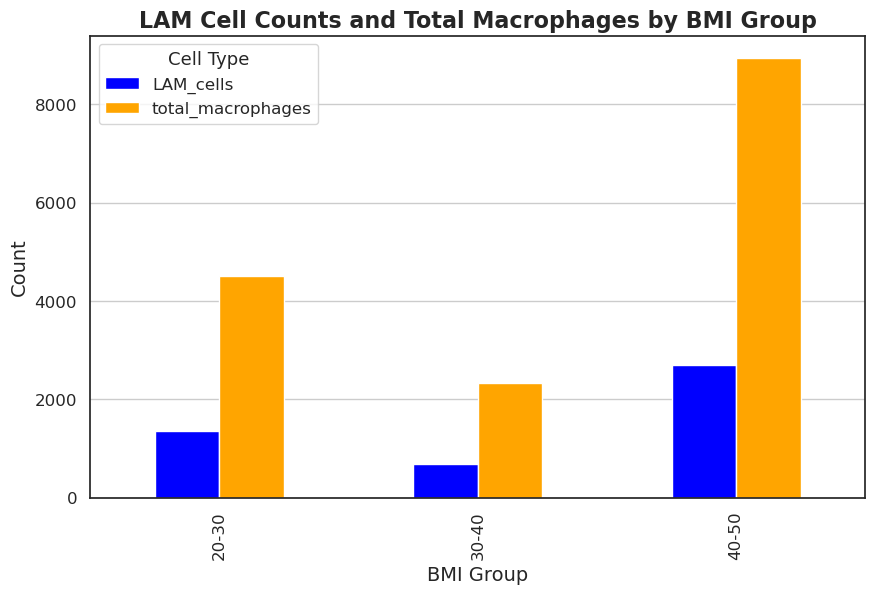

In [87]:
bmi_counts = macrophages.obs.groupby('bmi_group').agg({
    'LAM_cells': 'sum',  # Sum of LAM cells in each BMI group
    'Sample': 'count'     # Count of total macrophages in each BMI group
}).rename(columns={'Sample': 'total_macrophages'})

# Calculate the percentage of LAM cells
bmi_counts['lam_cell_percentage'] = (bmi_counts['LAM_cells'] / bmi_counts['total_macrophages']) * 100

# Set the style of the plot
sns.set(style="white")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))  # Increase figure size for better visibility

# Plotting with seaborn for a nicer aesthetic
bmi_counts[['LAM_cells', 'total_macrophages']].plot(kind='bar', ax=ax, color=['blue', 'orange'])

# Customize the title and labels
ax.set_title('LAM Cell Counts and Total Macrophages by BMI Group', fontsize=16, fontweight='bold')
ax.set_xlabel('BMI Group', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# Add a legend with a title
ax.legend(title='Cell Type', title_fontsize='13', fontsize='12')

ax.yaxis.grid(True)

#plt.savefig('figures1/lam_cell_counts_by_bmi_group.png', dpi=300, bbox_inches='tight')
plt.show()  

Adding percentage line plot to the chart

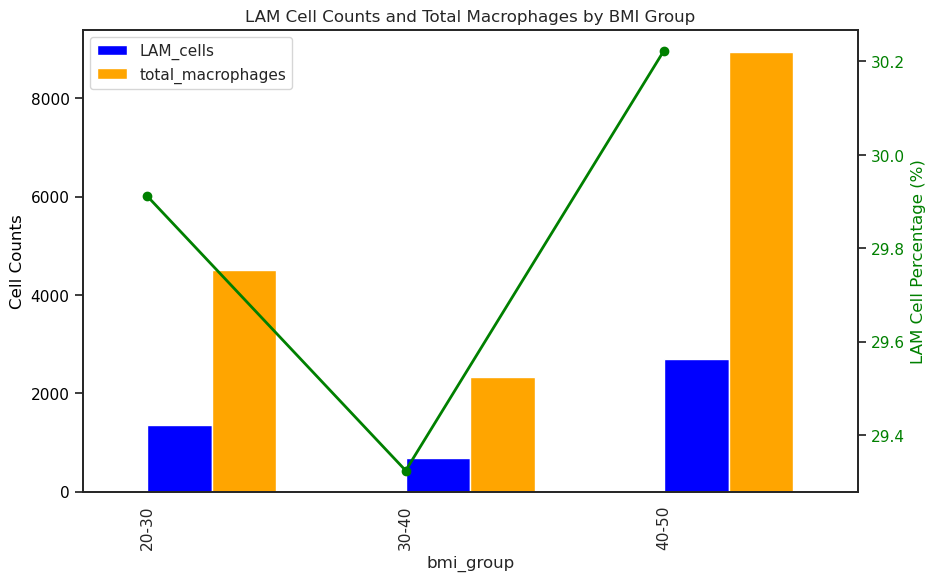

In [88]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# plotting LAM cell and total macrophage counts
bmi_counts[['LAM_cells', 'total_macrophages']].plot(kind='bar', ax=ax1, position=0, color=['blue', 'orange'])
ax1.set_ylabel('Cell Counts', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title('LAM Cell Counts and Total Macrophages by BMI Group')

# creating a second y-axis for the LAM cell percentage
ax2 = ax1.twinx()  
bmi_counts['lam_cell_percentage'].plot(kind='line', marker='o', ax=ax2, color='green', linewidth=2)
ax2.set_ylabel('LAM Cell Percentage (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

#plt.savefig('figures1/lam_cell_counts_vs_macrophages.png')
# show plot
plt.xticks(rotation=0)

plt.show()

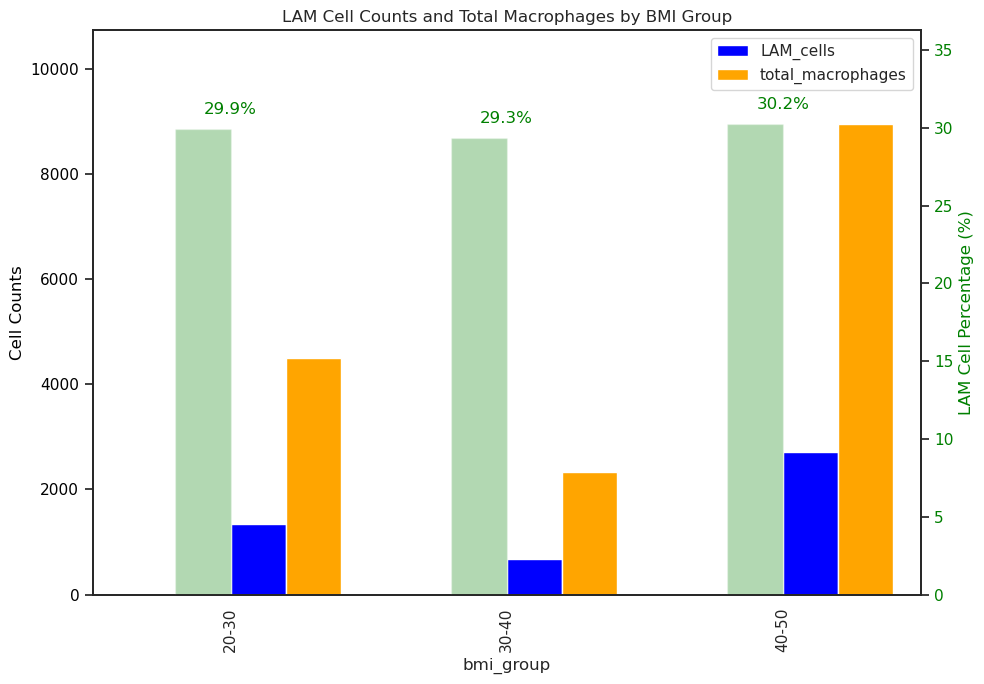

In [89]:
bmi_counts = macrophages.obs.groupby('bmi_group').agg({
    'LAM_cells': 'sum',  # Sum of LAM cells in each BMI group
    'Sample': 'count'     # Count of total macrophages in each BMI group
}).rename(columns={'Sample': 'total_macrophages'})

# Calculate the percentage of LAM cells
bmi_counts['lam_cell_percentage'] = (bmi_counts['LAM_cells'] / bmi_counts['total_macrophages']) * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 7))  # Increased figure size

# Plotting LAM cell and total macrophage counts
bmi_counts[['LAM_cells', 'total_macrophages']].plot(
    kind='bar', ax=ax1, position=0, color=['blue', 'orange'], width=0.4)  # Adjusted bar width
ax1.set_ylabel('Cell Counts', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title('LAM Cell Counts and Total Macrophages by BMI Group')

# Adding a second axis for the percentage bar plot
ax2 = ax1.twinx()
bmi_counts['lam_cell_percentage'].plot(
    kind='bar', ax=ax2, alpha=0.3, position=1, color='green', width=0.2)  # Reduced width
ax2.set_ylabel('LAM Cell Percentage (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Adding data labels for the percentage bars
for i, v in enumerate(bmi_counts['lam_cell_percentage']):
    ax2.text(i, v + 1, f"{v:.1f}%", color='green', ha='center')

# Adjust the y-axis limits if necessary
ax1.set_ylim(0, bmi_counts['total_macrophages'].max() * 1.2)  # Set y-axis limit for counts
ax2.set_ylim(0, max(bmi_counts['lam_cell_percentage']) * 1.2)   # Set y-axis limit for percentage

ax1.set_xlim(-0.5, len(bmi_counts) - 0.5)  # Set limits to add padding

plt.xticks(rotation=0)
plt.tight_layout()
#plt.savefig('figures1/lam_cell_counts_vs_macrophages1.png')
plt.show()

Renaming specific categories within the `depot` column in `macrophages.obs`. It replaces "subcutaneous adipose tissue" with "SAT" and "omental fat pad" with "VAT," simplifying the names for these depot types.

In [100]:
# Rename the depot categories
macrophages.obs['depot'] = macrophages.obs['depot'].replace({
    'subcutaneous adipose tissue': 'SAT',
    'omental fat pad': 'VAT'
})
macrophages.obs['depot'].unique()

['SAT', 'VAT']
Categories (2, object): ['VAT', 'SAT']

Next we want to compare the counts and percentages of LAM cells within subcutaneous (SAT) and visceral (VAT) fat depots across different BMI groups. 

1. **Aggregation and Plot Setup**: It aggregates LAM cell and total macrophage counts, then calculates LAM cell percentages by depot and BMI group.
2. **Bar and Line Plots**: The primary y-axis shows counts of LAM cells and total macrophages, while the secondary y-axis tracks LAM cell percentages, using separate colors and markers for SAT and VAT.
3. **Legend and Aesthetics**: Custom legends, color schemes, and layout adjustments improve readability, aiding in the interpretation of LAM cell distribution across BMI and depot types.

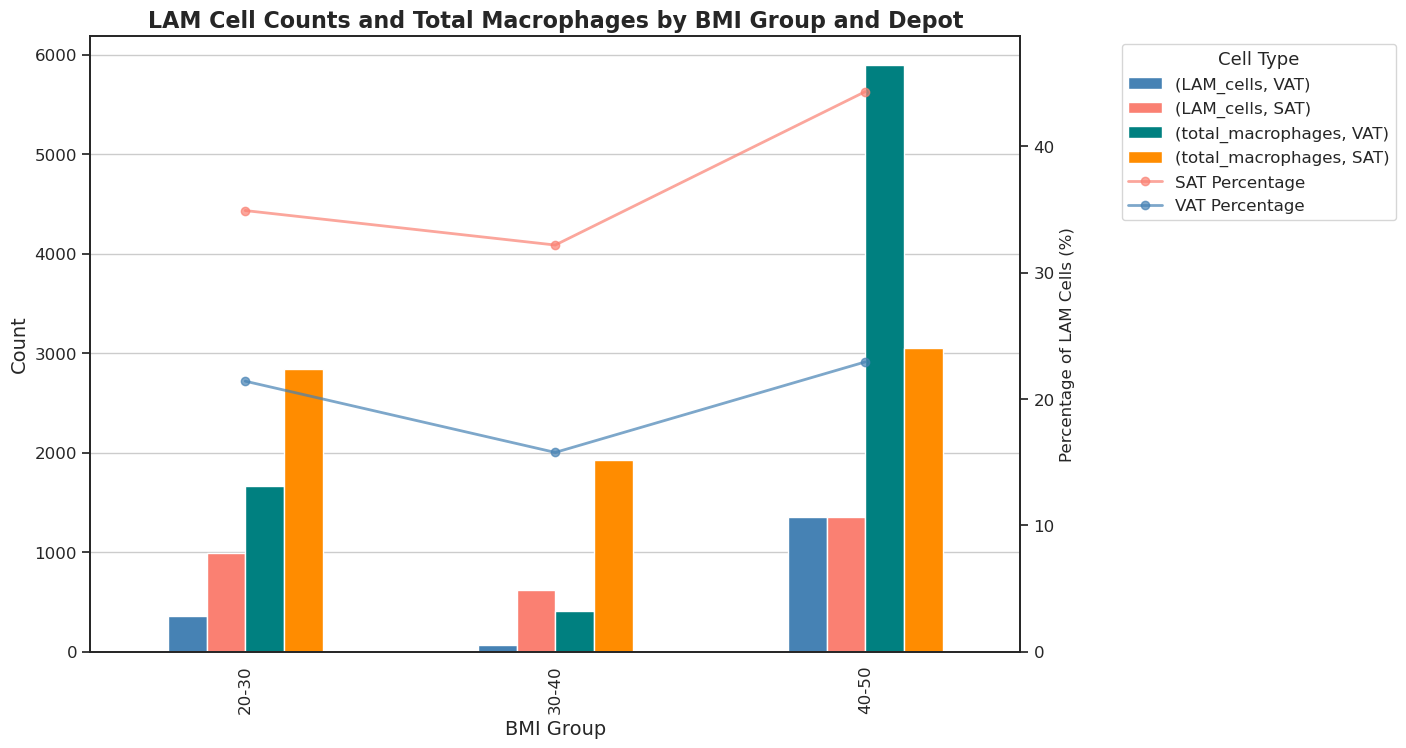

In [195]:
bmi_depot_counts = macrophages.obs.groupby(['bmi_group', 'depot']).agg({
    'LAM_cells': 'sum',  # Sum of LAM cells in each BMI group and depot
    'Sample': 'count'     # Count of total macrophages in each BMI group and depot
}).rename(columns={'Sample': 'total_macrophages'})

# Calculate the percentage of LAM cells
bmi_depot_counts['lam_cell_percentage'] = (bmi_depot_counts['LAM_cells'] / bmi_depot_counts['total_macrophages']) * 100

# Set the style of the plot
sns.set(style="white")

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 8))  # Increase figure size for better visibility

# Define colors for each metric and depot
colors = {
    'LAM_cells_SAT': 'salmon',
    'total_macrophages_SAT': 'darkorange',
    'LAM_cells_VAT': 'steelblue',
    'total_macrophages_VAT': 'teal'
}

# Unstack the data for plotting
bmi_depot_counts_unstacked = bmi_depot_counts[['LAM_cells', 'total_macrophages']].unstack()

# Create a list of colors that matches the column order
plot_colors = []
for col in bmi_depot_counts_unstacked.columns:
    metric, depot = col  # First level is metric, second level is depot
    color_key = f"{metric}_{depot}"
    plot_colors.append(colors[color_key])

# Plotting LAM cell counts and total macrophages with custom colors
bmi_depot_counts_unstacked.plot(kind='bar', ax=ax1, color=plot_colors)

# Customize the title and labels for the primary y-axis
ax1.set_title('LAM Cell Counts and Total Macrophages by BMI Group and Depot', fontsize=16, fontweight='bold')
ax1.set_xlabel('BMI Group', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
ax1.tick_params(axis='both', labelsize=12)

# Add grid lines for better readability
ax1.yaxis.grid(True)

# Create a secondary y-axis for percentages
ax2 = ax1.twinx()

line_colors = {'SAT': 'salmon', 'VAT': 'steelblue'}

# Plot SAT and VAT percentage lines with different colors and markers
for depot in ['SAT', 'VAT']:
    depot_data = bmi_depot_counts.loc[(slice(None), depot), 'lam_cell_percentage']
    depot_data.index = depot_data.index.get_level_values('bmi_group')  # Simplify index to just BMI group
    depot_data.plot(
        kind='line', marker='o', ax=ax2, color=line_colors[depot], 
        linewidth=2, alpha=0.7, label=f'{depot} Percentage'
    )

# Set the limits for the secondary y-axis to start from zero
ax2.set_ylim(0, bmi_depot_counts['lam_cell_percentage'].max() * 1.1)  # Extend slightly above the max percentage
ax2.set_ylabel('Percentage of LAM Cells (%)', fontsize=12)
ax2.tick_params(axis='y', labelsize=12)

# Add a legend with a title, adjusting the position to prevent overlap
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, 
          title='Cell Type', title_fontsize='13', 
          fontsize='12', loc='upper left', 
          bbox_to_anchor=(1.1, 1))

#plt.tight_layout()

# Save the plot with a higher resolution (uncomment the following line if you want to save it)
#plt.savefig('figures1/lam_cell_counts_and_percentages_by_bmi_and_depot.png', dpi=300, bbox_inches='tight')

plt.show()

Then we would like to visualize the LAM signature score distribution across BMI groups using a combined boxplot and strip plot:

1. **Boxplot with Strip Overlay**: The boxplot shows the distribution of LAM signature scores for each BMI group, while the strip plot overlays individual data points to show score variability.
2. **Custom Aesthetics**: It uses a pink-based color palette (`RdPu`) and gridlines for visual clarity. Labels and titles are bolded, and the x-axis labels are rotated for readability.
3. **Mean Calculation**: After plotting, it calculates and displays the mean LAM signature score per BMI group for quick summary insights.

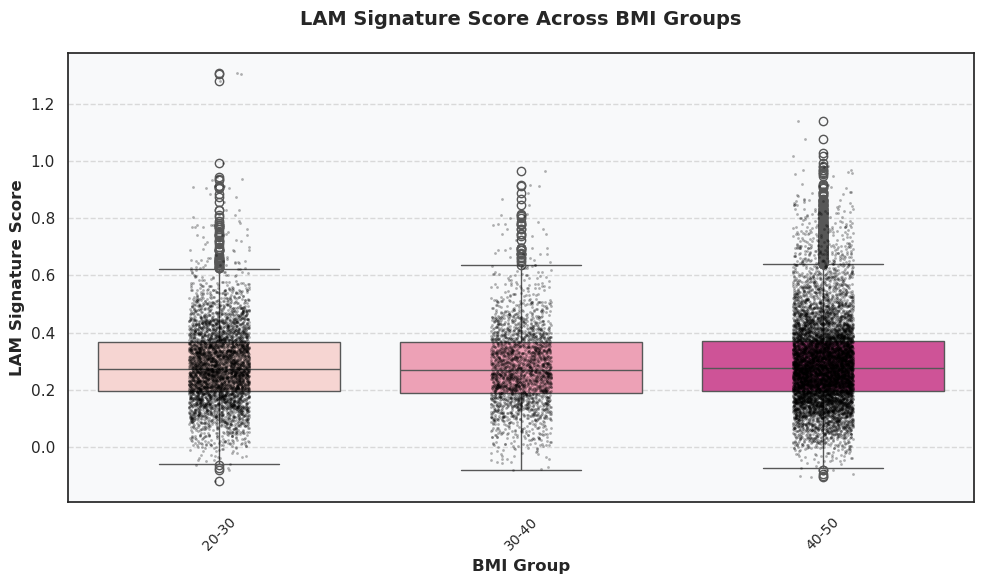


Mean LAM signature score per BMI group:
bmi_group
20-30    0.285682
30-40    0.280870
40-50    0.294328
Name: LAM_score, dtype: float64


In [91]:
# Color palette and figure size
colors = sns.color_palette("RdPu", n_colors=4)

plt.figure(figsize=(10, 6))

# Boxplot
sns.boxplot(data=macrophages.obs, x='bmi_group', y='LAM_score', 
            palette=colors)

# Stripplot (overlay)
sns.stripplot(data=macrophages.obs, x='bmi_group', y='LAM_score', 
              color='black', size=2, alpha=0.3)

# Title and labels
plt.title('LAM Signature Score Across BMI Groups', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('BMI Group', fontsize=12, fontweight='bold')
plt.ylabel('LAM Signature Score', fontsize=12, fontweight='bold')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, fontsize=10)

# Gridlines
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Set facecolor for the background
plt.gca().set_facecolor('#f8f9fa')

# Tight layout to avoid overlap
plt.tight_layout()

#plt.savefig('figures1/lam_signature_score_across_bmi.png')
plt.show()

print("\nMean LAM signature score per BMI group:")
print(macrophages.obs.groupby('bmi_group')['LAM_score'].mean())

In [105]:
macrophages.obs['depot'].unique()

['SAT', 'VAT']
Categories (2, object): ['VAT', 'SAT']

---

### Separating MMe Macrophages

Here is a list of genes related to MME (membrane metallo-endopeptidase) is ready. These genes, including **TNF, IL6, IL1B,** and others, will help in exploring MME-associated pathways and cellular mechanisms. This list can serve as a base for various analyses, such as expression profiling or pathway enrichment

In [157]:
mme_gene_markers = ['TNF', 'IL6', 'IL1B', 'CD36', 'PLIN2', 'P62', 'SQSTM1', 'LAMP1', 'LAMP2', 'ATP6V1A', 'CYBB']

Filtering the list of MME-related gene markers (`mme_gene_markers`) to only include those present in the dataset's `macrophages.var_names`. The matched gene names are then converted to uppercase. It prints the full list of MME markers, the number of markers in the full list, the list of present markers, and their count.

In [158]:
mme_present_markers = [gene.upper() for gene in mme_gene_markers if gene.lower() in [var_name.lower() for var_name in macrophages.var_names]]

print(f'mme full list of markers: {mme_gene_markers}')
print(f'length of full list of markers: {len(mme_gene_markers)}')


print(f'mme present markers: {mme_present_markers}')
print(f'length of mme present markers: {len(mme_present_markers)}')

mme full list of markers: ['TNF', 'IL6', 'IL1B', 'CD36', 'PLIN2', 'P62', 'SQSTM1', 'LAMP1', 'LAMP2', 'ATP6V1A', 'CYBB']
length of full list of markers: 11
mme present markers: ['TNF', 'IL1B', 'CD36', 'PLIN2', 'SQSTM1', 'LAMP1', 'LAMP2', 'ATP6V1A', 'CYBB']
length of mme present markers: 9


We can plot a histogram of the expression values for the 'CYBB' gene (a synonym for 'NOX2') in the `macrophages` AnnData object. The expression values are flattened into a 1D array and displayed with 50 bins, along with a kernel density estimate (KDE) to show the distribution. The x-axis represents the gene expression levels, the y-axis shows the number of cells, and the plot is titled "Distribution of CYBB Expression".

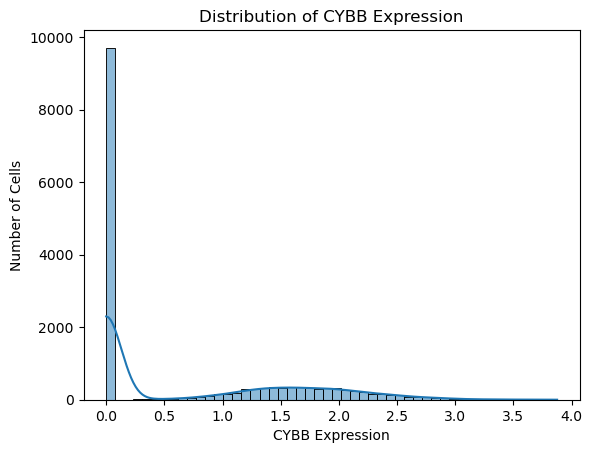

In [90]:
sns.histplot(macrophages[:, 'CYBB'].X.flatten(), bins=50, kde=True)
plt.xlabel('CYBB Expression')
plt.ylabel('Number of Cells')
plt.title('Distribution of CYBB Expression')
plt.show()

Now, let's repeat the steps we previously followed for identifying the signature of LAM cells but for MMe signature.

In [164]:
# scoring cells based on MMe signature

sc.tl.score_genes(macrophages, 
                  gene_list=mme_present_markers,
                  score_name='MMe_score')

In [318]:
# statistical threshold (mean + 1 std)

score_threshold = macrophages.obs['MMe_score'].mean() + macrophages.obs['MMe_score'].std()
macrophages.obs['inflammatory_macrophages'] = macrophages.obs['MMe_score'] > score_threshold

# results
inflammatory_macrophages_counts = macrophages.obs['inflammatory_macrophages'].value_counts()
inflammatory_macrophages_percentage = (inflammatory_macrophages_counts[True] / len(macrophages)) * 100
print(f"Inflammatory macrophages: {inflammatory_macrophages_percentage:.1f}%")

Inflammatory macrophages: 15.8%


In [184]:
score_threshold = np.percentile(macrophages.obs['MMe_score'], 70)  # top 30%
macrophages.obs['inflammatory_macrophages'] = macrophages.obs['MMe_score'] > score_threshold

inflammatory_macrophages_counts = macrophages.obs['inflammatory_macrophages'].value_counts()
inflammatory_macrophages_percentage = (inflammatory_macrophages_counts[True] / len(macrophages)) * 100
print(f"Inflammatory macrophages: {inflammatory_macrophages_percentage:.1f}%")

Inflammatory macrophages: 30.0%


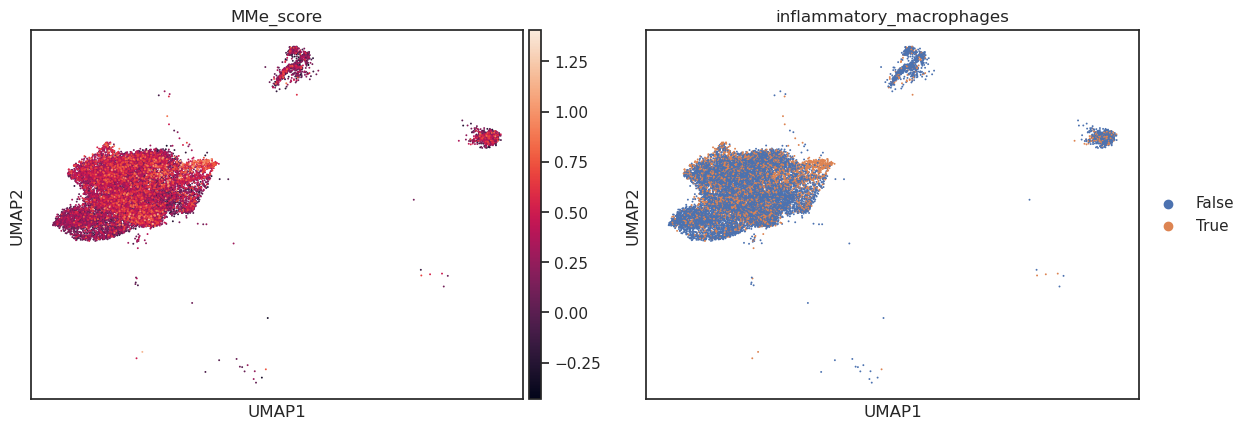

In [185]:
sc.pl.umap(macrophages, color=['MMe_score', 'inflammatory_macrophages'])

In [169]:
macrophages

AnnData object with n_obs × n_vars = 15796 × 15880
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_counts', 'doublet', 'doublet_score', 'batch', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type', 'biosample_type', 'library_preparation_protocol', 'donor_id', 'species', 'organ', 'tissue', 'depot', 'sex', 'race', 'ethnicity', 'development_stage', 'organism_age', 'disease', 'mouse_strain', 'organism_weight', 'bmi_value', 'bmi_group', 'diet_type', 'diet_schedule', 'LAM_score', 'LAM_cells', 'MMe_score', 'inflammatory_macrophages'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap', 'LAM_cells_colors', 'inflammatory_macrophages_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_conti

The following steps calculate and visualize the counts and percentages of inflammatory macrophages across different BMI groups and fat depots (SAT, VAT). It groups the data by `bmi_group` and `depot`, then calculates the total macrophage counts and the inflammatory macrophage percentages. A bar plot displays these counts, while a secondary y-axis shows the inflammatory macrophage percentages for each depot. The plot is customized with colors, labels, and a combined legend. Finally, the figure is saved as a PNG file and displayed.

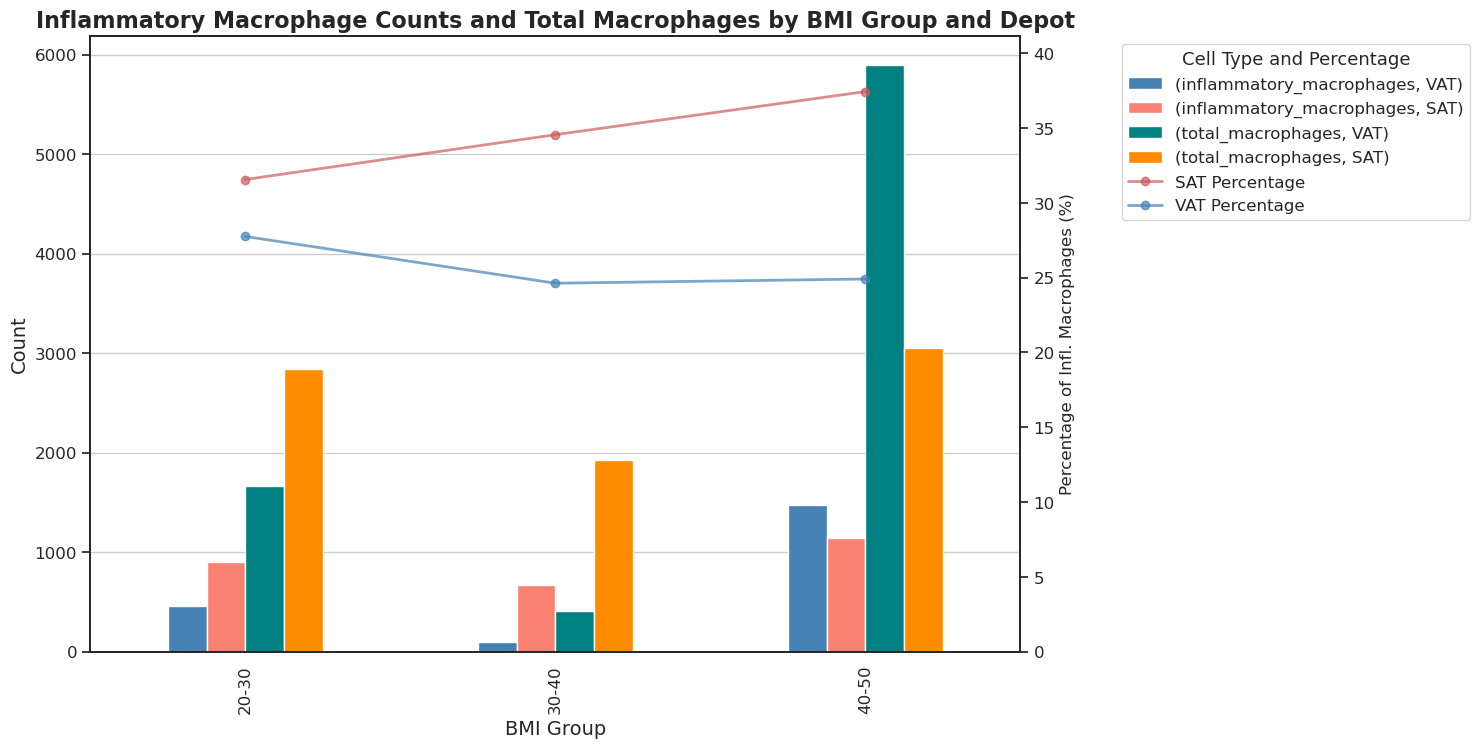

In [196]:
# First calculate inflammatory macrophages counts and percentages
bmi_depot_counts = macrophages.obs.groupby(['bmi_group', 'depot']).agg({
    'inflammatory_macrophages': 'sum',  
    'Sample': 'count'     # Count of total macrophages in each BMI group and depot
}).rename(columns={'Sample': 'total_macrophages', 'inflammatory_macrophages': 'inflammatory_macrophages'})

# Calculate the percentage of inflammatory macrophages
bmi_depot_counts['inflammatory_macrophage_percentage'] = (bmi_depot_counts['inflammatory_macrophages'] / bmi_depot_counts['total_macrophages']) * 100

# Set the style of the plot
sns.set(style="white")

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Define colors for each metric and depot
colors = {
    'inflammatory_macrophages_SAT': 'salmon',     
    'total_macrophages_SAT': 'darkorange',        
    'inflammatory_macrophages_VAT': 'steelblue',  
    'total_macrophages_VAT': 'teal'               
}

# Unstack the data for plotting
bmi_depot_counts_unstacked = bmi_depot_counts[['inflammatory_macrophages', 'total_macrophages']].unstack()

# Create a list of colors that matches the column order
plot_colors = []
for col in bmi_depot_counts_unstacked.columns:
    metric, depot = col  # First level is metric, second level is depot
    color_key = f"{metric}_{depot}"
    plot_colors.append(colors[color_key])

# Plotting inflammatory macrophage counts and total macrophages with new colors
bmi_depot_counts_unstacked.plot(kind='bar', ax=ax1, color=plot_colors)

# Customize the title and labels for the primary y-axis
ax1.set_title('Inflammatory Macrophage Counts and Total Macrophages by BMI Group and Depot', fontsize=16, fontweight='bold')
ax1.set_xlabel('BMI Group', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
ax1.tick_params(axis='both', labelsize=12)

# Add grid lines for better readability
ax1.yaxis.grid(True)

# Create a secondary y-axis for the inflammatory macrophage percentage
ax2 = ax1.twinx()

# Define colors for the percentage lines for SAT and VAT
line_colors = {'SAT': 'indianred', 'VAT': 'steelblue'}

# Plot SAT and VAT percentage lines with different colors and markers
for depot in ['SAT', 'VAT']:
    depot_data = bmi_depot_counts.loc[(slice(None), depot), 'inflammatory_macrophage_percentage']
    depot_data.index = depot_data.index.get_level_values('bmi_group')  # Simplify index to just BMI group
    depot_data.plot(
        kind='line', marker='o', ax=ax2, color=line_colors[depot], 
        linewidth=2, alpha=0.7, label=f'{depot} Percentage'
    )

# Set the limits for the secondary y-axis to start from zero
ax2.set_ylim(0, bmi_depot_counts['inflammatory_macrophage_percentage'].max() * 1.1)  
ax2.set_ylabel('Percentage of Infl. Macrophages (%)', fontsize=12)
ax2.tick_params(axis='y', labelsize=12)

# Add a legend with a title, adjusting the position to prevent overlap
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, 
          title='Cell Type and Percentage', title_fontsize='13', 
          fontsize='12', loc='upper left', 
          bbox_to_anchor=(1.1, 1))
plt.savefig('figures1/infl_macrophages_counts_and_percentage.png', dpi=300, bbox_inches='tight')
plt.show()

In [204]:
macrophages.write_h5ad('macrophages_2.h5ad')

-----

### Proportion of LAM cells per sample across BMI groups

This code calculates the proportion of LAM cells per sample, grouped by BMI group and depot (SAT, VAT). It creates a box plot to show the distribution of LAM percentages across BMI groups and depots, with individual data points overlaid using a swarm plot. The plot is customized with titles, labels, and a legend. Summary statistics for LAM cell proportions are printed for each BMI group and depot.

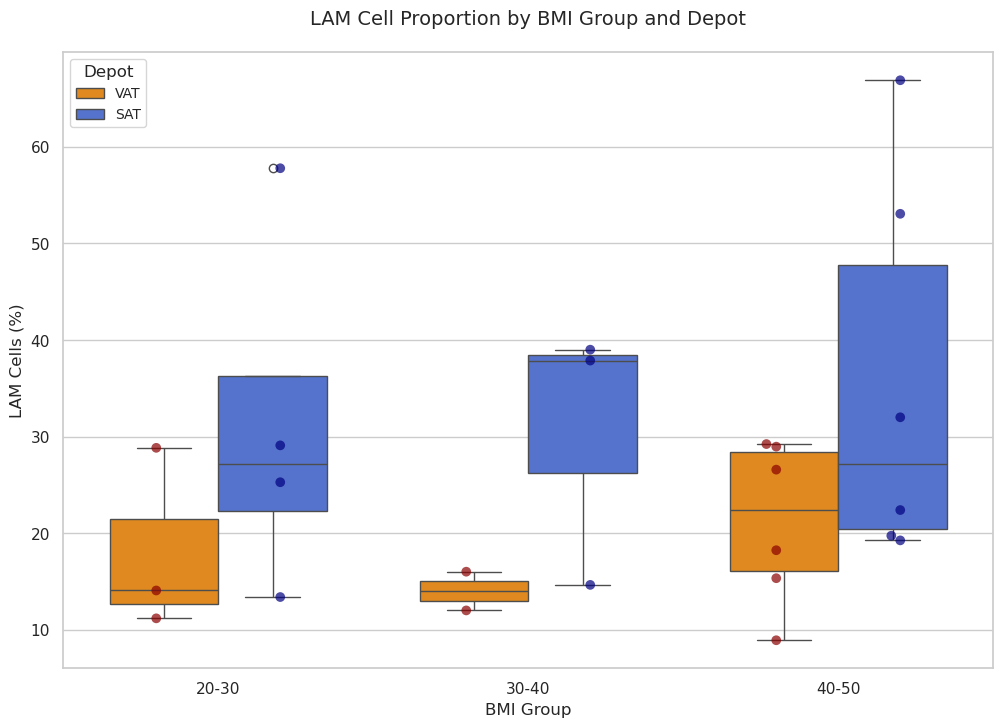


Summary Statistics for LAM Percentage grouping per sample:
                 count       mean        std        min        25%        50%  \
bmi_group depot                                                                 
20-30     VAT      3.0  18.027416   9.472023  11.180124  12.622520  14.064915   
          SAT      4.0  31.385559  18.830532  13.385827  22.302501  27.183398   
30-40     VAT      2.0  14.005249   2.835851  12.000000  13.002625  14.005249   
          SAT      3.0  30.505649  13.748573  14.643545  26.257943  37.872340   
40-50     VAT      6.0  21.207119   8.339801   8.910891  16.059921  22.405438   
          SAT      6.0  35.559305  19.955897  19.253209  20.401087  27.196911   

                       75%        max  
bmi_group depot                        
20-30     VAT    21.451062  28.837209  
          SAT    36.266457  57.789614  
30-40     VAT    15.007874  16.010499  
          SAT    38.436702  39.001063  
40-50     VAT    28.363017  29.227324  
          S

In [221]:
# Calculate the proportion of LAM cells per sample
sample_proportions = macrophages.obs.groupby('Sample').agg({
    'LAM_cells': 'sum',  
    'Sample': 'size'     
}).rename(columns={'Sample': 'total_cells'})

# Calculate the percentage
sample_proportions['LAM_percentage'] = (sample_proportions['LAM_cells'] / sample_proportions['total_cells']) * 100

# Get depot and BMI group information for each sample
sample_metadata = macrophages.obs.groupby('Sample').agg({
    'depot': 'first',
    'bmi_group': 'first'
}).join(sample_proportions) # here we used first because every sample should have the same depot and bmi_group value for all its cells then we join the sample_proportions to it 

# Set up the plot style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Create a box plot with individual points
ax = sns.boxplot(data=sample_metadata, 
                x='bmi_group', 
                y='LAM_percentage',
                hue='depot',
                palette={'SAT': 'royalblue', 'VAT': 'darkorange'},
                width=0.7)

# Add individual points
sns.swarmplot(data=sample_metadata,
              x='bmi_group',
              y='LAM_percentage',
              hue='depot',
              palette={'SAT': 'navy', 'VAT': 'darkred'},
              size=7,
              alpha=0.7,
              dodge=True)

# Customize the plot
plt.title('LAM Cell Proportion by BMI Group and Depot', fontsize=14, pad=20)
plt.xlabel('BMI Group', fontsize=12)
plt.ylabel('LAM Cells (%)', fontsize=12)

# Adjust legend
handles, labels = ax.get_legend_handles_labels()
# Keep only the first two legend entries (remove duplicates from swarmplot)
plt.legend(handles[:2], labels[:2], title='Depot', title_fontsize=12, fontsize=10)

#plt.tight_layout()

# Save the plot
#plt.savefig('lam_proportion_by_bmi_and_depot.png', dpi=300, bbox_inches='tight')

plt.show()

# Print summary statistics
print("\nSummary Statistics for LAM Percentage grouping per sample:")
print(sample_metadata.groupby(['bmi_group', 'depot'])['LAM_percentage'].describe())


---

### Adipocytes Analysis

So the first step is to filter the AnnData object to include only adipocytes and counts the number of adipocytes per sample. Then we filter out genes that are expressed in fewer than 100 cells from the adipocyte data.

In [279]:
adata.write_h5ad('annotaed_1.h5ad')

In [282]:
adata.obs['cell_type'].unique()

[NaN, 'Adipocytes', 'Macrophages']
Categories (2, object): ['Adipocytes', 'Macrophages']

In [303]:
# Filter to get only the Adipocytes
adipocytes = adata[adata.obs['cell_type'] == 'Adipocytes']

# Count the number of Adipocytes per sample
adipocyte_counts = adipocytes.obs.groupby('Sample')['cell_type'].count().reset_index(name='adipocyte_count')

In [302]:
sc.pp.filter_genes(adipocytes, min_cells=100)
adipocytes

AnnData object with n_obs × n_vars = 21895 × 19035
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_counts', 'doublet', 'doublet_score', 'batch', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type', 'biosample_type', 'library_preparation_protocol', 'donor_id', 'species', 'organ', 'tissue', 'depot', 'sex', 'race', 'ethnicity', 'development_stage', 'organism_age', 'disease', 'mouse_strain', 'organism_weight', 'bmi_value', 'bmi_group', 'diet_type', 'diet_schedule'
    var: 'ensembl_id', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors', 'rank_genes_groups', 'cell_type_colors'
    obsm: 'X_scVI', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

Then we add BMI group information to the adipocyte counts and summarize the adipocyte counts by BMI group. This calculates the mean, standard deviation, and count of adipocytes per BMI group, then sorts the results by the mean adipocyte count in descending order. 

The summary is printed for review.

In [304]:
# Add the BMI group information
bmi_groups = adata.obs[['bmi_group', 'Sample']].drop_duplicates()
adipocyte_counts = adipocyte_counts.merge(bmi_groups, on='Sample', how='left')

In [305]:
# Summarize the adipocyte counts by BMI group
adipocyte_summary = adipocyte_counts.groupby('bmi_group')['adipocyte_count'].agg(['mean', 'std', 'count']).reset_index()
adipocyte_summary = adipocyte_summary.sort_values('mean', ascending=False)

print(adipocyte_summary)

  bmi_group         mean          std  count
0     20-30  1556.428571  1234.995932      7
1     30-40   692.600000   518.041794      5
2     40-50   628.083333   315.575796     12


In order to visualize counts we can create a bar plot showing the average adipocyte count per sample across different BMI groups, using the 'viridis' color palette. Error bars representing the standard deviation are also added. 

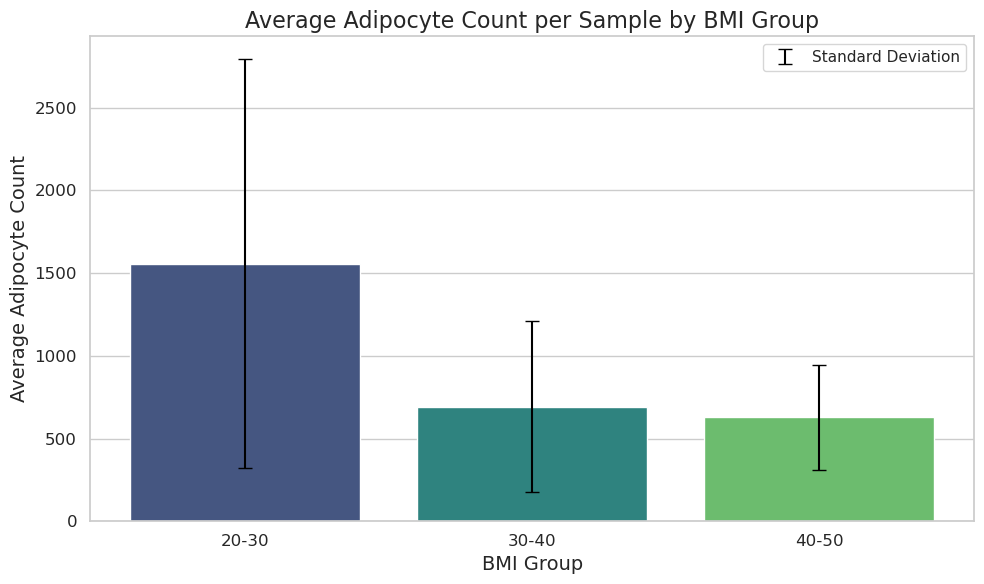

In [307]:
sns.set(style="whitegrid")

# bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=adipocyte_summary,
    x='bmi_group', y='mean', 
    palette='viridis',  
    ci=None             
)

# Add error bars (standard deviation)
plt.errorbar(
    adipocyte_summary['bmi_group'], 
    adipocyte_summary['mean'], 
    yerr=adipocyte_summary['std'], 
    fmt='none', 
    c='black', 
    capsize=5, 
    label='Standard Deviation'
)

# Customize the plot
plt.title('Average Adipocyte Count per Sample by BMI Group', fontsize=16)
plt.xlabel('BMI Group', fontsize=14)
plt.ylabel('Average Adipocyte Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.savefig('figures1/adipocyte_count_per_sample_across_bmi.png')
# Show the plot
plt.tight_layout()
plt.show()

We want to define a list of mature adipocyte markers and check which of them are present in the AnnData object's variable names. Then we print the full list of markers, the total number of markers, the list of present markers, and the number of present markers **to view how many of them are present in our Anndata subset**

In [309]:
mature_adipocyte_markers = [
    "PPARG", "CEBPA", "FABP4", "ADIPOQ", "PLIN1",
    "LEP", "SCD1", "LPL", "CIDEC", "ACSL1"
]

In [310]:
mature_adipocyte_present_markers = [gene.upper() for gene in mature_adipocyte_markers if gene.lower() in [var_name.lower() for var_name in adata.var_names]]

print(f'mature_adipocyte list of markers: {mature_adipocyte_markers}')
print(f'length of full list of markers: {len(mature_adipocyte_markers)}')


print(f'present markers: {mature_adipocyte_present_markers}')
print(f'length of present markers: {len(mature_adipocyte_present_markers)}')

mature_adipocyte list of markers: ['PPARG', 'CEBPA', 'FABP4', 'ADIPOQ', 'PLIN1', 'LEP', 'SCD1', 'LPL', 'CIDEC', 'ACSL1']
length of full list of markers: 10
present markers: ['PPARG', 'CEBPA', 'FABP4', 'ADIPOQ', 'PLIN1', 'LEP', 'SCD1', 'LPL', 'CIDEC', 'ACSL1']
length of present markers: 10


Then we calculate a score for each cell based on the expression of mature adipocyte markers and assigns the score to a new column called 'mature_adipocyte_score' in the AnnData object. The score reflects the degree to which each cell expresses the defined mature adipocyte signature.

After this we set a threshold for mature adipocyte scores as we did before as the mean plus one standard deviation of the 'mature_adipocyte_score'. It then classifies cells as 'mature_adipocytes' if their score exceeds the threshold. The percentage of cells classified as mature adipocytes is calculated and printed.

In [311]:
# scoring cells based on mature adipo signature

sc.tl.score_genes(adata, 
                  gene_list=mature_adipocyte_present_markers,
                  score_name='mature_adipocyte_score')

In [317]:
# statistical threshold (mean + 1 std)

score_threshold = adata.obs['mature_adipocyte_score'].mean() + adata.obs['mature_adipocyte_score'].std()
adata.obs['mature_adipocytes'] = adata.obs['mature_adipocyte_score'] > score_threshold

# results
mature_adipocytes_counts = adata.obs['mature_adipocytes'].value_counts()
mature_adipocytes_percentage = (mature_adipocytes_counts[True] / len(adata)) * 100
print(f"Inflammatory macrophages: {mature_adipocytes_percentage:.1f}%")

Inflammatory macrophages: 11.9%


Then we want to calculate the number of mature adipocytes per sample by summing the 'mature_adipocytes' values for each sample. It then adds the BMI group information to the counts and summarizes the mature adipocyte counts by BMI group, calculating the mean, standard deviation, and count for each group. The results are sorted by the mean count in descending order and printed.

In [319]:
mature_adipocyte_counts = adata.obs.groupby('Sample')['mature_adipocytes'].sum().reset_index(name='mature_adipocyte_count')

# Add the BMI group information
bmi_groups = adata.obs[['bmi_group', 'Sample']].drop_duplicates()
mature_adipocyte_counts = mature_adipocyte_counts.merge(bmi_groups, on='Sample', how='left')

# Summarize the mature adipocyte counts by BMI group
mature_adipocyte_summary = mature_adipocyte_counts.groupby('bmi_group')['mature_adipocyte_count'].agg(['mean', 'std', 'count']).reset_index()
mature_adipocyte_summary = mature_adipocyte_summary.sort_values('mean', ascending=False)

print(mature_adipocyte_summary)

  bmi_group         mean          std  count
0     20-30  2172.000000  1697.021508      7
1     30-40  1711.400000  1468.751783      5
2     40-50   714.916667   400.866892     12


Then we generate basically the same plot as we did in the clustered adipocytes but for the mature adipocytes that we scored in the previous step.

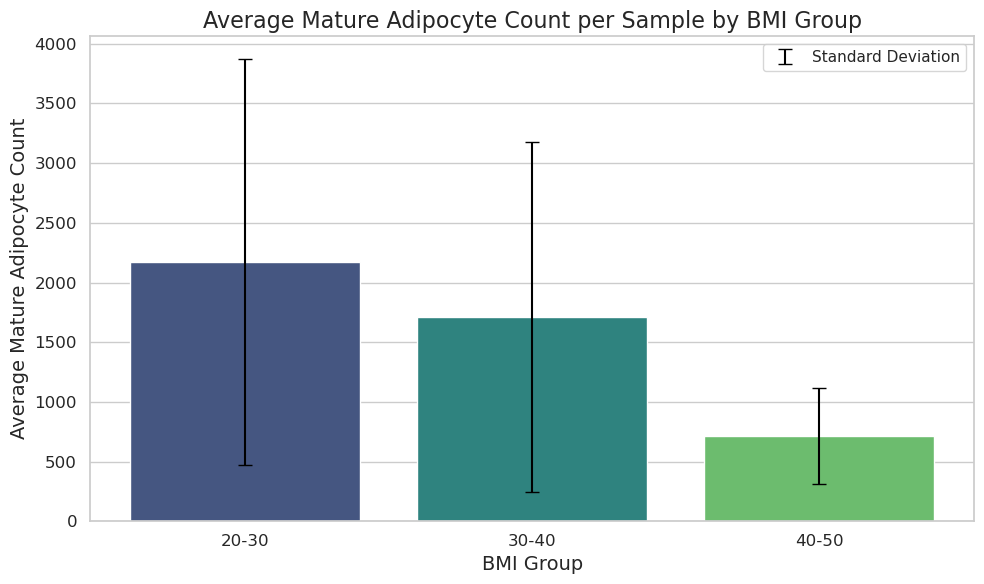

In [320]:
sns.set(style="whitegrid")

# bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=mature_adipocyte_summary,
    x='bmi_group', y='mean', 
    palette='viridis',  
    ci=None             
)

# Add error bars (standard deviation)
plt.errorbar(
    mature_adipocyte_summary['bmi_group'], 
    mature_adipocyte_summary['mean'], 
    yerr=mature_adipocyte_summary['std'], 
    fmt='none', 
    c='black', 
    capsize=5, 
    label='Standard Deviation'
)

# Customize the plot
plt.title('Average Mature Adipocyte Count per Sample by BMI Group', fontsize=16)
plt.xlabel('BMI Group', fontsize=14)
plt.ylabel('Average Mature Adipocyte Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.savefig('figures1/adipocyte_count_per_sample_across_bmi.png')
# Show the plot
plt.tight_layout()
plt.show()


In [324]:
adipocyte_data = adata[adata.obs['cell_type'] == 'Adipocytes'].copy()
adipocyte_data

AnnData object with n_obs × n_vars = 21895 × 43411
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_counts', 'doublet', 'doublet_score', 'batch', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type', 'biosample_type', 'library_preparation_protocol', 'donor_id', 'species', 'organ', 'tissue', 'depot', 'sex', 'race', 'ethnicity', 'development_stage', 'organism_age', 'disease', 'mouse_strain', 'organism_weight', 'bmi_value', 'bmi_group', 'diet_type', 'diet_schedule', 'mature_adipocyte_score', 'mature_adipocytes'
    var: 'ensembl_id', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors', 'rank_genes_groups', 'cell_type_colors'
    obsm: 'X_scVI', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'conn

In [326]:
sc.pp.filter_genes(adipocyte_data, min_cells=100)
adipocyte_data

AnnData object with n_obs × n_vars = 21895 × 19035
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_counts', 'doublet', 'doublet_score', 'batch', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type', 'biosample_type', 'library_preparation_protocol', 'donor_id', 'species', 'organ', 'tissue', 'depot', 'sex', 'race', 'ethnicity', 'development_stage', 'organism_age', 'disease', 'mouse_strain', 'organism_weight', 'bmi_value', 'bmi_group', 'diet_type', 'diet_schedule', 'mature_adipocyte_score', 'mature_adipocytes'
    var: 'ensembl_id', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors', 'rank_genes_groups', 'cell_type_colors'
    obsm: 'X_scVI', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'conn

In [333]:
#adipocyte_data.obs = adipocyte_data.obs.applymap(lambda x: str(x) if not isinstance(x, str) else x)
adipocyte_data.write_h5ad('adipocytes_data.h5ad')

---

## DE for Adipocytes:

In [6]:
adipocyte_data.obs['depot'].replace({
    'subcutaneous adipose tissue': 'SAT',
    'omental fat pad': 'VAT'
}, inplace=True)

## 1. Running pyDESeq2 with respect to depot

We will first process data by converting the data matrix to dense format, and then preparing it for differential expression analysis using the `pyDESeq2` package. The `DeseqDataSet` is created from the count data, with the depot as a design factor. After performing DESeq2 normalization with `dds.deseq2()`, it calculates differential expression between the SAT and VAT depots using `DeseqStats` and stores the results in `res`.

In [7]:
adipocyte_data.X = adipocyte_data.X.todense()

In [8]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [9]:
counts_df = pd.DataFrame(
    data=adipocyte_data.layers["counts"].toarray(), 
    index=adipocyte_data.obs_names,
    columns=adipocyte_data.var_names
)
counts_df.head(5)

GENE              A1CF  A2M  A2M-AS1  A2ML1  A2ML1-AS1  A4GALT  AAAS  AACS  \
AAACGCTGTATACGGG   0.0  0.0      0.0    0.0        1.0     0.0   0.0   0.0   
AAAGGTACACCTGCGA   0.0  0.0      0.0    0.0        0.0     0.0   0.0   0.0   
AAAGTCCGTTCCAAAC   0.0  0.0      0.0    0.0        1.0     0.0   0.0   0.0   
AACAACCCATTCCTCG   0.0  0.0      0.0    0.0        1.0     0.0   0.0   0.0   
AACAAGAAGATTAGAC   0.0  1.0      0.0    0.0        0.0     0.0   0.0   0.0   

GENE              AADAC  AADACL2-AS1  ...  ZUFSP  ZW10  ZWILCH  ZXDB  ZXDC  \
AAACGCTGTATACGGG    0.0          0.0  ...    0.0   0.0     0.0   0.0   0.0   
AAAGGTACACCTGCGA    0.0          0.0  ...    0.0   0.0     0.0   0.0   1.0   
AAAGTCCGTTCCAAAC    0.0          0.0  ...    0.0   0.0     0.0   0.0   0.0   
AACAACCCATTCCTCG    0.0          0.0  ...    0.0   0.0     0.0   0.0   0.0   
AACAAGAAGATTAGAC    0.0          0.0  ...    0.0   1.0     0.0   0.0   1.0   

GENE              ZYG11A  ZYG11B  ZYX  ZZEF1  ZZZ3  
AAACGCTGTATACGGG     0.0     0.0  0.0    0.0   1.0  
AAAGGTACACCTGCGA     0.0     0.0  0.0    0.0   0.0  
AAAGTCCGTTCCAAAC     0.0     2.0  0.0    1.0   0.0  
AACAACCCATTCCTCG     0.0     1.0  0.0    0.0   1.0  
AACAAGAAGATTAGAC     0.0     0.0  0.0    0.0   0.0  

[5 rows x 19035 columns]

In [10]:
metadata_df = adipocyte_data.obs[["depot"]]
metadata_df.head(5)

depot
AAACGCTGTATACGGG   SAT
AAAGGTACACCTGCGA   SAT
AAAGTCCGTTCCAAAC   SAT
AACAACCCATTCCTCG   SAT
AACAAGAAGATTAGAC   SAT

In [11]:
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata_df,
    design_factors="depot",
)

In [12]:
dds.deseq2()

Fitting size factors...
... done in 1.08 seconds.

Fitting dispersions...
... done in 1494.75 seconds.

Fitting dispersion trend curve...
... done in 0.22 seconds.

Fitting MAP dispersions...
... done in 1427.35 seconds.

Fitting LFCs...
... done in 57.79 seconds.

Calculating cook's distance...
... done in 18.85 seconds.

Replacing 8 outlier genes.

Fitting dispersions...
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 0.47 seconds.

Fitting LFCs...
... done in 0.03 seconds.



In [15]:
stat_res = DeseqStats(dds, contrast=('depot', 'SAT', 'VAT'))
stat_res

In [16]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: depot SAT vs VAT
           baseMean  log2FoldChange     lfcSE       stat        pvalue  \
GENE                                                                     
A1CF       0.008364       -0.088812  0.484229  -0.183410  8.544766e-01   
A2M        0.331476       -0.322516  0.052541  -6.138409  8.335184e-10   
A2M-AS1    0.039919       -0.090690  0.238262  -0.380632  7.034761e-01   
A2ML1      0.015896       -0.104001  0.332978  -0.312337  7.547846e-01   
A2ML1-AS1  0.217481       -0.081274  0.046006  -1.766606  7.729428e-02   
...             ...             ...       ...        ...           ...   
ZYG11A     0.006747       -0.102911  0.521603  -0.197298  8.435940e-01   
ZYG11B     0.426218        0.237458  0.038315   6.197473  5.737700e-10   
ZYX        0.058455        0.009909  0.154620   0.064089  9.488995e-01   
ZZEF1      0.702431        0.674759  0.032699  20.635497  1.317830e-94   
ZZZ3       1.118147        0.547996  0.028755  19.057437 

... done in 6.31 seconds.



In [17]:
res = stat_res.results_df
res

baseMean  log2FoldChange     lfcSE       stat        pvalue  \
GENE                                                                     
A1CF       0.008364       -0.088812  0.484229  -0.183410  8.544766e-01   
A2M        0.331476       -0.322516  0.052541  -6.138409  8.335184e-10   
A2M-AS1    0.039919       -0.090690  0.238262  -0.380632  7.034761e-01   
A2ML1      0.015896       -0.104001  0.332978  -0.312337  7.547846e-01   
A2ML1-AS1  0.217481       -0.081274  0.046006  -1.766606  7.729428e-02   
...             ...             ...       ...        ...           ...   
ZYG11A     0.006747       -0.102911  0.521603  -0.197298  8.435940e-01   
ZYG11B     0.426218        0.237458  0.038315   6.197473  5.737700e-10   
ZYX        0.058455        0.009909  0.154620   0.064089  9.488995e-01   
ZZEF1      0.702431        0.674759  0.032699  20.635497  1.317830e-94   
ZZZ3       1.118147        0.547996  0.028755  19.057437  5.699921e-81   

                   padj  
GENE                     
A1CF                NaN  
A2M        2.686816e-09  
A2M-AS1             NaN  
A2ML1               NaN  
A2ML1-AS1  1.398082e-01  
...                 ...  
ZYG11A              NaN  
ZYG11B     1.861763e-09  
ZYX                 NaN  
ZZEF1      2.038895e-93  
ZZZ3       7.425036e-80  

[19035 rows x 6 columns]

In [18]:
res.columns

Index(['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj'], dtype='object')

This step filters the results from the differential expression analysis (`res`) to identify significantly differentially expressed genes. It selects **genes with an adjusted p-value (`padj`) less than 0.05 and a log2 fold change (`log2FoldChange`) greater than 0.5 or less than -0.5, indicating moderate to strong expression changes between the SAT and VAT depots.** The filtered genes are stored in the `sigs` variable.

In [41]:
sigs = res[(res['padj'] < 0.05) & (abs(res['log2FoldChange']) > 0.5)]
sigs
# this it basically what we need to get the differentially expressed genes

baseMean  log2FoldChange     lfcSE       stat         pvalue  \
GENE                                                                       
ABCA10      1.573082        0.732020  0.029844  24.528531  7.330963e-133   
ABCA5       2.224991        0.823065  0.022096  37.250254  1.049607e-303   
ABCA8       1.574319       -1.127944  0.030043 -37.544353  1.741909e-308   
ABCA9-AS1   0.463304       -0.711560  0.043203 -16.470055   6.021527e-61   
ABCC9       0.686093        0.899004  0.039944  22.506728  3.566425e-112   
...              ...             ...       ...        ...            ...   
ZNF704      1.729786        0.736578  0.027555  26.731081  2.049333e-157   
ZRANB2-AS2  0.591163        0.547351  0.045614  11.999672   3.567061e-33   
ZSWIM6      1.595689        0.893859  0.031145  28.699985  3.816850e-181   
ZZEF1       0.702431        0.674759  0.032699  20.635497   1.317830e-94   
ZZZ3        1.118147        0.547996  0.028755  19.057437   5.699921e-81   

                     padj  
GENE                       
ABCA10      1.745374e-131  
ABCA5       1.019366e-301  
ABCA8       1.798567e-306  
ABCA9-AS1    5.824966e-60  
ABCC9       6.806044e-111  
...                   ...  
ZNF704      6.223500e-156  
ZRANB2-AS2   2.117996e-32  
ZSWIM6      1.451143e-179  
ZZEF1        2.038895e-93  
ZZZ3         7.425036e-80  

[1214 rows x 6 columns]

### Gene Set Enrichment Analysis (GSEA)

### Step 1: Running Gene Set Enrichment Analysis (GSEA) on Ranked Data

- **Ranking Genes by Stat Values**: We first extracted the `stat` (statistical score, from DESeq2 results) column from your results dataframe `res`, removed any missing values (`dropna()`), and then sorted it in descending order (`ascending=False`). This creates a ranked list of genes based on their statistical significance (such as log-fold changes or other metrics).
  
- **Performing GO Enrichment Analysis**: The `gp.prerank()` function from the `gseapy` package was used to perform Gene Set Enrichment Analysis (GSEA) on this ranked gene list. We specified that the gene sets should come from the "GO_Biological_Process_2021" database, which contains biological process-related terms from Gene Ontology. Then we set a seed for reproducibility and specified 100 permutations for statistical significance testing.

In [42]:
import gseapy as gp
from gseapy.plot import gseaplot

In [43]:
res

baseMean  log2FoldChange     lfcSE       stat        pvalue  \
GENE                                                                     
A1CF       0.008364       -0.088812  0.484229  -0.183410  8.544766e-01   
A2M        0.331476       -0.322516  0.052541  -6.138409  8.335184e-10   
A2M-AS1    0.039919       -0.090690  0.238262  -0.380632  7.034761e-01   
A2ML1      0.015896       -0.104001  0.332978  -0.312337  7.547846e-01   
A2ML1-AS1  0.217481       -0.081274  0.046006  -1.766606  7.729428e-02   
...             ...             ...       ...        ...           ...   
ZYG11A     0.006747       -0.102911  0.521603  -0.197298  8.435940e-01   
ZYG11B     0.426218        0.237458  0.038315   6.197473  5.737700e-10   
ZYX        0.058455        0.009909  0.154620   0.064089  9.488995e-01   
ZZEF1      0.702431        0.674759  0.032699  20.635497  1.317830e-94   
ZZZ3       1.118147        0.547996  0.028755  19.057437  5.699921e-81   

                   padj  
GENE                     
A1CF                NaN  
A2M        2.686816e-09  
A2M-AS1             NaN  
A2ML1               NaN  
A2ML1-AS1  1.398082e-01  
...                 ...  
ZYG11A              NaN  
ZYG11B     1.861763e-09  
ZYX                 NaN  
ZZEF1      2.038895e-93  
ZZZ3       7.425036e-80  

[19035 rows x 6 columns]

In [45]:
ranking = res.loc[:, ['stat']].dropna().sort_values('stat', ascending=False)
ranking

stat
GENE                 
ITIH5       79.802008
LINC01239   78.025231
NAV3        73.676864
SOS1        73.648489
WDPCP       71.407607
...               ...
AL109930.1 -45.179019
MIR100HG   -46.037210
AC006387.1 -46.449360
KCNIP2-AS1 -49.046772
TSHZ2      -49.262107

[19035 rows x 1 columns]

In [46]:
pre_res = gp.prerank(rnk= ranking,
                     gene_sets=['GO_Biological_Process_2021'],
                     seed=6, permutation_num=100)

### Step 2: Organizing Results into a DataFrame

- **Extracting Enrichment Results**: After running the enrichment analysis, we looped through each term (GO biological process) in the results of the analysis. For each term, you extracted:
  - `fdr` (False Discovery Rate): The adjusted p-value for each term indicating its significance.
  - `es` (Enrichment Score): A measure of the degree to which the gene set is overrepresented at the top or bottom of the ranked list.
  - `nes` (Normalized Enrichment Score): The enrichment score normalized to account for the size of the gene set, making it comparable across gene sets.

- **Creating a DataFrame**: We then compiled this information into a list `out` and converted it into a Pandas DataFrame (`out_df`) with columns for the term name, FDR, ES, and NES. The DataFrame was sorted by `fdr` to prioritize the most significant biological processes (lower FDR values) and the index was reset for neatness.

In [47]:
# es: enrichment score and nes: normalized enrichment

out = []

for term in list(pre_res.results):
    # Append the FDR, enrichment score (es), and normalized enrichment score (nes) for each term
    out.append([term,  # The term or gene set name
               pre_res.results[term]['fdr'],  # False discovery rate (FDR) of the enrichment
               pre_res.results[term]['es'],   # Enrichment score (ES) for the term
               pre_res.results[term]['nes']]) # Normalized enrichment score (NES) for the term

# Create a DataFrame from the output list with columns for Term, FDR, ES, and NES
out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes'])
out_df = out_df.sort_values('fdr').reset_index(drop = True)
out_df

Term       fdr        es  \
0     GO_Biological_Process_2021__purinergic nucleot...  0.031150 -0.814619   
1     GO_Biological_Process_2021__response to ketone...  0.273353  0.838663   
2     GO_Biological_Process_2021__leukocyte tetherin...  0.273787  0.871886   
3     GO_Biological_Process_2021__regulation of cell...  0.274848  0.827414   
4     GO_Biological_Process_2021__sarcomere organiza...  0.275157 -0.587904   
...                                                 ...       ...       ...   
2409  GO_Biological_Process_2021__metal ion export (...  1.000000 -0.599649   
2410  GO_Biological_Process_2021__maturation of SSU-...  1.000000 -0.336704   
2411  GO_Biological_Process_2021__regulation of woun...  1.000000  0.858071   
2412  GO_Biological_Process_2021__negative regulatio...  1.000000 -0.435769   
2413  GO_Biological_Process_2021__retinol metabolic ...  1.000000 -0.426898   

           nes  
0    -1.945343  
1     1.328027  
2     1.326089  
3     1.330325  
4    -1.496592  
...        ...  
2409 -1.078875  
2410 -0.840359  
2411  1.385955  
2412 -0.821565  
2413 -1.003987  

[2414 rows x 4 columns]

The code `out_df.sort_values('nes').iloc[0].Term` sorts the `out_df` DataFrame by the `nes` column in ascending order, selects the row with the lowest NES value, and retrieves the corresponding term from the `Term` column.


In [49]:
# we get the most enriched and get the term of it like this to make a gsea plot out of it

out_df.sort_values('nes').iloc[0].Term

'GO_Biological_Process_2021__purinergic nucleotide receptor signaling pathway (GO:0035590)'

In [ ]:
pre_res.results['GO_Biological_Process_2021__purinergic nucleotide receptor signaling pathway (GO:0035590)']

The `gseaplot` function is used to create a plot for a specific term from Gene Set Enrichment Analysis (GSEA) results. And we specify the following parameters:

- **`rank_metric=pre_res.ranking`**: This specifies the ranking metric used to rank genes (e.g., based on a fold change or some other metric) from the `pre_res` object. This is what will be plotted along the x-axis.
  
- **`term='GO_Biological_Process_2021__purinergic nucleotide receptor signaling pathway (GO:0035590)'`**: This is the specific gene set or pathway you want to visualize. It's a GO term here, specifically the "purinergic nucleotide receptor signaling pathway."

- **`**pre_res.results['GO_Biological_Process_2021__purinergic nucleotide receptor signaling pathway (GO:0035590)']`**: This unpacks the result for that particular GO term from `pre_res.results` and passes it as additional arguments to `gseaplot`. Including parameters like the enrichment score, p-value.

[<Axes: xlabel='Gene Rank', ylabel='Ranked metric'>,
 <Axes: >,
 <Axes: >,
 <Axes: ylabel='Enrichment Score'>]

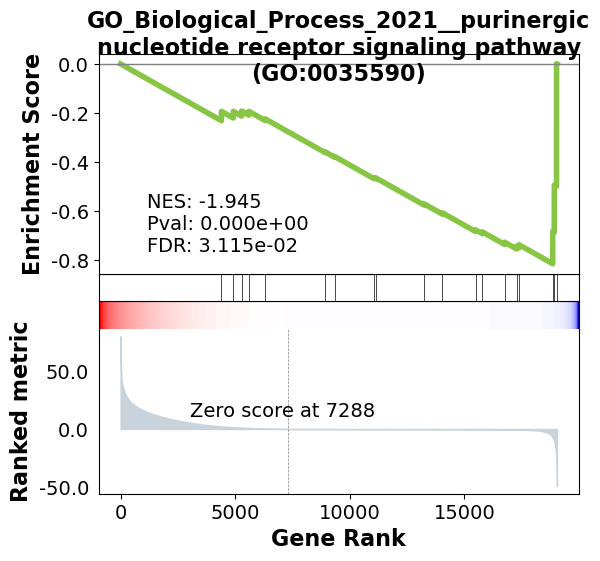

In [55]:
gseaplot(rank_metric= pre_res.ranking,
         term= 'GO_Biological_Process_2021__purinergic nucleotide receptor signaling pathway (GO:0035590)',
         **pre_res.results['GO_Biological_Process_2021__purinergic nucleotide receptor signaling pathway (GO:0035590)'])

### Heatmap for significant genes

Getting back to our dds we created before running our GO Enrichment

In [56]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds

AnnData object with n_obs × n_vars = 21895 × 19035
    obs: 'depot'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'replace_cooks', 'log1p'

In [58]:
# subseting the significant genes from dds

dds_sigs = dds[:, sigs.index]
dds_sigs

View of AnnData object with n_obs × n_vars = 21895 × 1214
    obs: 'depot'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'replace_cooks', 'log1p'

In [59]:
# we need 3 things for the heatmap, logp values, var_names and obs_names

grapher = pd.DataFrame(dds_sigs.layers['log1p'].T,
                       index= dds_sigs.var_names, columns=dds_sigs.obs_names)

In [60]:
grapher

AAACGCTGTATACGGG  AAAGGTACACCTGCGA  AAAGTCCGTTCCAAAC  \
GENE                                                               
ABCA10              0.549872          0.887585          0.000000   
ABCA5               1.162867          0.887585          0.722518   
ABCA8               0.000000          0.000000          0.425141   
ABCA9-AS1           1.162867          0.000000          0.000000   
ABCC9               0.549872          0.887585          0.000000   
...                      ...               ...               ...   
ZNF704              1.540121          1.350282          0.000000   
ZRANB2-AS2          0.000000          0.000000          0.000000   
ZSWIM6              0.000000          0.887585          0.234995   
ZZEF1               0.000000          0.000000          0.234995   
ZZZ3                0.549872          0.000000          0.000000   

            AACAACCCATTCCTCG  AACAAGAAGATTAGAC  AACAAGATCAACGTGT  \
GENE                                                               
ABCA10              0.000000          0.000000          0.619067   
ABCA5               1.283036          0.668830          0.619067   
ABCA8               0.000000          0.000000          0.356693   
ABCA9-AS1           1.283036          0.000000          0.000000   
ABCC9               0.000000          0.000000          0.356693   
...                      ...               ...               ...   
ZNF704              0.000000          1.169761          0.619067   
ZRANB2-AS2          0.000000          0.000000          0.000000   
ZSWIM6              1.283036          0.668830          0.356693   
ZZEF1               0.000000          0.000000          0.000000   
ZZZ3                1.283036          0.000000          0.619067   

            AACCAACTCAGGACAG  AACCACACACCAACAT  AACCTTTCAGTATTCG  \
GENE                                                               
ABCA10              0.530198          0.000000           2.08482   
ABCA5               0.530198          2.508974           2.08482   
ABCA8               0.000000          0.000000           0.00000   
ABCA9-AS1           0.000000          0.000000           0.00000   
ABCC9               0.000000          0.000000           0.00000   
...                      ...               ...               ...   
ZNF704              0.000000          0.000000           0.00000   
ZRANB2-AS2          0.000000          1.894038           0.00000   
ZSWIM6              0.874859          1.894038           2.08482   
ZZEF1               0.000000          0.000000           0.00000   
ZZZ3                0.530198          2.508974           0.00000   

            AAGACTCTCAATCTCT  ...  TTGACCCAGTTTCGAC  TTGCTGCTCGAGTGGA  \
GENE                          ...                                       
ABCA10              2.756522  ...          0.000000          0.847731   
ABCA5               0.000000  ...          0.000000          1.299835   
ABCA8               0.000000  ...          1.693092          2.197899   
ABCA9-AS1           0.000000  ...          0.000000          0.000000   
ABCC9               2.382320  ...          0.000000          0.000000   
...                      ...  ...               ...               ...   
ZNF704              2.382320  ...          1.693092          2.037542   
ZRANB2-AS2          0.000000  ...          0.000000          1.846466   
ZSWIM6              2.382320  ...          0.000000          0.000000   
ZZEF1               0.000000  ...          0.000000          1.299835   
ZZZ3                0.000000  ...          0.000000          2.197899   

            TTGGGATTCCACTGAA  TTGGGCGCACTACTTT  TTGTGGAGTCATCGGC  \
GENE                                                               
ABCA10              0.000000          0.000000          1.033953   
ABCA5               0.000000          2.968590          1.033953   
ABCA8               0.000000          2.325542          1.033953   
ABCA9-AS1           0.000000          0.000000          0.000000   

In [70]:
sigs = res.sort_values('log2FoldChange', ascending= False)
sigs = sigs[(sigs.padj < 0.05) & (abs(sigs.log2FoldChange) > 0.5)]
sigs

baseMean  log2FoldChange     lfcSE       stat         pvalue  \
GENE                                                                       
AC104574.2  1.347023        3.058761  0.066568  45.949642   0.000000e+00   
LINC01239   4.297190        3.001555  0.038469  78.025231   0.000000e+00   
NRCAM       0.814689        2.558471  0.062289  41.074520   0.000000e+00   
FOS         0.769229        2.429196  0.062984  38.568230   0.000000e+00   
TWIST1      0.817168        2.356728  0.043505  54.171225   0.000000e+00   
...              ...             ...       ...        ...            ...   
TSHZ2       3.251037       -1.458516  0.029607 -49.262107   0.000000e+00   
BOC         0.386647       -1.468767  0.058745 -25.002313  5.769414e-138   
AL109930.1  0.989714       -1.585693  0.035098 -45.179019   0.000000e+00   
TIMP1       0.531400       -1.807440  0.051452 -35.128398  2.484792e-270   
EBF2        0.638968       -2.235717  0.064914 -34.441277  6.082647e-260   

                     padj  
GENE                       
AC104574.2   0.000000e+00  
LINC01239    0.000000e+00  
NRCAM        0.000000e+00  
FOS          0.000000e+00  
TWIST1       0.000000e+00  
...                   ...  
TSHZ2        0.000000e+00  
BOC         1.400797e-136  
AL109930.1   0.000000e+00  
TIMP1       1.889405e-268  
EBF2        4.292423e-258  

[1214 rows x 6 columns]

In [73]:
# Get the top and bottom 25 genes from the index
genes_to_show = sigs.index[-25:].tolist() + sigs.index[:25].tolist()


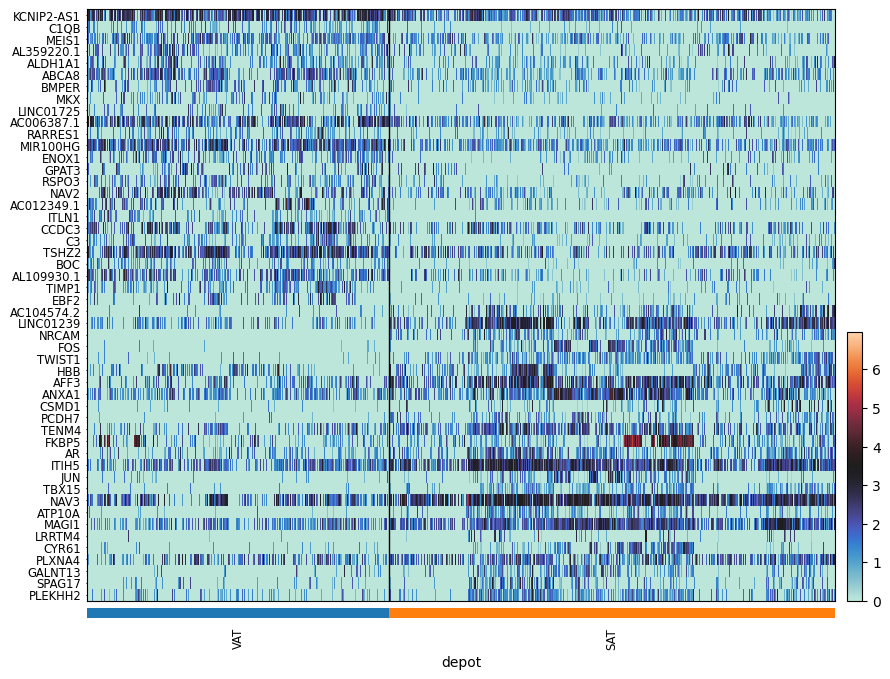

In [92]:
custom_palette = sns.color_palette("icefire", as_cmap=True)

sc.pl.heatmap(
    adipocyte_data,
    genes_to_show,
    groupby='depot',  
    swap_axes=True,
    cmap=custom_palette,  
    figsize=(10, 8),  
    show_gene_labels=True,  
)

## 2. Running Deseq2 on BMI

In [10]:
metadata_df_bmi = adipocyte_data.obs[["bmi_group"]].astype(str)
metadata_df_bmi.head(5)

bmi_group
AAACGCTGTATACGGG     40-50
AAAGGTACACCTGCGA     40-50
AAAGTCCGTTCCAAAC     40-50
AACAACCCATTCCTCG     40-50
AACAAGAAGATTAGAC     40-50

In [11]:
dds_bmi = DeseqDataSet(
    counts=counts_df,
    metadata=metadata_df_bmi,
    design_factors="bmi_group",
)

In [12]:
dds_bmi.deseq2()

Fitting size factors...
... done in 1.63 seconds.

Fitting dispersions...
... done in 2561.20 seconds.

Fitting dispersion trend curve...
... done in 0.24 seconds.

Fitting MAP dispersions...
... done in 2405.88 seconds.

Fitting LFCs...
... done in 85.29 seconds.

Calculating cook's distance...
... done in 25.20 seconds.

Replacing 11 outlier genes.

Fitting dispersions...
... done in 1.39 seconds.

Fitting MAP dispersions...
... done in 1.17 seconds.

Fitting LFCs...
... done in 0.07 seconds.



In [14]:
adipocyte_data.obs['bmi_group'].unique()

['40-50', '20-30', '30-40']
Categories (3, object): ['20-30', '30-40', '40-50']

In [18]:
dds_bmi.obs

bmi-group
AAACGCTGTATACGGG     40-50
AAAGGTACACCTGCGA     40-50
AAAGTCCGTTCCAAAC     40-50
AACAACCCATTCCTCG     40-50
AACAAGAAGATTAGAC     40-50
...                    ...
TTTACGTAGCAACCAG     20-30
TTTACGTCATCGAGCC     20-30
TTTATGCGTTCGAACT     20-30
TTTGATCGTCCGGACT     20-30
TTTGGTTGTGTCTTCC     20-30

[21895 rows x 1 columns]

In [19]:
stat_res1 = DeseqStats(dds_bmi, contrast=('bmi-group','20-30', '40-50'))
stat_res1

In [20]:
stat_res1.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: bmi-group 20-30 vs 40-50
           baseMean  log2FoldChange     lfcSE       stat         pvalue  \
GENE                                                                      
A1CF       0.008364       -0.223618  0.527858  -0.423633   6.718333e-01   
A2M        0.331476       -0.438909  0.058095  -7.555011   4.188260e-14   
A2M-AS1    0.039919       -0.254557  0.259366  -0.981457   3.263677e-01   
A2ML1      0.015896       -0.232105  0.362773  -0.639808   5.222977e-01   
A2ML1-AS1  0.217481       -0.197996  0.050117  -3.950634   7.794453e-05   
...             ...             ...       ...        ...            ...   
ZYG11A     0.006747       -0.216538  0.569200  -0.380425   7.036298e-01   
ZYG11B     0.426218       -0.577313  0.041004 -14.079343   5.088068e-45   
ZYX        0.058455       -0.267425  0.168428  -1.587767   1.123390e-01   
ZZEF1      0.702431       -0.840635  0.033674 -24.963602  1.519901e-137   
ZZZ3       1.118147       -1.037418  

... done in 16.40 seconds.



In [21]:
res_bmi = stat_res1.results_df
res_bmi

baseMean  log2FoldChange     lfcSE       stat         pvalue  \
GENE                                                                      
A1CF       0.008364       -0.223618  0.527858  -0.423633   6.718333e-01   
A2M        0.331476       -0.438909  0.058095  -7.555011   4.188260e-14   
A2M-AS1    0.039919       -0.254557  0.259366  -0.981457   3.263677e-01   
A2ML1      0.015896       -0.232105  0.362773  -0.639808   5.222977e-01   
A2ML1-AS1  0.217481       -0.197996  0.050117  -3.950634   7.794453e-05   
...             ...             ...       ...        ...            ...   
ZYG11A     0.006747       -0.216538  0.569200  -0.380425   7.036298e-01   
ZYG11B     0.426218       -0.577313  0.041004 -14.079343   5.088068e-45   
ZYX        0.058455       -0.267425  0.168428  -1.587767   1.123390e-01   
ZZEF1      0.702431       -0.840635  0.033674 -24.963602  1.519901e-137   
ZZZ3       1.118147       -1.037418  0.029804 -34.807878  1.848541e-265   

                    padj  
GENE                      
A1CF                 NaN  
A2M         1.132220e-13  
A2M-AS1              NaN  
A2ML1                NaN  
A2ML1-AS1   1.353767e-04  
...                  ...  
ZYG11A               NaN  
ZYG11B      2.533821e-44  
ZYX         1.232331e-01  
ZZEF1      1.991746e-136  
ZZZ3       5.952412e-264  

[19035 rows x 6 columns]

In [25]:
sigs_bmi = res_bmi.sort_values('log2FoldChange', ascending= False)


baseMean  log2FoldChange     lfcSE       stat         pvalue  \
GENE                                                                      
FKBP5      5.458644        3.845916  0.063595  60.474744   0.000000e+00   
TIPARP     0.756962        2.078677  0.077965  26.661580  1.313798e-156   
GLUL       0.822393        1.997450  0.051379  38.877099   0.000000e+00   
C6         0.841594        1.970727  0.053418  36.892363  6.126343e-298   
LINC02456  0.768137        1.644934  0.047648  34.522539  3.682626e-261   
...             ...             ...       ...        ...            ...   
LINC00968  1.957017       -2.550713  0.046781 -54.524775   0.000000e+00   
CCDC3      2.150604       -2.613615  0.040435 -64.637968   0.000000e+00   
COL3A1     2.879650       -2.626362  0.031626 -83.045466   0.000000e+00   
SEMA3C     4.145825       -2.701440  0.028779 -93.868184   0.000000e+00   
HBB        3.015934       -3.181091  0.056806 -55.998721   0.000000e+00   

                    padj  
GENE                      
FKBP5       0.000000e+00  
TIPARP     1.975402e-155  
GLUL        0.000000e+00  
C6         2.259296e-296  
LINC02456  1.158488e-259  
...                  ...  
LINC00968   0.000000e+00  
CCDC3       0.000000e+00  
COL3A1      0.000000e+00  
SEMA3C      0.000000e+00  
HBB         0.000000e+00  

[19035 rows x 6 columns]

In [27]:
sigs_bmi = res_bmi[(res_bmi['padj'] < 0.05) & (abs(res_bmi['log2FoldChange']) > 0.5)].sort_values('log2FoldChange', ascending=False)

sigs_bmi

baseMean  log2FoldChange     lfcSE       stat         pvalue  \
GENE                                                                      
FKBP5      5.458644        3.845916  0.063595  60.474744   0.000000e+00   
TIPARP     0.756962        2.078677  0.077965  26.661580  1.313798e-156   
GLUL       0.822393        1.997450  0.051379  38.877099   0.000000e+00   
C6         0.841594        1.970727  0.053418  36.892363  6.126343e-298   
LINC02456  0.768137        1.644934  0.047648  34.522539  3.682626e-261   
...             ...             ...       ...        ...            ...   
LINC00968  1.957017       -2.550713  0.046781 -54.524775   0.000000e+00   
CCDC3      2.150604       -2.613615  0.040435 -64.637968   0.000000e+00   
COL3A1     2.879650       -2.626362  0.031626 -83.045466   0.000000e+00   
SEMA3C     4.145825       -2.701440  0.028779 -93.868184   0.000000e+00   
HBB        3.015934       -3.181091  0.056806 -55.998721   0.000000e+00   

                    padj  
GENE                      
FKBP5       0.000000e+00  
TIPARP     1.975402e-155  
GLUL        0.000000e+00  
C6         2.259296e-296  
LINC02456  1.158488e-259  
...                  ...  
LINC00968   0.000000e+00  
CCDC3       0.000000e+00  
COL3A1      0.000000e+00  
SEMA3C      0.000000e+00  
HBB         0.000000e+00  

[3196 rows x 6 columns]

In [32]:
genes_to_show_bmi = sigs_bmi.index[-25:].tolist() + sigs_bmi.index[:25].tolist()


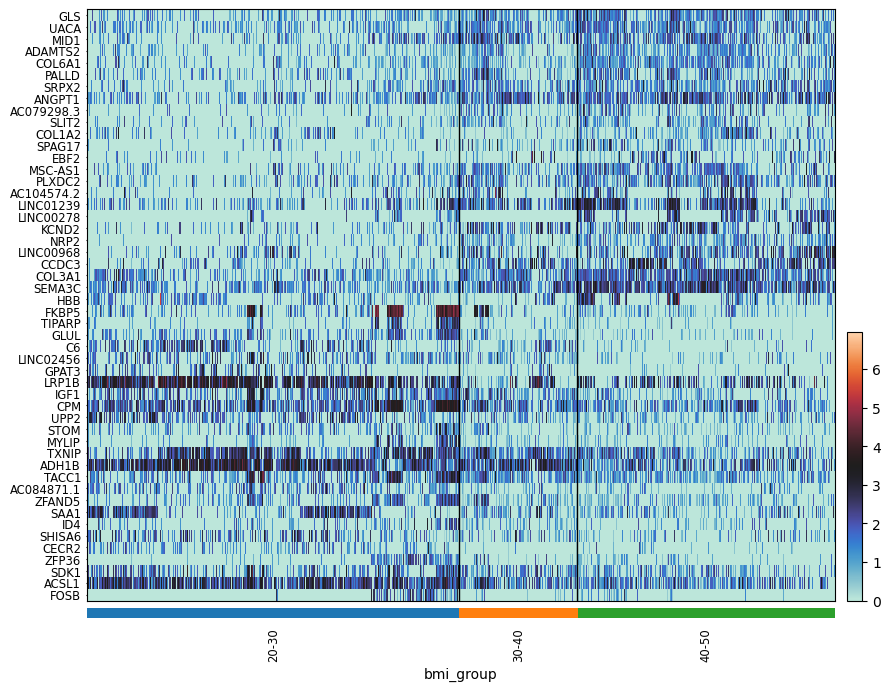

In [34]:
custom_palette = sns.color_palette("icefire", as_cmap=True)

sc.pl.heatmap(
    adipocyte_data,
    genes_to_show_bmi,
    groupby='bmi_group',  
    swap_axes=True,
    cmap=custom_palette,  
    figsize=(10, 8),  
    show_gene_labels=True
    #save='heatmap_DE_adipo_bmi.png'
)

In [36]:
# some visualizations for depot DE

Total number of genes tested: 19035
Number of significant DE genes: 1214
Number of upregulated genes: 1115
Number of downregulated genes: 99


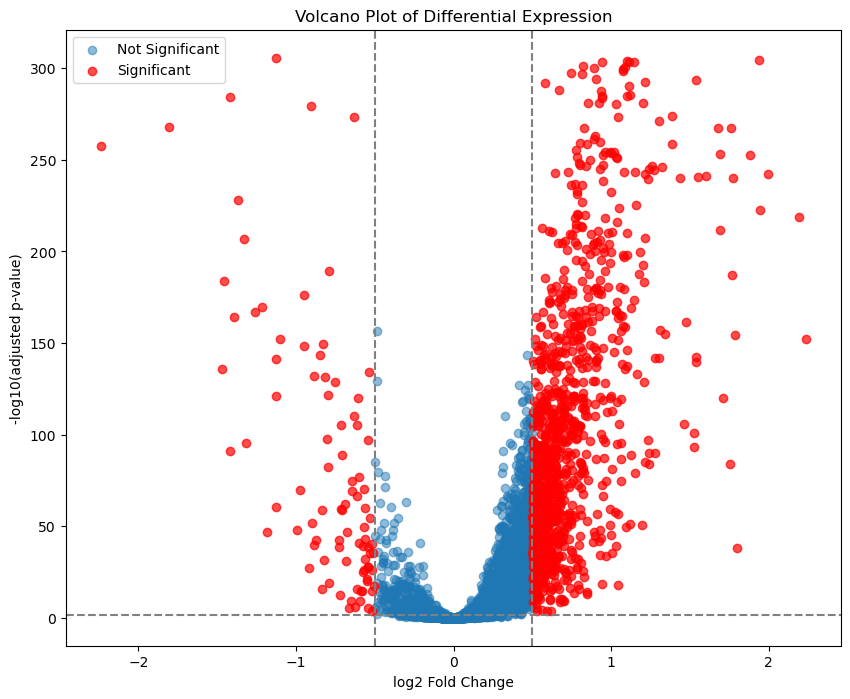

In [24]:
alpha=0.05
lfc_threshold=0.5

results_sorted = res.sort_values('padj')

# filtering for significant genes
sig_results = res[res['significant']]

plt.figure(figsize=(10, 8))
plt.scatter(res[~res['significant']]['log2FoldChange'], 
                -np.log10(res[~res['significant']]['padj']),
                alpha=0.5, label='Not Significant')
plt.scatter(sig_results['log2FoldChange'],
                -np.log10(sig_results['padj']),
                color='red', alpha=0.7, label='Significant')
plt.axhline(-np.log10(alpha), color='gray', linestyle='--')
plt.axvline(-lfc_threshold, color='gray', linestyle='--')
plt.axvline(lfc_threshold, color='gray', linestyle='--')
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(adjusted p-value)')
plt.legend()
plt.title('Volcano Plot of Differential Expression')

# summary statistics
print(f"Total number of genes tested: {len(res)}")
print(f"Number of significant DE genes: {len(sig_results)}")
print(f"Number of upregulated genes: {len(sig_results[sig_results['log2FoldChange'] > 0])}")
print(f"Number of downregulated genes: {len(sig_results[sig_results['log2FoldChange'] < 0])}")

Text(0.5, 1.0, 'MA Plot')

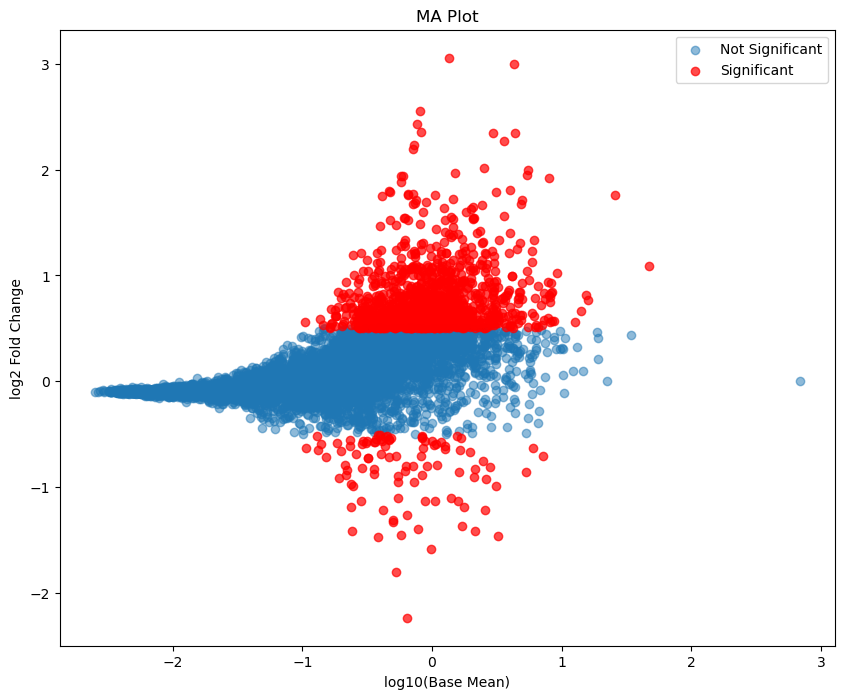

In [26]:
# MA plot

plt.figure(figsize=(10, 8))
baseMean = np.log10(res['baseMean'])
plt.scatter(baseMean[~res['significant']], 
                res[~res['significant']]['log2FoldChange'],
                alpha=0.5, label='Not Significant')
plt.scatter(baseMean[res['significant']],
                res[res['significant']]['log2FoldChange'],
                color='red', alpha=0.7, label='Significant')
plt.xlabel('log10(Base Mean)')
plt.ylabel('log2 Fold Change')
plt.legend()
plt.title('MA Plot')

---

#### Sample comparison: Absolute number of Adip against number of LAM and interpretation of the change over BMI

In [37]:
adata = sc.read_h5ad('annotaed_1.h5ad')
adata

AnnData object with n_obs × n_vars = 272623 × 43411
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_counts', 'doublet', 'doublet_score', 'batch', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type'
    var: 'ensembl_id', 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [45]:
macrophages_data = sc.read_h5ad('macrophages_2.h5ad')
macrophages_data

AnnData object with n_obs × n_vars = 15796 × 15880
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'n_counts', 'doublet', 'doublet_score', 'batch', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type', 'biosample_type', 'library_preparation_protocol', 'donor_id', 'species', 'organ', 'tissue', 'depot', 'sex', 'race', 'ethnicity', 'development_stage', 'organism_age', 'disease', 'mouse_strain', 'organism_weight', 'bmi_value', 'bmi_group', 'diet_type', 'diet_schedule', 'LAM_score', 'LAM_cells', 'MMe_score', 'inflammatory_macrophages'
    var: 'n_cells'
    uns: 'LAM_cells_colors', 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'inflammatory_macrophages_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_conti

In [83]:
from matplotlib.ticker import StrMethodFormatter

def analyze_cell_composition(macrophages_data, adipocyte_data):
    """
    Analyze and visualize the relationship between Adipocytes and LAM cells
    across BMI groups.
    """
    # Get cell counts per sample for each cell type
    mac_counts = pd.DataFrame({
        'Sample': macrophages_data.obs['Sample'].astype(str),
        'BMI_group': macrophages_data.obs['bmi_group'].astype(str),
        'LAM': macrophages_data.obs['LAM_cells'].astype(bool)
    })
    
    adip_counts = pd.DataFrame({
        'Sample': adipocyte_data.obs['Sample'].astype(str),
        'BMI_group': adipocyte_data.obs['bmi_group'].astype(str),
        'Adipocyte': adipocyte_data.obs['mature_adipocytes'].astype(bool)
    })
    
    # Count cells per sample
    lam_counts = (mac_counts[mac_counts['LAM']]
                 .groupby(['Sample', 'BMI_group'])
                 .size()
                 .reset_index(name='LAM_count'))
    
    adipocyte_counts = (adip_counts[adip_counts['Adipocyte']]
                       .groupby(['Sample', 'BMI_group'])
                       .size()
                       .reset_index(name='Adipocyte_count'))
    
    # Merge the counts
    merged_counts = pd.merge(lam_counts, adipocyte_counts, on=['Sample', 'BMI_group'], how='outer')
    merged_counts['LAM_count'] = merged_counts['LAM_count'].fillna(0)
    merged_counts['Adipocyte_count'] = merged_counts['Adipocyte_count'].fillna(0)
    
    # Create visualizations
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), facecolor='#f0f0f0')
    
    # 1. Scatter plot
    sns.scatterplot(data=merged_counts, x='Adipocyte_count', y='LAM_count', 
                    hue='BMI_group', palette='viridis', ax=ax1)
    ax1.set_title('LAM vs Adipocyte Count by BMI Group', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Number of Adipocytes', fontsize=12)
    ax1.set_ylabel('Number of LAM cells', fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.legend(title='BMI Group', fontsize=10)
    
    # 2. Box plot for LAM cells
    sns.boxplot(data=merged_counts, x='BMI_group', y='LAM_count', palette='viridis', ax=ax2)
    ax2.set_title('LAM Cell Distribution by BMI Group', fontsize=14, fontweight='bold')
    ax2.set_xlabel('BMI Group', fontsize=12)
    ax2.set_ylabel('Number of LAM cells', fontsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    
    # 3. Ratio plot (LAM/Adipocyte)
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    merged_counts['LAM_Adipocyte_ratio'] = merged_counts['LAM_count'] / (merged_counts['Adipocyte_count'] + epsilon)
    sns.boxplot(data=merged_counts, x='BMI_group', y='LAM_Adipocyte_ratio', palette='viridis', ax=ax3)
    ax3.set_title('LAM/Adipocyte Ratio by BMI Group', fontsize=14, fontweight='bold')
    ax3.set_xlabel('BMI Group', fontsize=12)
    ax3.set_ylabel('LAM/Adipocyte Ratio', fontsize=12)
    ax3.tick_params(axis='both', which='major', labelsize=10)
    
    # Format y-axis ticks with commas
    for ax in [ax1, ax2, ax3]:
        ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    
    plt.suptitle('LAM and Adipocytes Composition Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Calculate summary statistics
    stats = merged_counts.groupby('BMI_group').agg({
        'LAM_count': ['mean', 'std', 'count'],
        'Adipocyte_count': ['mean', 'std'],
        'LAM_Adipocyte_ratio': ['mean', 'std']
    }).round(2)
    plt.savefig('cell_composition_analysis.png', dpi=300)
    return merged_counts, stats, fig


In [84]:

def calculate_correlations(merged_counts):
    """
    Calculate correlations between LAM and Adipocyte counts for each BMI group
    """
    correlations = {}
    for bmi_group in merged_counts['BMI_group'].unique():
        group_data = merged_counts[merged_counts['BMI_group'] == bmi_group]
        corr = np.corrcoef(group_data['LAM_count'], group_data['Adipocyte_count'])[0,1]
        correlations[bmi_group] = round(corr, 3)
    
    return correlations

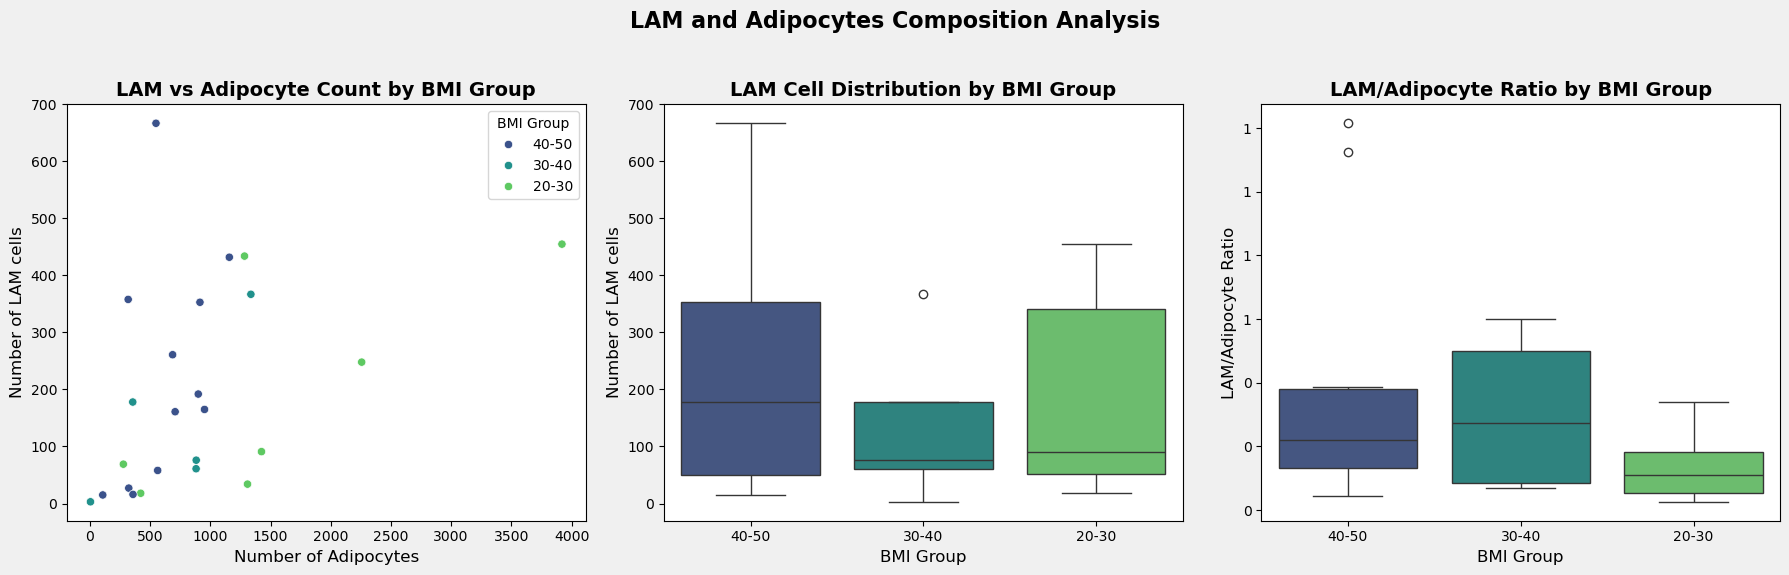

In [85]:
# Run the analysis
merged_counts, stats, fig = analyze_cell_composition(macrophages_data, adipocyte_data)

# Get correlations
correlations = calculate_correlations(merged_counts)
plt.show()

In [82]:
# Display results
print("Summary Statistics:")
print(stats)
print("\nCorrelations between LAM and Adipocyte counts by BMI group:")
print(correlations)

# Display the figure
plt.show()

Summary Statistics:
          LAM_count               Adipocyte_count           \
               mean     std count            mean      std   
BMI_group                                                    
20-30        192.71  187.72     7         1556.43  1235.00   
30-40        137.00  143.21     5          692.60   518.04   
40-50        225.42  199.37    12          628.08   315.58   

          LAM_Adipocyte_ratio        
                         mean   std  
BMI_group                            
20-30                    0.13  0.12  
30-40                    0.31  0.24  
40-50                    0.37  0.39  

Correlations between LAM and Adipocyte counts by BMI group:
{'40-50': 0.399, '30-40': 0.676, '20-30': 0.72}


In [ ]:
'''
Aufgaben:
1. relative Anteil an LAM pro Sample im Bezug auf Mac (DONE) und alle Immunzellen PTPRC
2. Anzahl an Mature Adipocytes pro Sample extrahieren Und die Veränderung nach BMI Range vergleichen (DONE)
4. Die Zahl von reifen Adipo mit BMI größer anschauen
5. MTOR, S6,
6. DE von Adipo über BMI Gruppen. vllt MTOR, S6,? (DONE)
7. Probenvergleich: Absolute Anzahl von Adip gegen Anzahl LAM und die Veränderung interpretieren  (DONE)
8. Später mit dem Validierungsdatensatz für Bulk-RNA die Hypothese validieren lassen
'''

In [ ]:
#################################################################################################################################

---